# Kapunda Exploratory plots

Reads experimental data and cleans it. Then plots the data for column experiments number 1 to 5

In [ ]:
import pandas as pd
import numpy as np

In [ ]:
# column data includes cu recovery (from AAS), pore volume exchange, and measured parameters
column_data = pd.read_excel('./input/columns_master.xlsx', sheet_name = 'column_data')

#solution_icp includes icp data for elements (including copper)
solution_icp = pd.read_excel('./input/columns_master.xlsx', sheet_name = 'solution_icp', header=2)
solution_icp[solution_icp._get_numeric_data()<0] = np.nan #bdl to nan
solution_icp = solution_icp.replace('<', '', regex=True)

In [ ]:
summary = column_data.groupby('column').describe().T
summary.to_csv('./output/dataframes/colmun_summary.csv')

In [ ]:
solution_icp.head()

In [ ]:
alldata =pd.merge(column_data, solution_icp, how='outer')
alldata.to_csv('./output/dataframes/kapunda.csv')

In [ ]:
alldata.head()

## Data crunching

The following cells melt the data. In addition, non-used parameters are dropped and the units are changed from weight to moles.

Also, the columns were initially run with site water with a specific composition. Then CSIRO received new site water with different composition (high copper content). Here that that is read, first to transform units from weight to moles and then to read the pore volumes when this new site waters where put in. 

In [ ]:
from mol_calc import elements_dict

alldata_melted = pd.melt(alldata, id_vars =['column', 'column_name','elapsed_time_h','date','date_time','time','volume_cumulative_sample_pv'])
print(pd.unique(alldata_melted.variable))

no_plot = ['mass_sample_g', 'stages',
       'density_sample_gm/L', 'volume_sample_mL',
       'volume_solution_container_mL', 'flowrate_mL/h',
       'volume_sample_pv', 'column_pressure',
       'mass_solution_container_g' ,'volume_cumulative_sample_mL',
       'Au_ug/L', 'Ag_ug/L', 
       # 'Ba_mg/L', 
       'Be_mg/L',
       'Bi_mg/L', 
       # 'Cd_mg/L', 'Ce_ug/L',  'Cs_ug/L', 
       #'Dy_ug/L',
       'Er_ug/L', 'Eu_ug/L', 'Ga_mg/L', 'Gd_mg/L', 'Hf_mg/L', 'Ho_ug/L', 'In_ug/L',
       # 'La_ug/L', 
       'Lu_ug/L',  'Nd_ug/L',  
       'Pr_ug/L', 'Rb_ug/L', 'Sb_ug/L', 'Se_mg/L', 'Sm_ug/L', 'Sn_mg/L', 'Sr_mg/L',
       'Tb_ug/L', 'Te_mg/L', 'Th_ug/L', 'Tl_ug/L', 'Tm_ug/L', 'U_mg/L', 'Y_ug/L',
       'Yb_ug/L', 'Zr_mg/L', 'B_mg/L', 
       # 'Cr_mg/L', 
       'Pb_mg/L',
       #'Ti_mg/L', 
       'V_mg/L', 'Cu from AA (mg/L) new site water','Cu_extracted_g' ,'Cu_cumulative_g','Cu_mg/L',
       'As_mg/L', 
       # 'Mn_mg/L', 'Mo_mg/L', 'Co_mg/L'
       ]
alldata_melted_selection = alldata_melted[np.logical_not(alldata_melted['variable'].isin(no_plot))]
alldata_melted_selection = alldata_melted_selection.drop(columns = ['date', 'date_time','time'])
alldata_melted_selection['value'] = alldata_melted_selection['value'].astype('float')
alldata_melted_selection = alldata_melted_selection.dropna()

###### uncomment this line if want to plot Cu from AA (mg/L) new site water
# alldata_melted_selection['variable'] = np.where(alldata_melted_selection['variable'] == 'Cu from AA (mg/L) new site water',
#                                           'Cu_AAnewsitewater_mg/L',
#                                           alldata_melted_selection['variable'])

alldata_melted_selection['value_g'] = np.where(alldata_melted_selection['variable'].str.contains('mg/L'), 
       alldata_melted_selection['value']/1000,
       np.where(alldata_melted_selection['variable'].str.contains('ug/L'),alldata_melted_selection['value']/1000000,
       alldata_melted_selection['value']))

alldata_melted_selection['units'] = alldata_melted_selection['variable'].str.split('_',3).str[-1]

alldata_melted_selection['param'] = alldata_melted_selection['variable'].str.split('_',3).str[0]
alldata_melted_selection['comment'] = alldata_melted_selection['variable'].str.split('_',1).str[-1]
alldata_melted_selection['comment'] = np.where(alldata_melted_selection['comment'].str.contains('_'),
                                   alldata_melted_selection['comment'].str.split('_',1).str[0],
                                   ''
                                   )

alldata_melted_selection['cat'] = np.where((alldata_melted_selection['variable'].str.contains('g/L')),
                                   'compo',
                                   'parameter'
                                   )
alldata_melted_selection['mol_mass'] = alldata_melted_selection['param'].map(elements_dict)                                  
alldata_melted_selection['value_mmol'] = np.where(alldata_melted_selection['cat'] == 'compo',
                                   alldata_melted_selection['value_g']/alldata_melted_selection['mol_mass']*1000,
                                   alldata_melted_selection['value'])  
alldata_melted_selection['variable_to_plot'] = np.where(alldata_melted_selection['cat'] == 'compo',
                                   alldata_melted_selection['param'] +' mmol/L '+alldata_melted_selection['comment'],
                                   alldata_melted_selection['param']+' ' +alldata_melted_selection['units'])
# alldata_melted_selection['variable_to_plot'] 
alldata_melted_selection['variable_to_plot'] = alldata_melted_selection['variable_to_plot'].str.rstrip()
alldata_melted_selection['variable_to_plot'] =  np.where(alldata_melted_selection['variable_to_plot'] == 'Cu mmol/L AA', 'Cu mmol/L', alldata_melted_selection['variable_to_plot'])
print(pd.unique(alldata_melted_selection.variable_to_plot))
alldata_melted_selection.to_csv('./output/dataframes/kapunda_melted_selected.csv')
alldata_melted_selection.head()


In [ ]:
### Reads data for different experimental stages (I ended up doing this by hand...way easier)

stages = pd.read_excel('./input/columns_master.xlsx', sheet_name = 'stages')
stages = stages.replace(np.nan, np.inf)
stages = stages.replace(-1, np.nan)
stages

In [ ]:
# Reading new site waters coming into the experiment

sw_inflow  = pd.read_excel('./input/columns_master.xlsx', sheet_name = 'new_sw_inflow')
sw_inflow

In [ ]:
import rpy2
%load_ext rpy2.ipython

In [ ]:
%%R -i alldata_melted_selection -i stages -i sw_inflow

library(ggplot2)
library(ggpubr)
scaleFUN <- function(x) sprintf("%.3f", x)

print(stages[(stages$column==1)& (stages$stage == 'stage 0'),8])
print(sw_inflow[sw_inflow$column==1,2])
############### Solution chemistry data
i=1
while (i <= max(alldata_melted_selection$column))
{

data_to_plot = subset(alldata_melted_selection,  column == i )
maxpv = round(max(data_to_plot$volume_cumulative_sample_pv)/5)*5
explora_plots = (ggplot(data_to_plot, aes(x = volume_cumulative_sample_pv, y= value_mmol))
#    + geom_vline(xintercept = 7.15, color='#a6a6a6', linetype = 'dashed', size = 0.7)
   + geom_point(size =3, shape = 21,fill = '#C1C1C1')
   + facet_wrap(~variable_to_plot, scales = 'free_y',switch = 'y', ncol=3)
   + labs(x='Cumulative pore volume', y = '',fill = 'Stages')
   + ggtitle(paste0('Column ',i,': ', data_to_plot$column_name))
   + scale_x_continuous(limits=c(0, maxpv+1), breaks=seq(0,maxpv,10))
   + scale_y_continuous(breaks = scales::pretty_breaks(5), limits = c(NA, NA),labels=scaleFUN )
   # + scale_shape_manual(values=c(21, 22, 23, 24, 25))
   + theme_bw()
   + theme(text = element_text(family = 'arial', size = 14),strip.placement = 'outside',  strip.background = element_blank(), strip.text = element_text(size=12, face='bold'),
    legend.text=element_text(size=12), plot.margin = margin(.2,.2,.2,.2, "cm"), panel.grid = element_blank(),
    axis.text = element_text(size  = 12))
   )
if (i<=4){
xmin_st0 = stages[(stages$column==i)& (stages$stage == 'stage 0'),7]   
xmax_st0 = stages[(stages$column==i)& (stages$stage == 'stage 0'),8]
xmin_st1 = stages[(stages$column==i)& (stages$stage == 'stage 1'),7]
xmax_st1 = stages[(stages$column==i)& (stages$stage == 'stage 1'),8]
xmin_st2 = stages[(stages$column==i)& (stages$stage == 'stage 2'),7]
xmax_st2 = stages[(stages$column==i)& (stages$stage == 'stage 2'),8]
xmin_st3 = stages[(stages$column==i)& (stages$stage == 'stage 3'),7]
xmax_st3 = stages[(stages$column==i)& (stages$stage == 'stage 3'),8]
inflow = sw_inflow[sw_inflow$column==i,2]
explora_plots$layers = c(geom_rect(aes(xmin=xmin_st0, xmax = xmax_st0, ymin=0, ymax=Inf,fill = 'Stage 0: Site Water')),
                        geom_rect(aes(xmin=xmin_st1, xmax = xmax_st1, ymin=0, ymax=Inf, fill = 'Stage 1: Acid')),
                        geom_rect(aes(xmin=xmin_st2, xmax = xmax_st2, ymin=0, ymax=Inf, fill='Stage 2: 0.1M Fe')),
                        geom_rect(aes(xmin=xmin_st3, xmax = xmax_st3, ymin=0, ymax=Inf, fill ='Stage 3: 0.5M Fe')),
                        geom_vline(aes(xintercept = inflow, color = 'New site water'),linetype = "dashed"),
                        explora_plots$layers)
}

explora_plots = explora_plots+ scale_fill_manual(values= c('#e6fffd','#b0e8b8','#F6DCA9','#F6C0A9')) + scale_color_manual(values= '#6e6a69')

filename = paste0('./output/plots/explora_plots_column',i,'.svg')
ggsave(plot = explora_plots,filename = filename, height = 10 , width = 18 )
i=i+1
}

## Site Water Chemistry

Converts site water from mg/L to moles. Then saves to a csv file. Use this file for phreeqc/PHT3D input solution

In [ ]:
sw = pd.read_excel('./input/columns_master.xlsx', sheet_name = 'sw_icp',header=2)
sw = sw.replace('<', '', regex=True)
sw[sw._get_numeric_data()<0] = np.nan #bdl to nan
sw_melted = pd.melt(sw, id_vars =['sample_id'])
sw_melted = sw_melted.dropna()
sw_melted['value'] = sw_melted['value'].astype('float')

In [ ]:
from mol_calc import elements_dict

sw_melted_mod = sw_melted
sw_melted_mod['value_g'] = np.where(sw_melted_mod['variable'].str.contains('mg/L'), 
       sw_melted_mod['value']/1000,
       np.where(sw_melted_mod['variable'].str.contains('ug/L'),sw_melted_mod['value']/1000000,
       sw_melted_mod['value']))

sw_melted_mod['units'] = sw_melted_mod['variable'].str.split('_',3).str[-1]
sw_melted_mod['param'] = sw_melted_mod['variable'].str.split('_',3).str[0]

sw_melted_mod['mol_mass'] = sw_melted_mod['param'].map(elements_dict)   
sw_melted_mod['value_mmol'] = sw_melted_mod['value_g']/sw_melted_mod['mol_mass']*1000
sw_melted_mod = sw_melted_mod.dropna()
# sw_melted_mod.to_csv('./output/dataframes/sitewater_mol.csv')

# Modelling results

Graphs of selected ions and the correspond models from PHT3D/phreeqc

## Model Version: Kapunda Single Domain version 00 (kapunda_sd_00)


Reading data from model output and plotting it on top of selected ions
### Reading UCN files | Merges with data

Comment the next two cells if reading data from selected output

In [ ]:
# from flopy.utils import UcnFile
# import flopy as fl
# import matplotlib.pyplot as plt
# import numpy as np
# import glob
# import pandas as pd

# model_soft = 'pht3d'
# model_version = '04'
# folder = 'kapunda_' + model_soft + '_' + model_version 
# path = './model/'+ model_soft + '/' + folder 
# filename = 'MT3D001.UCN'

# columnid = 2

# list_UCN = glob.glob(path + '/' + 'PHT3D*[!S].UCN')


# columns = ['column', 'elapsed_time_d', 'value','file_name']  	
# model_results = pd.DataFrame(umns=columns)

# sim_times = np.loadtxt(path+'/PHT3D_OUTPUT_TIMES.ACN')
# # print(UcnFile(list_UCN[0]).get_alldata()[0,0,0,:].size)
# resultsdict = []

# for name in list_UCN:
#     print(name)
#     ucn_temp = UcnFile(name)
#     concs_temp = ucn_temp.get_alldata()

#     times_temp = ucn_temp.get_times()
#     last_cell_x = concs_temp[0,0,0,:].size
#     # print(last_cell_x)
#     concs_exit  = concs_temp[:,:,:,last_cell_x - 1].flatten()
#     concs_exit = concs_exit.tolist()
    
#     kper = ucn_temp.get_kstpkper()

#     times_temp = np.array(times_temp)
#     times_temp = times_temp.tolist()

#     identificator = name.lstrip(path)
#     identificator = identificator.rstrip('.UCN')

#     df =  pd.DataFrame({
#         'column': columnid,
#         'elapsed_time_d' : times_temp,
#         'value': concs_exit,
#         'file_name' : identificator,
#         'n_param': int(identificator.lstrip('PHT3D').rstrip('S')),
#     })
#     model_results = model_results.append(df)


# model_results = model_results[np.round(model_results['elapsed_time_d'],2).isin(np.round(sim_times, 2))]

# model_results.to_csv(path+'/model' + model_version +'_ucn.csv')


In [ ]:
# import re

# pht3dcheckfile =  open(path + '/' + 'pht3d_input_check.dat').readlines()


# species_to_filename = {}
# numb = 'Component '
# n_param=0
# for line in pht3dcheckfile:
#     line = line.rstrip()
#     if numb in line:
#         tmp = line.replace(':', '').split()[1:3]
#         n = 3-len(str(tmp[0]))
#         zeros = '0'
#         species_to_filename.update({'PHT3D'+n*zeros+str(tmp[0]):tmp[1]})
#         n_param = n_param+1

# model_result_df = model_results.copy()

# if n_param < max(model_result_df['n_param']):
#     model_result_df = model_result_df[model_result_df['n_param'] <= n_param]

# model_result_df['param'] = model_result_df['file_name'].map(species_to_filename)
# model_result_df['value'] = np.where(model_result_df['param'] == 'pe', model_result_df['value']*0.059*1000-200, model_result_df['value'])
# model_result_df['param'] = np.where(model_result_df['param'] == 'pe', 'Eh', model_result_df['param'])
# model_result_df['units'] = np.where( (model_result_df['param'] == 'Eh'), 'mV', 
#                             np.where( (model_result_df['param'] == 'pH'), '', 'mmol/L'
#                             ))
# model_result_df['value'] = np.where(model_result_df['units'] == 'mmol/L', model_result_df['value'] *1000 ,model_result_df['value'] )

# model_result_df = model_result_df.drop(columns = 'file_name')

# Cu_1 = model_result_df[model_result_df['param'] == 'Cu(1)']
# Cu_2 = model_result_df[model_result_df['param'] == 'Cu(2)']
# Cu_tot = Cu_1.copy()

# Cu_tot['value'] = Cu_1['value'] + Cu_2['value']
# Cu_tot['param'] = 'Cu'

# Cu_recovered = Cu_tot.copy()
# # Cu_recovered['value'] = np.where(Cu_recovered['elapsed_time_d'] >= 66, Cu_recovered['value']-1.18549292376126, Cu_recovered['value']-0.00629465269253769) #g/L(in cell) minus Cu in new site water
# # Cu_recovered['value'] = Cu_recovered['value'].cumsum() /1000*63.546
# # Cu_recovered['value'] = Cu_recovered['value'] * 0.000634391*1000/27 #g/L (incell) * bulk volume / n cells
# # Cu_recovered['value'] = Cu_recovered['value']/3.4832643*100
# # Cu_recovered['param'] = 'Cu'
# # Cu_recovered['units'] = '%'
# # print(Cu_recovered)

# ############ Get Time Step ###########################################################

# tstp = np.gradient(pd.unique(model_result_df['elapsed_time_d']))[0] # days
# flow_rate = 0.0002208 * 1000 # L/d
# ############# Total Copper Recovery calculations #####################################

# # Cu_recovered.loc[:,'value'] = np.where(Cu_recovered['elapsed_time_d'] >= 66, Cu_recovered['value']-1.18549292376126, 
#                                 # Cu_recovered['value']-0.00629465269253769) #g/L(in cell) minus Cu in new site water/// Adjust Cu concentrations by the Cu in the input solutions
# Cu_recovered.loc[:,'value'] = Cu_recovered['value']*flow_rate*tstp # converts concentration to total mass of copper recovered over each time step
# Cu_recovered.loc[:,'value'] = Cu_recovered['value']/1000*63.546 # convert from mmol to grams
# # Cu_recovered['value']
# Cu_recovered.loc[:,'value'] = Cu_recovered['value'].cumsum()  #Cummulative sum of mass for each time step
# Cu_recovered.loc[:,'value'] = Cu_recovered['value']/3.4832643*100 #Get percentage respect to initial mass of copper
# Cu_recovered.loc[:,'param'] = 'Cu'
# Cu_recovered.loc[:,'units'] = '%'
# model_result_df =  model_result_df.append(Cu_recovered)

# Fe_2 = model_result_df[model_result_df['param'] == 'Fe(2)']
# Fe_3 = model_result_df[model_result_df['param'] == 'Fe(3)']
# Fe_tot = Fe_2

# Fe_tot['value'] = Fe_2['value'] + Fe_3['value']
# Fe_tot['param'] = 'Fe'
# Fe_tot

# S_2 = model_result_df[model_result_df['param'] == 'S(-2)']
# S_6 = model_result_df[model_result_df['param'] == 'S(6)']
# S_tot = S_2
# S_tot['value'] = S_2['value'] + S_6['value']
# S_tot['param'] = 'S'
# S_tot

# model_result_df = model_result_df.append(Fe_tot)
# model_result_df = model_result_df.append(Cu_tot)
# model_result_df = model_result_df.append(S_tot)
# model_result_df =  model_result_df.append(Cu_recovered)
# model_result_df['variable_to_plot'] = np.where(model_result_df['param'] == 'pH', model_result_df['param'], model_result_df['param'] + ' ' + model_result_df['units'])
# model_result_df['volume_cumulative_sample_pv'] = model_result_df['elapsed_time_d']*24*88.9697605598692/2352
# model_result_df

# model = model_result_df.drop(columns=['elapsed_time_d','param', 'units', 'n_param'])

# data = alldata_melted_selection[['column','variable_to_plot','volume_cumulative_sample_pv', 'value_mmol']]
# data['cat'] = 'data'
# print(pd.unique(data['variable_to_plot']))
# model = model.rename(columns = {'value':'value_mmol'})
# model['cat'] = 'sim'
# model = model.reindex(sorted(model.columns), axis = 1)
# data = data.reindex(sorted(data.columns), axis = 1)

### Reading data from Selected Output

In [ ]:
import pandas as pd
import numpy as np
import os

# model_soft = 'pht3d'
model_version = 'sd_00'
folder = 'kapunda_' + model_version 
path = './model/'+ model_soft + '/' + folder 
output_path = './model/' + model_soft + '/output/kapunda_'+model_version+'/'
columnid = 2

########### Check if output directory exist/create
check_folder = os.path.isdir(output_path)
if not check_folder:
    os.makedirs(output_path)
    print("created folder : ", output_path)

else:
    print(output_path, "folder already exists.")


model_result_df = pd.read_csv(path+'/model_data.csv', sep = '\t', skipinitialspace = True)
model_result_df = model_result_df.iloc[: , :-1]


model_result_df = model_result_df.melt(id_vars=['elapsed_time_d', 'cell'], var_name ='param')

model_result_df.loc[:,'value'] = np.where(model_result_df['param'] == 'pe', model_result_df['value']*0.059*1000-200, model_result_df['value'])
model_result_df.loc[:, 'param'] = np.where(model_result_df['param'] == 'pe', 'Eh', model_result_df['param'])
model_result_df.loc[:, 'units'] = np.where( (model_result_df['param'] == 'Eh'), 'mV', 
                            np.where( (model_result_df['param'] == 'pH'), '', 'mmol/L'
                            ))
model_result_df.loc[:, 'units'] =  np.where(model_result_df['param'].str.contains('_'), '', model_result_df['units'])

model_result_df.loc[:, 'value'] = np.where(model_result_df['units'] == 'mmol/L', model_result_df['value'] *1000 ,model_result_df['value'] )
model_result_df.loc[:, 'column'] = columnid
print('Total number of cells in model: '+ str(int(np.max(model_result_df['cell'])/2)))
# Cu_recovered = model_result_df[(model_result_df['param'] == 'Cu') & (model_result_df['cell'] == int(np.max(model_result_df['cell'])/2)-1)]
Cu_recovered = model_result_df[(model_result_df['param'] == 'Cu') & (model_result_df['cell'] == int(np.max(model_result_df['cell'])))]

############# Get Time Step / convert flow to L/d ####################################

tstp = np.gradient(pd.unique(model_result_df['elapsed_time_d']))[0] # days
flow_rate = 0.0002208 * 1000 # L/d

############# Total Copper Recovery calculations #####################################

Cu_recovered.loc[:,'value'] = np.where(Cu_recovered['elapsed_time_d'] >= 66, Cu_recovered['value']-1.5, #check this number 
                                Cu_recovered['value']-0.00629465269253769) #g/L(in cell) minus Cu in new site water/// Adjust Cu concentrations by the Cu in the input solutions
Cu_recovered.loc[:,'value'] = Cu_recovered['value']*flow_rate*tstp # converts concentration to total mass of copper recovered over each time step
Cu_recovered.loc[:,'value'] = Cu_recovered['value']/1000 # convert from mmol to mol
Cu_recovered.loc[:,'value'] = Cu_recovered['value'].cumsum()  #Cummulative sum of mass for each time step
Cu_recovered.loc[:,'value'] = Cu_recovered['value']/0.0548*100 #Get percentage respect to initial mass of copper
Cu_recovered.loc[:,'param'] = 'Cu'
Cu_recovered.loc[:,'units'] = '%'
model_result_df =  model_result_df.append(Cu_recovered)
print('Total Recovery :'+ str(max(Cu_recovered.value)))

model_result_df['variable_to_plot'] = np.where(model_result_df['param'] == 'pH', model_result_df['param'], model_result_df['param'] + ' ' + model_result_df['units'])
model_result_df['volume_cumulative_sample_pv'] = model_result_df['elapsed_time_d']*24*88.9697605598692/2352

model = model_result_df.drop(columns=['elapsed_time_d','param', 'units'])
data = alldata_melted_selection[['column','variable_to_plot','volume_cumulative_sample_pv', 'value_mmol']]
data.loc[:,'cat'] = 'data'

model = model.rename(columns = {'value':'value_mmol'})
model.loc[:,'cat'] = 'sim'
model = model.reindex(sorted(model.columns), axis = 1)
model.variable_to_plot = model.variable_to_plot.str.strip()
data = data.reindex(sorted(data.columns), axis = 1)

### Plots

In [ ]:
import rpy2
%load_ext rpy2.ipython

#### Last Cell Fit Data Plot Mobile Phase

In [ ]:
%%R -i data -i stages -i sw_inflow -i model

library(ggplot2)
library(ggpubr)
scaleFUN <- function(x) sprintf("%.3f", x)



model_name = 'kapunda_sd_00'
model_last_cell = subset(model, cell ==round(max(cell)))
# model_last_cell = subset(model, cell ==round(max(cell)/2)-1)
# print(unique(model$cell))
d = rbind(data, subset(model_last_cell, select = -c(cell)))
# d = rbind(data, model)
############### Solution chemistry data
# n_cols = max(alldata_melted_selection$column
n_cols = 4
i=2

# stagetemp = stage1[stage1$column== i,]
# if(i<=4){xin =  stage1$cumulative_sample_volume_pv	} else {xin = 0}
data_to_plot = subset(d,  column == i )
maxpv = round(max(data_to_plot$volume_cumulative_sample_pv)/10)*10
explora_plots = (ggplot(data_to_plot, aes(x = volume_cumulative_sample_pv, y= value_mmol, group = factor(cat)))
   + geom_point(data = data_to_plot[data_to_plot$cat == 'data',], size =3, shape = 21,fill = '#C1C1C1') 
   + geom_line(data = data_to_plot[data_to_plot$cat == 'sim',], color = '#3370ff', size =1., type = 'dashed')
   + facet_wrap(.~variable_to_plot, scales = 'free_y',switch = 'y', ncol=4)
   + labs(x='Cumulative pore volume', y = '',fill = 'Stages')
   # + ggtitle(paste0('Column ',i,': ', data_to_plot$column_name))
   + scale_x_continuous(limits=c(0, maxpv+1), breaks=seq(0,maxpv,10))
   + scale_y_continuous(breaks = scales::pretty_breaks(5), limits = c(NA, NA))# , labels=scaleFUN )
   # + scale_shape_manual(values=c(21, 22, 23, 24, 25))
   + theme_bw()
   + theme(text = element_text(family = 'arial', size = 14),strip.placement = 'outside',  strip.background = element_blank(), strip.text = element_text(size=12, face='bold'),
    legend.text=element_text(size=12), plot.margin = margin(.2,.2,.2,.2, "cm"), panel.grid = element_blank(),
    axis.text = element_text(size  = 12))
   )
if (i<=4){
xmin_st0 = stages[(stages$column==i)& (stages$stage == 'stage 0'),7]   
xmax_st0 = stages[(stages$column==i)& (stages$stage == 'stage 0'),8]
xmin_st1 = stages[(stages$column==i)& (stages$stage == 'stage 1'),7]
xmax_st1 = stages[(stages$column==i)& (stages$stage == 'stage 1'),8]
xmin_st2 = stages[(stages$column==i)& (stages$stage == 'stage 2'),7]
xmax_st2 = stages[(stages$column==i)& (stages$stage == 'stage 2'),8]
xmin_st3 = stages[(stages$column==i)& (stages$stage == 'stage 3'),7]
xmax_st3 = stages[(stages$column==i)& (stages$stage == 'stage 3'),8]
inflow = sw_inflow[sw_inflow$column==i,2]
explora_plots$layers = c(
                        geom_rect(aes(xmin=xmin_st0, xmax = xmax_st0, ymin=-Inf, ymax=Inf,fill = 'Stage 0: Site Water')),
                        geom_rect(aes(xmin=xmin_st1, xmax = xmax_st1, ymin=-Inf, ymax=Inf, fill = 'Stage 1: Acid')),
                        geom_rect(aes(xmin=xmin_st2, xmax = xmax_st2, ymin=-Inf, ymax=Inf, fill='Stage 2: 0.1M Fe')),
                        geom_rect(aes(xmin=xmin_st3, xmax = xmax_st3, ymin=-Inf, ymax=Inf, fill ='Stage 3: 0.5M Fe')),
                        geom_vline(aes(xintercept = inflow, color = 'New site water'),linetype = "dashed"),
                        explora_plots$layers)
}
explora_plots = explora_plots+ scale_fill_manual(values= c('#e6fffd','#b0e8b8','#F6DCA9','#F6C0A9')) + scale_color_manual(values= '#6e6a69')

filename = paste0('./model/pht3d/output/',model_name,'/',model_name,'_column_',i,'_mobile.svg')
# filename = paste0('./model/pht3d/output/',model_name,'_column_',i,'.png')
ggsave(plot = explora_plots,filename = filename, height = 10 , width = 18)

#### Last Cell All Phases

In [ ]:
%%R -i data -i stages -i sw_inflow -i model

library(ggplot2)
library(ggpubr)
scaleFUN <- function(x) sprintf("%.3f", x)



model_name = 'kapunda_sd_00'
# print(round(max(model$cell)/2))
model_last_cell = subset(model, (cell ==round(max(cell)/2)-1) | (cell ==max(cell)))
model_last_cell =  subset(model_last_cell, select = -c(cell))
model_last_cell_aggregated = aggregate(data= model_last_cell, value_mmol~variable_to_plot+cat+column+volume_cumulative_sample_pv, FUN = sum)
model_last_cell_aggregated = subset(model_last_cell_aggregated, endsWith(variable_to_plot, "mmol/L"))
model_last_cell_aggregated$cat = 'sim_all'

model_mobile = subset(model, cell ==round(max(cell)/2)-1)
model_mobile = subset(model_mobile, endsWith(variable_to_plot, "mmol/L"))
model_mobile =  subset(model_mobile, select = -c(cell))
model_mobile$cat = 'sim_mobile'


# print(head(model_mobile))
d = rbind(data, model_last_cell_aggregated, model_mobile)

# ############### Solution chemistry data
# # n_cols = max(alldata_melted_selection$column
# n_cols = 4
# i=2

# stagetemp = stage1[stage1$column== i,]
# if(i<=4){xin =  stage1$cumulative_sample_volume_pv	} else {xin = 0}
data_to_plot = subset(d,  column == i )
maxpv = round(max(data_to_plot$volume_cumulative_sample_pv)/10)*10
explora_plots = (ggplot(data_to_plot, aes(x = volume_cumulative_sample_pv, y= value_mmol, group = factor(cat)))
   + geom_point(data = data_to_plot[data_to_plot$cat == 'data',], size =3, shape = 21,fill = '#C1C1C1') 
   + geom_line(data = data_to_plot[startsWith(data_to_plot$cat,'sim_'),], aes(linetype  = cat), size =1., color = '#ff5c8d')
#    + geom_line(data = data_to_plot[data_to_plot$cat == 'sim_all',], color = 'red', size =1., type = 'dashed')
   + facet_wrap(.~variable_to_plot, scales = 'free_y',switch = 'y', ncol=4)
   + labs(x='Cumulative pore volume', y = '',fill = 'Stages')
   # + ggtitle(paste0('Column ',i,': ', data_to_plot$column_name))
   + scale_x_continuous(limits=c(0, maxpv+1), breaks=seq(0,maxpv,10))
   + scale_y_continuous(breaks = scales::pretty_breaks(5), limits = c(NA, NA))# , labels=scaleFUN )
   # + scale_shape_manual(values=c(21, 22, 23, 24, 25))
   + theme_bw()
   + theme(text = element_text(family = 'arial', size = 14),strip.placement = 'outside',  strip.background = element_blank(), strip.text = element_text(size=12, face='bold'),
    legend.text=element_text(size=12), plot.margin = margin(.2,.2,.2,.2, "cm"), panel.grid = element_blank(),
    axis.text = element_text(size  = 12))
   )
if (i<=4){
xmin_st0 = stages[(stages$column==i)& (stages$stage == 'stage 0'),7]   
xmax_st0 = stages[(stages$column==i)& (stages$stage == 'stage 0'),8]
xmin_st1 = stages[(stages$column==i)& (stages$stage == 'stage 1'),7]
xmax_st1 = stages[(stages$column==i)& (stages$stage == 'stage 1'),8]
xmin_st2 = stages[(stages$column==i)& (stages$stage == 'stage 2'),7]
xmax_st2 = stages[(stages$column==i)& (stages$stage == 'stage 2'),8]
xmin_st3 = stages[(stages$column==i)& (stages$stage == 'stage 3'),7]
xmax_st3 = stages[(stages$column==i)& (stages$stage == 'stage 3'),8]
inflow = sw_inflow[sw_inflow$column==i,2]
explora_plots$layers = c(
                        geom_rect(aes(xmin=xmin_st0, xmax = xmax_st0, ymin=-Inf, ymax=Inf,fill = 'Stage 0: Site Water')),
                        geom_rect(aes(xmin=xmin_st1, xmax = xmax_st1, ymin=-Inf, ymax=Inf, fill = 'Stage 1: Acid')),
                        geom_rect(aes(xmin=xmin_st2, xmax = xmax_st2, ymin=-Inf, ymax=Inf, fill='Stage 2: 0.1M Fe')),
                        geom_rect(aes(xmin=xmin_st3, xmax = xmax_st3, ymin=-Inf, ymax=Inf, fill ='Stage 3: 0.5M Fe')),
                        geom_vline(aes(xintercept = inflow, color = 'New site water'),linetype = "dashed"),
                        explora_plots$layers)
}
explora_plots = explora_plots+ scale_fill_manual(values= c('#e6fffd','#b0e8b8','#F6DCA9','#F6C0A9')) + scale_color_manual(values= '#6e6a69')

filename = paste0('./model/pht3d/output/',model_name,'/',model_name,'_column_',i,'_allphases.svg')
ggsave(plot = explora_plots,filename = filename, height = 10 , width = 18)

#### Profiles

In [ ]:
%%R -i stages -i sw_inflow -i model

library(ggplot2)
library(ggpubr)
library(viridis)

scaleFUN <- function(x) sprintf("%.3f", x)

model_name = 'kapunda_sd_00'


pv_to_plot = c(min(model$volume_cumulative_sample_pv),max(model$volume_cumulative_sample_pv)/10,max(model$volume_cumulative_sample_pv)/5,max(model$volume_cumulative_sample_pv)/2,max(model$volume_cumulative_sample_pv)*4/5,max(model$volume_cumulative_sample_pv))
d = subset(model, volume_cumulative_sample_pv %in% pv_to_plot & cell <= round(max(cell)/2)-1)
d$volume_cumulative_sample_pv = round(d$volume_cumulative_sample_pv, 2)
# print(length(unique(round(model$volume_cumulative_sample_pv, 2))))
# print(length(unique(model$volume_cumulative_sample_pv)))

############### Solution chemistry data
n_cols = 4
i=2
max_dist = (max(round(d$cell*0.01108,1)))
print( max_dist)
data_to_plot = subset(d,  column == i )

profile_plot = (ggplot(data_to_plot, aes(x = cell*0.01108, y= value_mmol, color = factor(volume_cumulative_sample_pv)))
   + geom_line(size = 1)
   + facet_wrap(.~variable_to_plot, scales = 'free_y',switch = 'y', ncol=4)
   + labs(x='Distance (m)', y = '',color = 'PV')
   # + ggtitle(paste0('Column ',i,': ', data_to_plot$column_name))
   + scale_x_continuous(limits=c(0,max_dist), breaks=seq(0, max_dist,0.05))
   + scale_y_continuous(breaks = scales::pretty_breaks(5), limits = c(NA, NA))# , labels=scaleFUN )
   + scale_color_viridis(discrete=TRUE,option="magma") 
    # + scale_shape_manual(values=c(21, 22, 23, 24, 25))
   + theme_bw()
   + theme(text = element_text(family = 'arial', size = 14),strip.placement = 'outside',  strip.background = element_blank(), strip.text = element_text(size=12, face='bold'),
    legend.text=element_text(size=12), plot.margin = margin(.2,.2,.2,.2, "cm"), panel.grid = element_blank(),
    axis.text = element_text(size  = 12))
   )

filename = paste0('./model/pht3d/output/',model_name,'/',model_name,'_column_',i,'_profile.svg')
ggsave(plot = profile_plot,filename = filename, height = 10 , width = 18)

#### 2D plots

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

def sci_fmt(x, pos):
    a, b = '{:.1e}'.format(x).split('e')
    b = int(b)
    return r'${} \times 10^{{{}}}$'.format(a, b)

column = pd.unique(model.column)
# last_cell = 28
model_to_matrix = model.copy() #copy model
model_to_matrix = model_to_matrix.loc[model_to_matrix.cell < round(max(model_to_matrix.cell)/2)]
model_to_matrix = model_to_matrix.loc[~model_to_matrix.variable_to_plot.str.match('Cu %')]
model_to_matrix.variable_to_plot = model_to_matrix.variable_to_plot.str.strip()
model_to_matrix['dist_m'] = model_to_matrix['cell']*0.01108 #convert cells to distance in meters (if model domain changes change this value)

variables =  pd.unique(model_to_matrix['variable_to_plot'])
n_subplots = len(variables)

# set number of columns (use 3 to demonstrate the change)
ncols = 5
# calculate number of rows
nrows = n_subplots // ncols + (n_subplots % ncols > 0)

arrays_dic = {}
for i in variables:
    tmp = model_to_matrix.loc[model_to_matrix['variable_to_plot']==i]
    tmp = tmp[['dist_m', 'volume_cumulative_sample_pv','value_mmol']]
    tmp_pivoted = tmp.pivot(index = 'dist_m',columns = 'volume_cumulative_sample_pv', values = 'value_mmol')
    tmp_matrix = tmp_pivoted.to_numpy()
    tmp_PV = tmp[['volume_cumulative_sample_pv']]
    arrays_dic.update({i:tmp_matrix})

plt.figure(figsize = (20,18))
plt.subplots_adjust(hspace=0.8, wspace = 0.5)
plt.suptitle("2D plots / Column 2" , fontsize=18, y=0.95)

xticks = np.arange(0,88,20)
yticks = np.arange(0,0.27,0.05)

for n, variable in enumerate(variables):
    ax = plt.subplot(nrows,ncols,n+1)
    array_to_plot = arrays_dic[variable]
    c = ax.imshow(array_to_plot, aspect=200, extent = [0,88,0,0.27])
    if ((np.absolute(np.mean(array_to_plot)) > 1000 or np.absolute(np.mean(array_to_plot)) < 0.001) and np.absolute(np.mean(array_to_plot)) != 0):
        plt.colorbar(c, ax=ax, format=ticker.FuncFormatter(sci_fmt)) 
    else: plt.colorbar(c, ax=ax) 
    #       # chart formatting
    # plt.colorbar(c, ax=ax) 
    ax.set_title(variable)
    ax.set_ylabel('column length (m)')
    ax.set_xlabel('PV')
    ax.set_xticks(xticks)
    ax.set_yticks(yticks)
    # ax.grid(which='major', color='w', linestyle='-', linewidth=1.1)

# model_name = 'kapunda_pht3d_04'
col_id = 2
filename = './model/pht3d/output/kapunda_'+model_version+'/kapunda_'+model_version+'_column_'+str(col_id)+'_2D.svg'
plt.savefig(filename)


In [ ]:
import matplotlib.pyplot as plt

column = pd.unique(model.column)
# last_cell = 28
model_to_matrix = model.copy() #copy model
model_to_matrix = model_to_matrix.loc[model_to_matrix.cell == round(max(model_to_matrix.cell)/2)]
model_to_matrix.variable_to_plot = model_to_matrix.variable_to_plot.str.strip()
model_to_matrix['dist_m'] = model_to_matrix['cell']*0.01108 #convert cells to distance in meters (if model domain changes change this value)

variables =  pd.unique(model_to_matrix['variable_to_plot'])
n_subplots = len(variables)

# set number of columns (use 3 to demonstrate the change)
ncols = 4
# calculate number of rows
nrows = n_subplots // ncols + (n_subplots % ncols > 0)

plt.figure(figsize = (15,12))
plt.subplots_adjust(hspace=0.8)
plt.suptitle("2D plots for Column 2" , fontsize=18, y=0.95)

xticks = np.arange(0,88,20)
# yticks = np.arange(0,0.27,0.05)

# for n, variable in enumerate(variables):
#     ax = plt.subplot(nrows,ncols,n+1)
#     array_to_plot = arrays_dic[variable]
#     c = ax.imshow(array_to_plot, aspect=200, extent = [0,88,0,0.27])
#     plt.colorbar(c, ax=ax)  
#           # chart formatting
#     ax.set_title(variable)
#     ax.set_ylabel('column length (m)')
#     ax.set_xlabel('PV')
#     ax.set_xticks(xticks)
#     ax.set_yticks(yticks)

# model_name = 'kapunda_pht3d_04'
# col_id = 2
# filename = './model/pht3d/output/'+model_name+'_column_'+str(col_id)+'_2D.svg'
# plt.savefig(filename)


## Kapunda DD version 00 (kapunda_dd_00)


Reading data from model output and plotting it on top of selected ions
### Reading Selected Output | Merges with data

Comment the next two cells if reading data from selected output

In [ ]:
import pandas as pd
import numpy as np
import os

# model_soft = 'pht3d'
model_version = 'dd_00'
folder = 'kapunda_' + model_version 
path = './model/'+ model_soft + '/' + folder 
output_path = './model/' + model_soft + '/output/kapunda_'+model_version+'/'
columnid = 2

########### Check if output directory exist/create
check_folder = os.path.isdir(output_path)
if not check_folder:
    os.makedirs(output_path)
    print("created folder : ", output_path)

else:
    print(output_path, "folder already exists.")


model_result_df = pd.read_csv(path+'/model_data.csv', sep = '\t', skipinitialspace = True)
model_result_df = model_result_df.iloc[: , :-1]


model_result_df = model_result_df.melt(id_vars=['elapsed_time_d', 'cell'], var_name ='param')

model_result_df.loc[:,'value'] = np.where(model_result_df['param'] == 'pe', model_result_df['value']*0.059*1000-200, model_result_df['value'])
model_result_df.loc[:, 'param'] = np.where(model_result_df['param'] == 'pe', 'Eh', model_result_df['param'])
model_result_df.loc[:, 'units'] = np.where( (model_result_df['param'] == 'Eh'), 'mV', 
                            np.where( (model_result_df['param'] == 'pH'), '', 'mmol/L'
                            ))
model_result_df.loc[:, 'units'] =  np.where(model_result_df['param'].str.contains('_'), '', model_result_df['units'])

model_result_df.loc[:, 'value'] = np.where(model_result_df['units'] == 'mmol/L', model_result_df['value'] *1000 ,model_result_df['value'] )
model_result_df.loc[:, 'column'] = columnid
print('Total number of cells in model: '+ str(int(np.max(model_result_df['cell'])/2)))

#### for dual domain
Cu_recovered = model_result_df[(model_result_df['param'] == 'Cu') & (model_result_df['cell'] == int(np.max(model_result_df['cell'])/2)-1)]

#### for single domain
# Cu_recovered = model_result_df[(model_result_df['param'] == 'Cu') & (model_result_df['cell'] == int(np.max(model_result_df['cell'])))]

############# Get Time Step / convert flow to L/d ####################################

tstp = np.gradient(pd.unique(model_result_df['elapsed_time_d']))[0] # days
flow_rate = 0.0002208 * 1000 # L/d

############# Total Copper Recovery calculations #####################################

Cu_recovered.loc[:,'value'] = np.where(Cu_recovered['elapsed_time_d'] >= 66, Cu_recovered['value']-1.5, #check this number 
                                Cu_recovered['value']-0.00629465269253769) #g/L(in cell) minus Cu in new site water/// Adjust Cu concentrations by the Cu in the input solutions
Cu_recovered.loc[:,'value'] = Cu_recovered['value']*flow_rate*tstp # converts concentration to total mass of copper recovered over each time step
Cu_recovered.loc[:,'value'] = Cu_recovered['value']/1000 # convert from mmol to mol
Cu_recovered.loc[:,'value'] = Cu_recovered['value'].cumsum()  #Cummulative sum of mass for each time step
Cu_recovered.loc[:,'value'] = Cu_recovered['value']/0.0548*100 #Get percentage respect to initial mass of copper
Cu_recovered.loc[:,'param'] = 'Cu'
Cu_recovered.loc[:,'units'] = '%'
model_result_df =  model_result_df.append(Cu_recovered)
print('Total Recovery :'+ str(max(Cu_recovered.value)))

model_result_df['variable_to_plot'] = np.where(model_result_df['param'] == 'pH', model_result_df['param'], model_result_df['param'] + ' ' + model_result_df['units'])
model_result_df['volume_cumulative_sample_pv'] = model_result_df['elapsed_time_d']*24*89.8222941/2352

model = model_result_df.drop(columns=['elapsed_time_d','param', 'units'])
data = alldata_melted_selection[['column','variable_to_plot','volume_cumulative_sample_pv', 'value_mmol']]
data.loc[:,'cat'] = 'data'

model = model.rename(columns = {'value':'value_mmol'})
model.loc[:,'cat'] = 'sim'
model = model.reindex(sorted(model.columns), axis = 1)
model.variable_to_plot = model.variable_to_plot.str.strip()
data = data.reindex(sorted(data.columns), axis = 1)

### Plots
#### Last Cell/ Mobile Phase

In [ ]:
%%R -i data -i stages -i sw_inflow -i model

library(ggplot2)
library(ggpubr)
scaleFUN <- function(x) sprintf("%.3f", x)



model_name = 'kapunda_dd_00'
### for single domain
# model_last_cell = subset(model, cell ==round(max(cell)))

### for dual domain
model_last_cell = subset(model, cell ==round(max(cell)/2)-1)
# print(unique(model$cell))
d = rbind(data, subset(model_last_cell, select = -c(cell)))

############### Solution chemistry data
# n_cols = max(alldata_melted_selection$column
n_cols = 4
i=2

# stagetemp = stage1[stage1$column== i,]
# if(i<=4){xin =  stage1$cumulative_sample_volume_pv	} else {xin = 0}
data_to_plot = subset(d,  column == i )
maxpv = round(max(data_to_plot$volume_cumulative_sample_pv)/10)*10
explora_plots = (ggplot(data_to_plot, aes(x = volume_cumulative_sample_pv, y= value_mmol, group = factor(cat)))
   + geom_point(data = data_to_plot[data_to_plot$cat == 'data',], size =3, shape = 21,fill = '#C1C1C1') 
   + geom_line(data = data_to_plot[data_to_plot$cat == 'sim',], color = '#3370ff', size =1., type = 'dashed')
   + facet_wrap(.~variable_to_plot, scales = 'free_y',switch = 'y', ncol=4)
   + labs(x='Cumulative pore volume', y = '',fill = 'Stages')
   # + ggtitle(paste0('Column ',i,': ', data_to_plot$column_name))
   + scale_x_continuous(limits=c(0, maxpv+1), breaks=seq(0,maxpv,10))
   + scale_y_continuous(breaks = scales::pretty_breaks(5), limits = c(NA, NA))# , labels=scaleFUN )
   # + scale_shape_manual(values=c(21, 22, 23, 24, 25))
   + theme_bw()
   + theme(text = element_text(family = 'arial', size = 14),strip.placement = 'outside',  strip.background = element_blank(), strip.text = element_text(size=12, face='bold'),
    legend.text=element_text(size=12), plot.margin = margin(.2,.2,.2,.2, "cm"), panel.grid = element_blank(),
    axis.text = element_text(size  = 12))
   )
if (i<=4){
xmin_st0 = stages[(stages$column==i)& (stages$stage == 'stage 0'),7]   
xmax_st0 = stages[(stages$column==i)& (stages$stage == 'stage 0'),8]
xmin_st1 = stages[(stages$column==i)& (stages$stage == 'stage 1'),7]
xmax_st1 = stages[(stages$column==i)& (stages$stage == 'stage 1'),8]
xmin_st2 = stages[(stages$column==i)& (stages$stage == 'stage 2'),7]
xmax_st2 = stages[(stages$column==i)& (stages$stage == 'stage 2'),8]
xmin_st3 = stages[(stages$column==i)& (stages$stage == 'stage 3'),7]
xmax_st3 = stages[(stages$column==i)& (stages$stage == 'stage 3'),8]
inflow = sw_inflow[sw_inflow$column==i,2]
explora_plots$layers = c(
                        geom_rect(aes(xmin=xmin_st0, xmax = xmax_st0, ymin=-Inf, ymax=Inf,fill = 'Stage 0: Site Water')),
                        geom_rect(aes(xmin=xmin_st1, xmax = xmax_st1, ymin=-Inf, ymax=Inf, fill = 'Stage 1: Acid')),
                        geom_rect(aes(xmin=xmin_st2, xmax = xmax_st2, ymin=-Inf, ymax=Inf, fill='Stage 2: 0.1M Fe')),
                        geom_rect(aes(xmin=xmin_st3, xmax = xmax_st3, ymin=-Inf, ymax=Inf, fill ='Stage 3: 0.5M Fe')),
                        geom_vline(aes(xintercept = inflow, color = 'New site water'),linetype = "dashed"),
                        explora_plots$layers)
}
explora_plots = explora_plots+ scale_fill_manual(values= c('#e6fffd','#b0e8b8','#F6DCA9','#F6C0A9')) + scale_color_manual(values= '#6e6a69')

filename = paste0('./model/pht3d/output/',model_name,'/',model_name,'_column_',i,'_mobile.svg')
# filename = paste0('./model/pht3d/output/',model_name,'_column_',i,'.png')
ggsave(plot = explora_plots,filename = filename, height = 10 , width = 18)

## Kapunda DD v00 wateq4f Column 2

Reading data from model output and plotting it on top of selected ions
### Reading Selected Output | Merges with data

Comment the next two cells if reading data from selected output

In [ ]:
import pandas as pd
import numpy as np
import os

model_soft = 'pht3d'
columnid = 2
model_version = 'dd_00_wateq4f_col'+str(columnid)
folder = 'kapunda_' + model_version 
path = './model/'+ model_soft + '/' + folder 
output_path = './model/' + model_soft + '/output/kapunda_'+model_version+'/'

########### Check if output directory exist/create
check_folder = os.path.isdir(output_path)
if not check_folder:
    os.makedirs(output_path)
    print("created folder : ", output_path)

else:
    print(output_path, "folder already exists.")


model_result_df = pd.read_csv(path+'/model_data.csv', sep = '\t', skipinitialspace = True)
model_result_df = model_result_df.iloc[: , :-1]

model_result_df = model_result_df.melt(id_vars=['elapsed_time_d', 'cell'], var_name ='param')

model_result_df.loc[:,'value'] = np.where(model_result_df['param'] == 'pe', model_result_df['value']*0.059*1000-200, model_result_df['value'])
model_result_df.loc[:, 'param'] = np.where(model_result_df['param'] == 'pe', 'Eh', model_result_df['param'])
model_result_df.loc[:, 'units'] = np.where( (model_result_df['param'] == 'Eh'), 'mV', 
                            np.where( (model_result_df['param'] == 'pH'), '', 'mmol/L'
                            ))
model_result_df.loc[:, 'units'] =  np.where(model_result_df['param'].str.contains('_'), '', model_result_df['units'])

model_result_df.loc[:, 'value'] = np.where(model_result_df['units'] == 'mmol/L', model_result_df['value'] *1000 ,model_result_df['value'] )
model_result_df.loc[:, 'column'] = columnid
print('Total number of cells in model: '+ str(int(np.max(model_result_df['cell']))))
print('Last advective cell: ' + str(int((np.max(model_result_df['cell'])-1)/2)) + '\n')

#### for dual domain
Cu_recovered = model_result_df[(model_result_df['param'] == 'Cu') & (model_result_df['cell'] == int((np.max(model_result_df['cell'])-1)/2))]

#### for single domain
# Cu_recovered = model_result_df[(model_result_df['param'] == 'Cu') & (model_result_df['cell'] == int(np.max(model_result_df['cell'])))]

############# Get Time Step / convert flow to L/d ####################################

tstp = np.gradient(pd.unique(model_result_df['elapsed_time_d']))[0] # days
flow_rate = 0.0002208 * 1000 # L/d

############# Total Copper Recovery calculations #####################################

Cu_recovered.loc[:,'value'] = np.where(Cu_recovered['elapsed_time_d'] >= 66, Cu_recovered['value']-1.5, #check this number 
                                Cu_recovered['value']-0.00629465269253769) #g/L(in cell) minus Cu in new site water/// Adjust Cu concentrations by the Cu in the input solutions
Cu_recovered.loc[:,'value'] = Cu_recovered['value']*flow_rate*tstp # converts concentration to total mass of copper recovered over each time step
Cu_recovered.loc[:,'value'] = Cu_recovered['value']/1000 # convert from mmol to mol
Cu_recovered.loc[:,'value'] = Cu_recovered['value'].cumsum()  #Cummulative sum of mass for each time step
Cu_recovered.loc[:,'value'] = Cu_recovered['value']/0.0548*100 #Get percentage respect to initial mass of copper
Cu_recovered.loc[:,'param'] = 'Cu'
Cu_recovered.loc[:,'units'] = '%'
model_result_df =  model_result_df.append(Cu_recovered)
print('Total Recovery :'+ str(max(Cu_recovered.value)))

model_result_df['variable_to_plot'] = np.where(model_result_df['param'] == 'pH', model_result_df['param'], model_result_df['param'] + ' ' + model_result_df['units'])
model_result_df['volume_cumulative_sample_pv'] = model_result_df['elapsed_time_d']*24*89.8222941/2352

model = model_result_df.drop(columns=['elapsed_time_d','param', 'units'])
data = alldata_melted_selection[['column','variable_to_plot','volume_cumulative_sample_pv', 'value_mmol']]
data.loc[:,'cat'] = 'data'

model = model.rename(columns = {'value':'value_mmol'})
model.loc[:,'cat'] = 'sim'
model = model.reindex(sorted(model.columns), axis = 1)
model.variable_to_plot = model.variable_to_plot.str.strip()
data = data.reindex(sorted(data.columns), axis = 1)

### Plots

In [ ]:
%%R -i data -i stages -i sw_inflow -i model

library(ggplot2)
library(ggpubr)
scaleFUN <- function(x) sprintf("%.3f", x)



model_name = 'kapunda_dd_00_wateq4f_col2'
### for single domain
# model_last_cell = subset(model, cell ==round(max(cell)))

### for dual domain
model_last_cell = subset(model, cell ==((max(cell)-1)/2))
# print(unique(model$cell))
d = rbind(data, subset(model_last_cell, select = -c(cell)))

############### Solution chemistry data
# n_cols = max(alldata_melted_selection$column
n_cols = 4
i=2

# stagetemp = stage1[stage1$column== i,]
# if(i<=4){xin =  stage1$cumulative_sample_volume_pv	} else {xin = 0}
data_to_plot = subset(d,  column == i )
maxpv = round(max(data_to_plot$volume_cumulative_sample_pv)/10)*10
explora_plots = (ggplot(data_to_plot, aes(x = volume_cumulative_sample_pv, y= value_mmol, group = factor(cat)))
   + geom_point(data = data_to_plot[data_to_plot$cat == 'data',], size =3, shape = 21,fill = '#C1C1C1') 
   + geom_line(data = data_to_plot[data_to_plot$cat == 'sim',], color = '#3370ff', size =1., type = 'dashed')
   + facet_wrap(.~variable_to_plot, scales = 'free_y',switch = 'y', ncol=4)
   + labs(x='Cumulative pore volume', y = '',fill = 'Stages')
   # + ggtitle(paste0('Column ',i,': ', data_to_plot$column_name))
   + scale_x_continuous(limits=c(0, maxpv+1), breaks=seq(0,maxpv,10))
   + scale_y_continuous(breaks = scales::pretty_breaks(5), limits = c(NA, NA))# , labels=scaleFUN )
   # + scale_shape_manual(values=c(21, 22, 23, 24, 25))
   + theme_bw()
   + theme(text = element_text(family = 'arial', size = 14),strip.placement = 'outside',  strip.background = element_blank(), strip.text = element_text(size=12, face='bold'),
    legend.text=element_text(size=12), plot.margin = margin(.2,.2,.2,.2, "cm"), panel.grid = element_blank(),
    axis.text = element_text(size  = 12))
   )
if (i<=4){
xmin_st0 = stages[(stages$column==i)& (stages$stage == 'stage 0'),7]   
xmax_st0 = stages[(stages$column==i)& (stages$stage == 'stage 0'),8]
xmin_st1 = stages[(stages$column==i)& (stages$stage == 'stage 1'),7]
xmax_st1 = stages[(stages$column==i)& (stages$stage == 'stage 1'),8]
xmin_st2 = stages[(stages$column==i)& (stages$stage == 'stage 2'),7]
xmax_st2 = stages[(stages$column==i)& (stages$stage == 'stage 2'),8]
xmin_st3 = stages[(stages$column==i)& (stages$stage == 'stage 3'),7]
xmax_st3 = stages[(stages$column==i)& (stages$stage == 'stage 3'),8]
inflow = sw_inflow[sw_inflow$column==i,2]
explora_plots$layers = c(
                        geom_rect(aes(xmin=xmin_st0, xmax = xmax_st0, ymin=-Inf, ymax=Inf,fill = 'Stage 0: Site Water')),
                        geom_rect(aes(xmin=xmin_st1, xmax = xmax_st1, ymin=-Inf, ymax=Inf, fill = 'Stage 1: Acid')),
                        geom_rect(aes(xmin=xmin_st2, xmax = xmax_st2, ymin=-Inf, ymax=Inf, fill='Stage 2: 0.1M Fe')),
                        geom_rect(aes(xmin=xmin_st3, xmax = xmax_st3, ymin=-Inf, ymax=Inf, fill ='Stage 3: 0.5M Fe')),
                        geom_vline(aes(xintercept = inflow, color = 'New site water'),linetype = "dashed"),
                        explora_plots$layers)
}
explora_plots = explora_plots+ scale_fill_manual(values= c('#e6fffd','#b0e8b8','#F6DCA9','#F6C0A9')) + scale_color_manual(values= '#6e6a69')

filename = paste0('./model/pht3d/output/',model_name,'/',model_name,'_mobile.svg')
# filename = paste0('./model/pht3d/output/',model_name,'_column_',i,'.png')
ggsave(plot = explora_plots,filename = filename, height = 10 , width = 18)

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

def sci_fmt(x, pos):
    a, b = '{:.1e}'.format(x).split('e')
    b = int(b)
    return r'${} \times 10^{{{}}}$'.format(a, b)

column = pd.unique(model.column)
# last_cell = 28
model_to_matrix = model.copy() #copy model
model_to_matrix = model_to_matrix.loc[model_to_matrix.cell < round(max(model_to_matrix.cell)/2)]
model_to_matrix = model_to_matrix.loc[~model_to_matrix.variable_to_plot.str.match('Cu %')]
model_to_matrix.variable_to_plot = model_to_matrix.variable_to_plot.str.strip()
model_to_matrix['dist_m'] = model_to_matrix['cell']*0.01108 #convert cells to distance in meters (if model domain changes change this value)

variables =  pd.unique(model_to_matrix['variable_to_plot'])
n_subplots = len(variables)

# set number of columns (use 3 to demonstrate the change)
ncols = 5
# calculate number of rows
nrows = n_subplots // ncols + (n_subplots % ncols > 0)

arrays_dic = {}
for i in variables:
    tmp = model_to_matrix.loc[model_to_matrix['variable_to_plot']==i]
    tmp = tmp[['dist_m', 'volume_cumulative_sample_pv','value_mmol']]
    tmp_pivoted = tmp.pivot(index = 'dist_m',columns = 'volume_cumulative_sample_pv', values = 'value_mmol')
    tmp_matrix = tmp_pivoted.to_numpy()
    tmp_PV = tmp[['volume_cumulative_sample_pv']]
    arrays_dic.update({i:tmp_matrix})

plt.figure(figsize = (20,18))
plt.subplots_adjust(hspace=0.8, wspace = 0.5)
plt.suptitle("2D plots / Column 2" , fontsize=18, y=0.95)

xticks = np.arange(0,88,20)
yticks = np.arange(0,0.27,0.05)

for n, variable in enumerate(variables):
    ax = plt.subplot(nrows,ncols,n+1)
    array_to_plot = arrays_dic[variable]
    c = ax.imshow(array_to_plot, aspect=200, extent = [0,88,0,0.27])
    if ((np.absolute(np.mean(array_to_plot)) > 1000 or np.absolute(np.mean(array_to_plot)) < 0.001) and np.absolute(np.mean(array_to_plot)) != 0):
        plt.colorbar(c, ax=ax, format=ticker.FuncFormatter(sci_fmt)) 
    else: plt.colorbar(c, ax=ax) 
    #       # chart formatting
    # plt.colorbar(c, ax=ax) 
    ax.set_title(variable)
    ax.set_ylabel('column length (m)')
    ax.set_xlabel('PV')
    ax.set_xticks(xticks)
    ax.set_yticks(yticks)
    # ax.grid(which='major', color='w', linestyle='-', linewidth=1.1)

# model_name = 'kapunda_pht3d_04'
col_id = 2
filename = './model/pht3d/output/kapunda_'+model_version+'/kapunda_'+model_version+'_column_'+str(col_id)+'_2D.svg'
plt.savefig(filename)


## Column 1
### Kapunda DD v00 wateq4f Column 1

Reading data from model output and plotting it on top of selected ions
#### Reading Selected Output | Merges with data

Comment the next two cells if reading data from selected output

In [ ]:
import pandas as pd
import numpy as np
import os

model_soft = 'pht3d'
columnid = 1
model_version = 'dd_00_wateq4f_col'+str(columnid)
folder = 'kapunda_' + model_version 
path = './model/'+ model_soft + '/' + folder 
output_path = './model/' + model_soft + '/output/kapunda_'+model_version+'/'


########### Check if output directory exist/create
check_folder = os.path.isdir(output_path)
if not check_folder:
    os.makedirs(output_path)
    print("created folder : ", output_path)

else:
    print(output_path, "folder already exists.")


model_result_df = pd.read_csv(path+'/model_data.csv', sep = '\t', skipinitialspace = True)
model_result_df = model_result_df.iloc[: , :-1]

model_result_df = model_result_df.melt(id_vars=['elapsed_time_d', 'cell'], var_name ='param')

model_result_df.loc[:,'value'] = np.where(model_result_df['param'] == 'pe', model_result_df['value']*0.059*1000-200, model_result_df['value'])
model_result_df.loc[:, 'param'] = np.where(model_result_df['param'] == 'pe', 'Eh', model_result_df['param'])
model_result_df.loc[:, 'units'] = np.where( (model_result_df['param'] == 'Eh'), 'mV', 
                            np.where( (model_result_df['param'] == 'pH'), '', 'mmol/L'
                            ))
model_result_df.loc[:, 'units'] =  np.where(model_result_df['param'].str.contains('_'), '', model_result_df['units'])

model_result_df.loc[:, 'value'] = np.where(model_result_df['units'] == 'mmol/L', model_result_df['value'] *1000 ,model_result_df['value'] )
model_result_df.loc[:, 'column'] = columnid
print('Total number of cells in model: '+ str(int(np.max(model_result_df['cell']))))

print('Last advective cell: ' + str(int((np.max(model_result_df['cell'])-1)/2)) + '\n')

#### for dual domain
Cu_recovered = model_result_df[(model_result_df['param'] == 'Cu') & (model_result_df['cell'] == int((np.max(model_result_df['cell'])-1)/2))]

#### for single domain
# Cu_recovered = model_result_df[(model_result_df['param'] == 'Cu') & (model_result_df['cell'] == int(np.max(model_result_df['cell'])))]

############# Get Time Step / convert flow to L/d ####################################

tstp = np.gradient(pd.unique(model_result_df['elapsed_time_d']))[0] # days
flow_rate = 0.00021035 * 1000 # L/d

############# Total Copper Recovery calculations #####################################

Cu_recovered.loc[:,'value'] = np.where(Cu_recovered['elapsed_time_d'] >= 66, Cu_recovered['value']-1.5, #check this number 
                                Cu_recovered['value']-0.0063) #g/L(in cell) minus Cu in new site water/// Adjust Cu concentrations by the Cu in the input solutions
Cu_recovered.loc[:,'value'] = Cu_recovered['value']*flow_rate*tstp # converts concentration to total mass of copper recovered over each time step
Cu_recovered.loc[:,'value'] = Cu_recovered['value']/1000 # convert from mmol to mol
Cu_recovered.loc[:,'value'] = Cu_recovered['value'].cumsum()  #Cummulative sum of mass for each time step
Cu_recovered.loc[:,'value'] = Cu_recovered['value']/0.078*100 #Get percentage respect to initial mass of copper
Cu_recovered.loc[:,'param'] = 'Cu'
Cu_recovered.loc[:,'units'] = '%'
model_result_df =  model_result_df.append(Cu_recovered)
print('Total Recovery :'+ str(max(Cu_recovered.value)))

model_result_df['variable_to_plot'] = np.where(model_result_df['param'] == 'pH', model_result_df['param'], model_result_df['param'] + ' ' + model_result_df['units'])
model_result_df['volume_cumulative_sample_pv'] = model_result_df['elapsed_time_d']*24*56.11793815/2064

model = model_result_df.drop(columns=['elapsed_time_d','param', 'units'])
data = alldata_melted_selection[['column','variable_to_plot','volume_cumulative_sample_pv', 'value_mmol']]
data.loc[:,'cat'] = 'data'

model = model.rename(columns = {'value':'value_mmol'})
model.loc[:,'cat'] = 'sim'
model = model.reindex(sorted(model.columns), axis = 1)
model.variable_to_plot = model.variable_to_plot.str.strip()
data = data.reindex(sorted(data.columns), axis = 1)

### Plots

In [ ]:
%%R -i data -i stages -i sw_inflow -i model

library(ggplot2)
library(ggpubr)
scaleFUN <- function(x) sprintf("%.3f", x)

model_name = 'kapunda_dd_00_wateq4f_col1'
### for single domain
# model_last_cell = subset(model, cell ==round(max(cell)))

### for dual domain
model_last_cell = subset(model, cell ==round((max(cell)-1)/2))
d = rbind(data, subset(model_last_cell, select = -c(cell)))

############### Solution chemistry data
# n_cols = max(alldata_melted_selection$column
n_cols = 4
i=1

# stagetemp = stage1[stage1$column== i,]
# if(i<=4){xin =  stage1$cumulative_sample_volume_pv	} else {xin = 0}
data_to_plot = subset(d,  column == i )
maxpv = round(max(data_to_plot$volume_cumulative_sample_pv)/10)*10
explora_plots = (ggplot(data_to_plot, aes(x = volume_cumulative_sample_pv, y= value_mmol, group = factor(cat)))
   + geom_point(data = data_to_plot[data_to_plot$cat == 'data',], size =3, shape = 21,fill = '#C1C1C1') 
   + geom_line(data = data_to_plot[data_to_plot$cat == 'sim',], color = '#3370ff', size =1., type = 'dashed')
   + facet_wrap(.~variable_to_plot, scales = 'free_y',switch = 'y', ncol=4)
   + labs(x='Cumulative pore volume', y = '',fill = 'Stages')
   # + ggtitle(paste0('Column ',i,': ', data_to_plot$column_name))
   + scale_x_continuous(limits=c(0, maxpv+1), breaks=seq(0,maxpv,10))
   + scale_y_continuous(breaks = scales::pretty_breaks(5), limits = c(NA, NA))# , labels=scaleFUN )
   # + scale_shape_manual(values=c(21, 22, 23, 24, 25))
   + theme_bw()
   + theme(text = element_text(family = 'arial', size = 14),strip.placement = 'outside',  strip.background = element_blank(), strip.text = element_text(size=12, face='bold'),
    legend.text=element_text(size=12), plot.margin = margin(.2,.2,.2,.2, "cm"), panel.grid = element_blank(),
    axis.text = element_text(size  = 12))
   )
if (i<=4){
xmin_st0 = stages[(stages$column==i)& (stages$stage == 'stage 0'),7]   
xmax_st0 = stages[(stages$column==i)& (stages$stage == 'stage 0'),8]
xmin_st1 = stages[(stages$column==i)& (stages$stage == 'stage 1'),7]
xmax_st1 = stages[(stages$column==i)& (stages$stage == 'stage 1'),8]
xmin_st2 = stages[(stages$column==i)& (stages$stage == 'stage 2'),7]
xmax_st2 = stages[(stages$column==i)& (stages$stage == 'stage 2'),8]
xmin_st3 = stages[(stages$column==i)& (stages$stage == 'stage 3'),7]
xmax_st3 = stages[(stages$column==i)& (stages$stage == 'stage 3'),8]
inflow = sw_inflow[sw_inflow$column==i,2]
explora_plots$layers = c(
                        geom_rect(aes(xmin=xmin_st0, xmax = xmax_st0, ymin=-Inf, ymax=Inf,fill = 'Stage 0: Site Water')),
                        geom_rect(aes(xmin=xmin_st1, xmax = xmax_st1, ymin=-Inf, ymax=Inf, fill = 'Stage 1: Acid')),
                        geom_rect(aes(xmin=xmin_st2, xmax = xmax_st2, ymin=-Inf, ymax=Inf, fill='Stage 2: 0.1M Fe')),
                        geom_rect(aes(xmin=xmin_st3, xmax = xmax_st3, ymin=-Inf, ymax=Inf, fill ='Stage 3: 0.5M Fe')),
                        geom_vline(aes(xintercept = inflow, color = 'New site water'),linetype = "dashed"),
                        explora_plots$layers)
}
explora_plots = explora_plots+ scale_fill_manual(values= c('#e6fffd','#b0e8b8','#F6DCA9','#F6C0A9')) + scale_color_manual(values= '#6e6a69')

filename = paste0('./model/pht3d/output/',model_name,'/',model_name,'_mobile.svg')
# filename = paste0('./model/pht3d/output/',model_name,'_column_',i,'.png')
ggsave(plot = explora_plots,filename = filename, height = 10 , width = 18)

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

def sci_fmt(x, pos):
    a, b = '{:.1e}'.format(x).split('e')
    b = int(b)
    return r'${} \times 10^{{{}}}$'.format(a, b)

column = pd.unique(model.column)
# last_cell = 28
model_to_matrix = model.copy() #copy model
model_to_matrix = model_to_matrix.loc[model_to_matrix.cell < round(max(model_to_matrix.cell)/2)]
model_to_matrix = model_to_matrix.loc[~model_to_matrix.variable_to_plot.str.match('Cu %')]
model_to_matrix.variable_to_plot = model_to_matrix.variable_to_plot.str.strip()
model_to_matrix['dist_m'] = model_to_matrix['cell']*0.01108 #convert cells to distance in meters (if model domain changes change this value)

variables =  pd.unique(model_to_matrix['variable_to_plot'])
n_subplots = len(variables)

# set number of columns (use 3 to demonstrate the change)
ncols = 5
# calculate number of rows
nrows = n_subplots // ncols + (n_subplots % ncols > 0)

arrays_dic = {}
for i in variables:
    tmp = model_to_matrix.loc[model_to_matrix['variable_to_plot']==i]
    tmp = tmp[['dist_m', 'volume_cumulative_sample_pv','value_mmol']]
    tmp_pivoted = tmp.pivot(index = 'dist_m',columns = 'volume_cumulative_sample_pv', values = 'value_mmol')
    tmp_matrix = tmp_pivoted.to_numpy()
    tmp_PV = tmp[['volume_cumulative_sample_pv']]
    arrays_dic.update({i:tmp_matrix})

plt.figure(figsize = (20,18))
plt.subplots_adjust(hspace=0.8, wspace = 0.5)
plt.suptitle("2D plots / Column 2" , fontsize=18, y=0.95)

xticks = np.arange(0,88,20)
yticks = np.arange(0,0.27,0.05)

for n, variable in enumerate(variables):
    ax = plt.subplot(nrows,ncols,n+1)
    array_to_plot = arrays_dic[variable]
    c = ax.imshow(array_to_plot, aspect=200, extent = [0,88,0,0.27])
    if ((np.absolute(np.mean(array_to_plot)) > 1000 or np.absolute(np.mean(array_to_plot)) < 0.001) and np.absolute(np.mean(array_to_plot)) != 0):
        plt.colorbar(c, ax=ax, format=ticker.FuncFormatter(sci_fmt)) 
    else: plt.colorbar(c, ax=ax) 
    #       # chart formatting
    # plt.colorbar(c, ax=ax) 
    ax.set_title(variable)
    ax.set_ylabel('column length (m)')
    ax.set_xlabel('PV')
    ax.set_xticks(xticks)
    ax.set_yticks(yticks)
    # ax.grid(which='major', color='w', linestyle='-', linewidth=1.1)

# model_name = 'kapunda_pht3d_04'
col_id = 2
filename = './model/pht3d/output/kapunda_'+model_version+'/kapunda_'+model_version+'_column_'+str(col_id)+'_2D.svg'
plt.savefig(filename)


## Column 2
### Kapunda DD v01 wateq4f Column 2

Reading data from model output and plotting it on top of selected ions
#### Reading Selected Output | Merges with data

Comment the next two cells if reading data from selected output

In [ ]:
import pandas as pd
import numpy as np
import os


model_soft = 'pht3d'
columnid = 2
model_version = 'dd_01_wateq4f_col'+str(columnid)
folder = 'kapunda_' + model_version 
path = './model/'+ model_soft + '/' + folder 
output_path = './model/' + model_soft + '/output/kapunda_'+model_version+'/'

########### Check if output directory exist/create
check_folder = os.path.isdir(output_path)
if not check_folder:
    os.makedirs(output_path)
    print("created folder : ", output_path)

else:
    print(output_path, "folder already exists.")


model_result_df = pd.read_csv(path+'/model_data.csv', sep = '\t', skipinitialspace = True)
model_result_df = model_result_df.iloc[: , :-1]

model_result_df = model_result_df.melt(id_vars=['elapsed_time_d', 'cell'], var_name ='param')

model_result_df.loc[:,'value'] = np.where(model_result_df['param'] == 'pe', model_result_df['value']*0.059*1000-200, model_result_df['value'])
model_result_df.loc[:, 'param'] = np.where(model_result_df['param'] == 'pe', 'Eh', model_result_df['param'])
model_result_df.loc[:, 'units'] = np.where( (model_result_df['param'] == 'Eh'), 'mV', 
                            np.where( (model_result_df['param'] == 'pH'), '', 'mmol/L'
                            ))
model_result_df.loc[:, 'units'] =  np.where(model_result_df['param'].str.contains('SI_'), '', model_result_df['units'])
model_result_df.loc[:, 'type'] =  np.where(model_result_df['param'].str.contains('SI_'), 'Saturation index', 'Dissolved concentration')
model_result_df.loc[:, 'type'] =  np.where(model_result_df['param'].str.contains('Min_'), 'Mineral concentration', model_result_df['type'])
model_result_df.loc[:, 'value'] = np.where(model_result_df['units'] == 'mmol/L', model_result_df['value'] *1000 ,model_result_df['value'] )
model_result_df.loc[:, 'column'] = columnid
last_adv_cell = int((np.max(model_result_df['cell'])-1)/2)
model_result_df.loc[:, 'cell_type'] = np.where(model_result_df['cell'] <= last_adv_cell, 'adv' , 'diff' )

print('Total number of cells in model: '+ str(int(np.max(model_result_df['cell']))))
print('Last advective cell: ' + str(last_adv_cell) + '\n')

#### for dual domain
Cu_recovered = model_result_df[(model_result_df['param'] == 'Cu') & (model_result_df['cell'] == int((np.max(model_result_df['cell'])-1)/2))]

#### for single domain
# Cu_recovered = model_result_df[(model_result_df['param'] == 'Cu') & (model_result_df['cell'] == int(np.max(model_result_df['cell'])))]

############# Get Time Step / convert flow to L/d ####################################

tstp = np.gradient(pd.unique(model_result_df['elapsed_time_d']))[0] # days
flow_rate = 0.0002208 * 1000 # L/d

############# Total Copper Recovery calculations #####################################

Cu_recovered.loc[:,'value'] = np.where(Cu_recovered['elapsed_time_d'] >= 66, Cu_recovered['value']-1.5, #check this number 
                                Cu_recovered['value']-0.00629465269253769) #g/L(in cell) minus Cu in new site water/// Adjust Cu concentrations by the Cu in the input solutions
Cu_recovered.loc[:,'value'] = Cu_recovered['value']*flow_rate*tstp # converts concentration to total mass of copper recovered over each time step
Cu_recovered.loc[:,'value'] = Cu_recovered['value']/1000 # convert from mmol to mol
Cu_recovered.loc[:,'value'] = Cu_recovered['value'].cumsum()  #Cummulative sum of mass for each time step
Cu_recovered.loc[:,'value'] = Cu_recovered['value']/0.0548*100 #Get percentage respect to initial mass of copper
Cu_recovered.loc[:,'param'] = 'Cu'
Cu_recovered.loc[:,'units'] = '%'
model_result_df =  model_result_df.append(Cu_recovered)
print('Total Recovery :'+ str(max(Cu_recovered.value)))

model_result_df['variable_to_plot'] = np.where(model_result_df['param'] == 'pH', model_result_df['param'], model_result_df['param'] + ' ' + model_result_df['units'])
model_result_df['volume_cumulative_sample_pv'] = model_result_df['elapsed_time_d']*24*89.8222941/2352

data = alldata_melted_selection[['column','variable_to_plot','volume_cumulative_sample_pv', 'value_mmol']]
data.loc[:,'cat'] = 'data'
data.loc[:,'type'] = 'Dissolved concentration' 

model = model_result_df.drop(columns=['elapsed_time_d','param', 'units', 'cell_type'])
model = model.rename(columns = {'value':'value_mmol'})
model.loc[:,'cat'] = 'sim'
model = model.reindex(sorted(model.columns), axis = 1)
model.variable_to_plot = model.variable_to_plot.str.strip()
data = data.reindex(sorted(data.columns), axis = 1)

### Plots

In [ ]:
%%R -i data -i stages -i sw_inflow -i model

library(ggplot2)
library(ggpubr)
scaleFUN <- function(x) sprintf("%.3f", x)



model_name = 'kapunda_dd_01_wateq4f_col2'
### for single domain
# model_last_cell = subset(model, cell ==round(max(cell)))

### for dual domain
model_last_cell = subset(model, cell ==((max(cell)-1)/2))
# print(unique(model$cell))
d = rbind(data, subset(model_last_cell, select = -c(cell)))

############### Solution chemistry data
# n_cols = max(alldata_melted_selection$column
n_cols = 4
i=2

# stagetemp = stage1[stage1$column== i,]
# if(i<=4){xin =  stage1$cumulative_sample_volume_pv	} else {xin = 0}
data_to_plot = subset(d,  column == i )
maxpv = round(max(data_to_plot$volume_cumulative_sample_pv)/10)*10
explora_plots = (ggplot(data_to_plot, aes(x = volume_cumulative_sample_pv, y= value_mmol, group = factor(cat)))
   + geom_point(data = data_to_plot[data_to_plot$cat == 'data',], size =2, shape = 21,fill = '#C1C1C1') 
   + geom_line(data = data_to_plot[data_to_plot$cat == 'sim',], color = '#3370ff', size =1., type = 'dashed')
   + facet_wrap(.~variable_to_plot, scales = 'free_y',switch = 'y', ncol =4)
   + labs(x='Cumulative pore volume', y = '',fill = 'Stages')
   # + ggtitle(paste0('Column ',i,': ', data_to_plot$column_name))
   + scale_x_continuous(limits=c(0, maxpv+1), breaks=seq(0,maxpv,10))
   + scale_y_continuous(breaks = scales::pretty_breaks(5), limits = c(NA, NA))# , labels=scaleFUN )
   # + scale_shape_manual(values=c(21, 22, 23, 24, 25))
   + theme_bw()
   + theme(text = element_text(family = 'arial', size = 14),strip.placement = 'outside',  strip.background = element_blank(), strip.text = element_text(size=12, face='bold'),
    legend.text=element_text(size=12), plot.margin = margin(.2,.2,.2,.2, "cm"), panel.grid = element_blank(),
    axis.text = element_text(size  = 12))
   )
if (i<=4){
xmin_st0 = stages[(stages$column==i)& (stages$stage == 'stage 0'),7]   
xmax_st0 = stages[(stages$column==i)& (stages$stage == 'stage 0'),8]
xmin_st1 = stages[(stages$column==i)& (stages$stage == 'stage 1'),7]
xmax_st1 = stages[(stages$column==i)& (stages$stage == 'stage 1'),8]
xmin_st2 = stages[(stages$column==i)& (stages$stage == 'stage 2'),7]
xmax_st2 = stages[(stages$column==i)& (stages$stage == 'stage 2'),8]
xmin_st3 = stages[(stages$column==i)& (stages$stage == 'stage 3'),7]
xmax_st3 = stages[(stages$column==i)& (stages$stage == 'stage 3'),8]
inflow = sw_inflow[sw_inflow$column==i,2]
explora_plots$layers = c(
                        geom_rect(aes(xmin=xmin_st0, xmax = xmax_st0, ymin=-Inf, ymax=Inf,fill = 'Stage 0: Site Water')),
                        geom_rect(aes(xmin=xmin_st1, xmax = xmax_st1, ymin=-Inf, ymax=Inf, fill = 'Stage 1: Acid')),
                        geom_rect(aes(xmin=xmin_st2, xmax = xmax_st2, ymin=-Inf, ymax=Inf, fill='Stage 2: 0.1M Fe')),
                        geom_rect(aes(xmin=xmin_st3, xmax = xmax_st3, ymin=-Inf, ymax=Inf, fill ='Stage 3: 0.5M Fe')),
                        geom_vline(aes(xintercept = inflow, color = 'New site water'),linetype = "dashed"),
                        explora_plots$layers)
}
explora_plots = explora_plots+ scale_fill_manual(values= c('#e6fffd','#b0e8b8','#F6DCA9','#F6C0A9')) + scale_color_manual(values= '#6e6a69')

filename = paste0('./model/pht3d/output/',model_name,'/',model_name,'_mobile.svg')
# filename = paste0('./model/pht3d/output/',model_name,'_column_',i,'.png')
ggsave(plot = explora_plots,filename = filename, height = 10 , width = 18)

### Kapunda DD v02 wateq4f Column 2

Reading data from model output and plotting it on top of selected ions
#### Reading Selected Output | Merges with data

Comment the next two cells if reading data from selected output

In [ ]:
import pandas as pd
import numpy as np
import os


model_soft = 'pht3d'
columnid = 2
model_version = 'dd_02_wateq4f_col'+str(columnid)
folder = 'kapunda_' + model_version 
path = './model/'+ model_soft + '/' + folder 
output_path = './model/' + model_soft + '/output/kapunda_'+model_version+'/'

########### Check if output directory exist/create
check_folder = os.path.isdir(output_path)
if not check_folder:
    os.makedirs(output_path)
    print("created folder : ", output_path)

else:
    print(output_path, "folder already exists.")


model_result_df = pd.read_csv(path+'/model_data.csv', sep = '\t', skipinitialspace = True)
model_result_df = model_result_df.iloc[: , :-1]

model_result_df = model_result_df.melt(id_vars=['elapsed_time_d', 'cell'], var_name ='param')

model_result_df.loc[:,'value'] = np.where(model_result_df['param'] == 'pe', model_result_df['value']*0.059*1000-200, model_result_df['value'])
model_result_df.loc[:, 'param'] = np.where(model_result_df['param'] == 'pe', 'Eh', model_result_df['param'])
model_result_df.loc[:, 'units'] = np.where( (model_result_df['param'] == 'Eh'), 'mV', 
                            np.where( (model_result_df['param'] == 'pH'), '', 'mmol/L'
                            ))
model_result_df.loc[:, 'units'] =  np.where(model_result_df['param'].str.contains('SI_'), '', model_result_df['units'])
model_result_df.loc[:, 'type'] =  np.where(model_result_df['param'].str.contains('SI_'), 'Saturation index', 'Dissolved concentration')
model_result_df.loc[:, 'type'] =  np.where(model_result_df['param'].str.contains('Min_'), 'Mineral concentration', model_result_df['type'])
model_result_df.loc[:, 'value'] = np.where(model_result_df['units'] == 'mmol/L', model_result_df['value'] *1000 ,model_result_df['value'] )
model_result_df.loc[:, 'column'] = columnid
last_adv_cell = int((np.max(model_result_df['cell'])-1)/2)
model_result_df.loc[:, 'cell_type'] = np.where(model_result_df['cell'] <= last_adv_cell, 'adv' , 'diff' )

print('Total number of cells in model: '+ str(int(np.max(model_result_df['cell']))))
print('Last advective cell: ' + str(last_adv_cell) + '\n')

#### for dual domain
Cu_recovered = model_result_df[(model_result_df['param'] == 'Cu') & (model_result_df['cell'] == int((np.max(model_result_df['cell'])-1)/2))]

#### for single domain
# Cu_recovered = model_result_df[(model_result_df['param'] == 'Cu') & (model_result_df['cell'] == int(np.max(model_result_df['cell'])))]

############# Get Time Step / convert flow to L/d ####################################

tstp = np.gradient(pd.unique(model_result_df['elapsed_time_d']))[0] # days
flow_rate = 0.0002208 * 1000 # L/d

############# Total Copper Recovery calculations #####################################

Cu_recovered.loc[:,'value'] = np.where(Cu_recovered['elapsed_time_d'] >= 66, Cu_recovered['value']-1.5, #check this number 
                                Cu_recovered['value']-0.00629465269253769) #g/L(in cell) minus Cu in new site water/// Adjust Cu concentrations by the Cu in the input solutions
Cu_recovered.loc[:,'value'] = Cu_recovered['value']*flow_rate*tstp # converts concentration to total mass of copper recovered over each time step
Cu_recovered.loc[:,'value'] = Cu_recovered['value']/1000 # convert from mmol to mol
Cu_recovered.loc[:,'value'] = Cu_recovered['value'].cumsum()  #Cummulative sum of mass for each time step
Cu_recovered.loc[:,'value'] = Cu_recovered['value']/0.0548*100 #Get percentage respect to initial mass of copper
Cu_recovered.loc[:,'param'] = 'Cu'
Cu_recovered.loc[:,'units'] = '%'
model_result_df =  model_result_df.append(Cu_recovered)
print('Total Recovery :'+ str(max(Cu_recovered.value)))

model_result_df['variable_to_plot'] = np.where(model_result_df['param'] == 'pH', model_result_df['param'], model_result_df['param'] + ' ' + model_result_df['units'])
model_result_df['volume_cumulative_sample_pv'] = model_result_df['elapsed_time_d']*24*89.8222941/2352

data = alldata_melted_selection[['column','variable_to_plot','volume_cumulative_sample_pv', 'value_mmol']]
data.loc[:,'cat'] = 'data'
data.loc[:,'type'] = 'Dissolved concentration' 

model = model_result_df.drop(columns=['elapsed_time_d','param', 'units', 'cell_type'])
model = model.rename(columns = {'value':'value_mmol'})
model.loc[:,'cat'] = 'sim'
model = model.reindex(sorted(model.columns), axis = 1)
model.variable_to_plot = model.variable_to_plot.str.strip()
data = data.reindex(sorted(data.columns), axis = 1)

### Plots

In [ ]:
%%R -i data -i stages -i sw_inflow -i model

library(ggplot2)
library(ggpubr)
scaleFUN <- function(x) sprintf("%.3f", x)


model_name = 'kapunda_dd_02_wateq4f_col2'
### for single domain
# model_last_cell = subset(model, cell ==round(max(cell)))

### for dual domain
model_last_cell = subset(model, cell ==((max(cell)-1)/2))
# print(unique(model$cell))
d = rbind(data, subset(model_last_cell, select = -c(cell)))

############### Solution chemistry data
# n_cols = max(alldata_melted_selection$column
n_cols = 4
i=2

# stagetemp = stage1[stage1$column== i,]
# if(i<=4){xin =  stage1$cumulative_sample_volume_pv	} else {xin = 0}
data_to_plot = subset(d,  column == i )
maxpv = round(max(data_to_plot$volume_cumulative_sample_pv)/10)*10
explora_plots = (ggplot(data_to_plot, aes(x = volume_cumulative_sample_pv, y= value_mmol, group = factor(cat)))
   + geom_point(data = data_to_plot[data_to_plot$cat == 'data',], size =2, shape = 21,fill = '#C1C1C1') 
   + geom_line(data = data_to_plot[data_to_plot$cat == 'sim',], color = '#3370ff', size =1., type = 'dashed')
   + facet_wrap(.~variable_to_plot, scales = 'free_y',switch = 'y', ncol =4)
   + labs(x='Cumulative pore volume', y = '',fill = 'Stages')
   # + ggtitle(paste0('Column ',i,': ', data_to_plot$column_name))
   + scale_x_continuous(limits=c(0, maxpv+1), breaks=seq(0,maxpv,10))
   + scale_y_continuous(breaks = scales::pretty_breaks(5), limits = c(NA, NA))# , labels=scaleFUN )
   # + scale_shape_manual(values=c(21, 22, 23, 24, 25))
   + theme_bw()
   + theme(text = element_text(family = 'arial', size = 14),strip.placement = 'outside',  strip.background = element_blank(), strip.text = element_text(size=12, face='bold'),
    legend.text=element_text(size=12), plot.margin = margin(.2,.2,.2,.2, "cm"), panel.grid = element_blank(),
    axis.text = element_text(size  = 12))
   )
if (i<=4){
xmin_st0 = stages[(stages$column==i)& (stages$stage == 'stage 0'),7]   
xmax_st0 = stages[(stages$column==i)& (stages$stage == 'stage 0'),8]
xmin_st1 = stages[(stages$column==i)& (stages$stage == 'stage 1'),7]
xmax_st1 = stages[(stages$column==i)& (stages$stage == 'stage 1'),8]
xmin_st2 = stages[(stages$column==i)& (stages$stage == 'stage 2'),7]
xmax_st2 = stages[(stages$column==i)& (stages$stage == 'stage 2'),8]
xmin_st3 = stages[(stages$column==i)& (stages$stage == 'stage 3'),7]
xmax_st3 = stages[(stages$column==i)& (stages$stage == 'stage 3'),8]
inflow = sw_inflow[sw_inflow$column==i,2]
explora_plots$layers = c(
                        geom_rect(aes(xmin=xmin_st0, xmax = xmax_st0, ymin=-Inf, ymax=Inf,fill = 'Stage 0: Site Water')),
                        geom_rect(aes(xmin=xmin_st1, xmax = xmax_st1, ymin=-Inf, ymax=Inf, fill = 'Stage 1: Acid')),
                        geom_rect(aes(xmin=xmin_st2, xmax = xmax_st2, ymin=-Inf, ymax=Inf, fill='Stage 2: 0.1M Fe')),
                        geom_rect(aes(xmin=xmin_st3, xmax = xmax_st3, ymin=-Inf, ymax=Inf, fill ='Stage 3: 0.5M Fe')),
                        geom_vline(aes(xintercept = inflow, color = 'New site water'),linetype = "dashed"),
                        explora_plots$layers)
}
explora_plots = explora_plots+ scale_fill_manual(values= c('#e6fffd','#b0e8b8','#F6DCA9','#F6C0A9')) + scale_color_manual(values= '#6e6a69')

filename = paste0('./model/pht3d/output/',model_name,'/',model_name,'_mobile.svg')
# filename = paste0('./model/pht3d/output/',model_name,'_column_',i,'.png')
ggsave(plot = explora_plots,filename = filename, height = 10 , width = 18)

## Column 3
### Kapunda DD v00 wateq4f Column 3

Reading data from model output and plotting it on top of selected ions
#### Reading Selected Output | Merges with data

Comment the next two cells if reading data from selected output

In [ ]:
import pandas as pd
import numpy as np
import os


model_soft = 'pht3d'
columnid = 3
model_version = 'dd_00_wateq4f_col'+str(columnid)
folder = 'kapunda_' + model_version 
path = './model/'+ model_soft + '/' + folder 
output_path = './model/' + model_soft + '/output/kapunda_'+model_version+'/'

########### Check if output directory exist/create
check_folder = os.path.isdir(output_path)
if not check_folder:
    os.makedirs(output_path)
    print("created folder : ", output_path)

else:
    print(output_path, "folder already exists.")


model_result_df = pd.read_csv(path+'/model_data.csv', sep = '\t', skipinitialspace = True)
model_result_df = model_result_df.iloc[: , :-1]

model_result_df = model_result_df.melt(id_vars=['elapsed_time_d', 'cell'], var_name ='param')

model_result_df.loc[:,'value'] = np.where(model_result_df['param'] == 'pe', model_result_df['value']*0.059*1000-200, model_result_df['value'])
model_result_df.loc[:, 'param'] = np.where(model_result_df['param'] == 'pe', 'Eh', model_result_df['param'])
model_result_df.loc[:, 'units'] = np.where( (model_result_df['param'] == 'Eh'), 'mV', 
                            np.where( (model_result_df['param'] == 'pH'), '', 'mmol/L'
                            ))
model_result_df.loc[:, 'units'] =  np.where(model_result_df['param'].str.contains('SI_'), '', model_result_df['units'])
model_result_df.loc[:, 'type'] =  np.where(model_result_df['param'].str.contains('SI_'), 'Saturation index', 'Dissolved concentration')
model_result_df.loc[:, 'type'] =  np.where(model_result_df['param'].str.contains('Min_'), 'Mineral concentration', model_result_df['type'])
model_result_df.loc[:, 'value'] = np.where(model_result_df['units'] == 'mmol/L', model_result_df['value'] *1000 ,model_result_df['value'] )
model_result_df.loc[:, 'column'] = columnid
last_adv_cell = int((np.max(model_result_df['cell'])-1)/2)
model_result_df.loc[:, 'cell_type'] = np.where(model_result_df['cell'] <= last_adv_cell, 'adv' , 'diff' )

print('Total number of cells in model: '+ str(int(np.max(model_result_df['cell']))))
print('Last advective cell: ' + str(last_adv_cell) + '\n')

#### for dual domain
Cu_recovered = model_result_df[(model_result_df['param'] == 'Cu') & (model_result_df['cell'] == int((np.max(model_result_df['cell'])-1)/2))]

#### for single domain
# Cu_recovered = model_result_df[(model_result_df['param'] == 'Cu') & (model_result_df['cell'] == int(np.max(model_result_df['cell'])))]

############# Get Time Step / convert flow to L/d ####################################

tstp = np.gradient(pd.unique(model_result_df['elapsed_time_d']))[0] # days
flow_rate = 0.0002208 * 1000 # L/d

############# Total Copper Recovery calculations #####################################

Cu_recovered.loc[:,'value'] = np.where(Cu_recovered['elapsed_time_d'] >= 66, Cu_recovered['value']-1.5, #check this number 
                                Cu_recovered['value']-0.00629465269253769) #g/L(in cell) minus Cu in new site water/// Adjust Cu concentrations by the Cu in the input solutions
Cu_recovered.loc[:,'value'] = Cu_recovered['value']*flow_rate*tstp # converts concentration to total mass of copper recovered over each time step
Cu_recovered.loc[:,'value'] = Cu_recovered['value']/1000 # convert from mmol to mol
Cu_recovered.loc[:,'value'] = Cu_recovered['value'].cumsum()  #Cummulative sum of mass for each time step
Cu_recovered.loc[:,'value'] = Cu_recovered['value']/0.272131684*100 #Get percentage respect to initial mass of copper
Cu_recovered.loc[:,'param'] = 'Cu'
Cu_recovered.loc[:,'units'] = '%'
model_result_df =  model_result_df.append(Cu_recovered)
print('Total Recovery :'+ str(max(Cu_recovered.value)))

model_result_df['variable_to_plot'] = np.where(model_result_df['param'] == 'pH', model_result_df['param'], model_result_df['param'] + ' ' + model_result_df['units'])
model_result_df['volume_cumulative_sample_pv'] = model_result_df['elapsed_time_d']*24*101.0909204/3469

data = alldata_melted_selection[['column','variable_to_plot','volume_cumulative_sample_pv', 'value_mmol']]
data.loc[:,'cat'] = 'data'
data.loc[:,'type'] = 'Dissolved concentration' 

model = model_result_df.drop(columns=['elapsed_time_d','param', 'units', 'cell_type'])
model = model.rename(columns = {'value':'value_mmol'})
model.loc[:,'cat'] = 'sim'
model = model.reindex(sorted(model.columns), axis = 1)
model.variable_to_plot = model.variable_to_plot.str.strip()
data = data.reindex(sorted(data.columns), axis = 1)

In [ ]:
%%R -i data -i stages -i sw_inflow -i model

library(ggplot2)
library(ggpubr)
scaleFUN <- function(x) sprintf("%.3f", x)


model_name = 'kapunda_dd_00_wateq4f_col3'
### for single domain
# model_last_cell = subset(model, cell ==round(max(cell)))

### for dual domain
model_last_cell = subset(model, cell ==((max(cell)-1)/2))
# print(unique(model$cell))
d = rbind(data, subset(model_last_cell, select = -c(cell)))

############### Solution chemistry data
# n_cols = max(alldata_melted_selection$column
n_cols = 4
i=3

# stagetemp = stage1[stage1$column== i,]
# if(i<=4){xin =  stage1$cumulative_sample_volume_pv	} else {xin = 0}
data_to_plot = subset(d,  column == i )
maxpv = round(max(data_to_plot$volume_cumulative_sample_pv)/10)*10
explora_plots = (ggplot(data_to_plot, aes(x = volume_cumulative_sample_pv, y= value_mmol, group = factor(cat)))
   + geom_point(data = data_to_plot[data_to_plot$cat == 'data',], size =2, shape = 21,fill = '#C1C1C1') 
   + geom_line(data = data_to_plot[data_to_plot$cat == 'sim',], color = '#3370ff', size =1., type = 'dashed')
   + facet_wrap(.~variable_to_plot, scales = 'free_y',switch = 'y', ncol =4)
   + labs(x='Cumulative pore volume', y = '',fill = 'Stages')
   # + ggtitle(paste0('Column ',i,': ', data_to_plot$column_name))
   + scale_x_continuous(limits=c(0, maxpv+1), breaks=seq(0,maxpv,10))
   + scale_y_continuous(breaks = scales::pretty_breaks(5), limits = c(NA, NA))# , labels=scaleFUN )
   # + scale_shape_manual(values=c(21, 22, 23, 24, 25))
   + theme_bw()
   + theme(text = element_text(family = 'arial', size = 14),strip.placement = 'outside',  strip.background = element_blank(), strip.text = element_text(size=12, face='bold'),
    legend.text=element_text(size=12), plot.margin = margin(.2,.2,.2,.2, "cm"), panel.grid = element_blank(),
    axis.text = element_text(size  = 12))
   )
if (i<=4){
xmin_st0 = stages[(stages$column==i)& (stages$stage == 'stage 0'),7]   
xmax_st0 = stages[(stages$column==i)& (stages$stage == 'stage 0'),8]
xmin_st1 = stages[(stages$column==i)& (stages$stage == 'stage 1'),7]
xmax_st1 = stages[(stages$column==i)& (stages$stage == 'stage 1'),8]
xmin_st2 = stages[(stages$column==i)& (stages$stage == 'stage 2'),7]
xmax_st2 = stages[(stages$column==i)& (stages$stage == 'stage 2'),8]
xmin_st3 = stages[(stages$column==i)& (stages$stage == 'stage 3'),7]
xmax_st3 = stages[(stages$column==i)& (stages$stage == 'stage 3'),8]
inflow = sw_inflow[sw_inflow$column==i,2]
explora_plots$layers = c(
                        geom_rect(aes(xmin=xmin_st0, xmax = xmax_st0, ymin=-Inf, ymax=Inf,fill = 'Stage 0: Site Water')),
                        geom_rect(aes(xmin=xmin_st1, xmax = xmax_st1, ymin=-Inf, ymax=Inf, fill = 'Stage 1: Acid')),
                        geom_rect(aes(xmin=xmin_st2, xmax = xmax_st2, ymin=-Inf, ymax=Inf, fill='Stage 2: 0.1M Fe')),
                        geom_rect(aes(xmin=xmin_st3, xmax = xmax_st3, ymin=-Inf, ymax=Inf, fill ='Stage 3: 0.5M Fe')),
                        geom_vline(aes(xintercept = inflow, color = 'New site water'),linetype = "dashed"),
                        explora_plots$layers)
}
explora_plots = explora_plots+ scale_fill_manual(values= c('#e6fffd','#b0e8b8','#F6DCA9','#F6C0A9')) + scale_color_manual(values= '#6e6a69')

filename = paste0('./model/pht3d/output/',model_name,'/',model_name,'_mobile.svg')
# filename = paste0('./model/pht3d/output/',model_name,'_column_',i,'.png')
ggsave(plot = explora_plots,filename = filename, height = 10 , width = 18)

# Paper

## Characterization Results

### QEMSCAN-QXRD Stacked plots / Mineralogy

#### QEMSCAN data

In [1]:
import sys
import pandas as pd 
import numpy as np 
import shutil
import re 
import os
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

outpath = './output/plots/paper/'

### Data cleaning
qemscanRaw = pd.read_excel('./input/columns_master.xlsx', sheet_name = 'qemscan')
qemscanRaw = qemscanRaw.dropna()
qemscanRaw.loc[:,'column'] = 'Column ' + qemscanRaw['column'].astype(int).astype(str)
qemscanRaw = qemscanRaw.iloc[: , :-4]
qemscanRaw = qemscanRaw.drop(columns = ['units', 'sample_id', 'Cuprite'])
qemscanRaw = qemscanRaw.groupby(['column']).mean()
qemscanRaw = qemscanRaw.drop(['Column 3'], axis='index')
qemscanRaw = qemscanRaw.rename({'Column 4': 'Column 3'})
qemscanRaw
# plt.rcParams['axes.facecolor']='white'
# plt.rcParams['savefig.facecolor']='w'

# ### Stacked bar plot / All minerals
# plt.figure(figsize = (19,10))
# plt.rcParams["font.family"] = "Arial"
# plt.rcParams["font.size"] = 14
# qemscanRaw.plot(kind='bar', stacked = True)
# plt.legend(loc='lower right', bbox_to_anchor=(2.2,-0.1), title = "Mineral",ncol = 2)
# plt.suptitle('QEMSCAN')
# plt.xlabel('')
# plt.ylabel("% wt")
# plt.savefig(outpath+'qemscan_all.pdf', bbox_inches='tight')


Quartz  Kaolinite  Feldspars  Micas  Fe-oxide/hydroxide  \
column                                                              
Column 1  29.570     28.455     25.530   7.50               4.395   
Column 2  39.895      3.655     37.840   3.57               0.395   
Column 3  39.435      4.585     36.775   2.51               0.110   

          Rutile/Anatase  Others  Pyrite  Carbonates  Sulphates  Zircon  \
column                                                                    
Column 1           2.750   0.685   0.325       0.265      0.245   0.100   
Column 2           1.655   0.820  10.070       0.310      0.955   0.180   
Column 3           1.745   0.805  11.620       0.265      0.705   0.235   

          Amphibole  Cu trap  Cu-Kaolinite  Cu-Limonite  Chalcopyrite  \
column                                                                  
Column 1      0.055    0.070         0.030        0.005         0.000   
Column 2      0.035    0.145         0.000        0.000         0.100   
Column 3      0.060    0.090         0.005        0.000         0.325   

          Chalcocite/digenite  Covellite  Malachite/Azurite  Chrysocolla  
column                                                                    
Column 1                0.000      0.000              0.005        0.005  
Column 2                0.275      0.085              0.000        0.010  
Column 3                0.495      0.230              0.000        0.000

In [2]:
minClass1 = {
	'Quartz'				:'Silicates',
	'Kaolinite'				:'Kaolinite',
	'Feldspars'				:'Silicates',
	'Micas'					:'Silicates',
	'Fe-oxide/hydroxide'	:'Fe-oxide/\nhydroxide',
	'Rutile/Anatase'		:'Rutile',
	'Others'				:'Sulfates/\ncarbonates/\nothers',
	'Pyrite'				:'Pyrite',
	'Carbonates'			:'Sulfates/\ncarbonates/\nothers',
	'Sulphates'				:'Sulfates/\ncarbonates/\nothers',
	'Zircon'				:'Silicates',
	'Amphibole'				:'Silicates',
	'Cu trap'				:'Cu-phases',
	'Cu-Kaolinite'			:'Cu-phases',
	'Cu-Limonite'			:'Cu-phases',
	'Chalcopyrite'			:'Cu-phases',
	'Chalcocite/digenite'	:'Cu-phases',
	'Covellite'				:'Cu-phases',
	'Cuprite'				:'Cu-phases',
	'Malachite/Azurite'		:'Cu-phases',
	'Chrysocolla'			:'Cu-phases'

}

qemscanMeltedAll = pd.melt(qemscanRaw, ignore_index=False)
qemscanMeltedAll['minClass1'] = qemscanMeltedAll.variable.map(minClass1)
qemscanMeltedAll.reset_index(inplace=True)
qemscanUnmeltedAll = qemscanMeltedAll.pivot_table(index = ['column'],columns=['minClass1'], values = ['value'], aggfunc='sum')
qemscanUnmeltedAll = qemscanUnmeltedAll.reindex(sorted(qemscanUnmeltedAll.columns), axis=1)
qemscanUnmeltedAll.columns = sorted(list(set(minClass1.values())))
cols = qemscanUnmeltedAll.mean().sort_values(ascending=False).index
qemscanUnmeltedAll = qemscanUnmeltedAll[cols]
qemscanUnmeltedAll
#  = qemscanUnmeltedAll.copy()

### Stacked bar plot / All minerals
# plt.figure(figsize = (19,10))

# plt.rcParams["font.family"] = "Arial"
# plt.rcParams["font.size"] = 14
# qemscanAll.plot(kind='bar', stacked = True, cmap='tab20', edgecolor='k', alpha = 0.8)
# plt.legend(loc='lower right', bbox_to_anchor=(1.9,-0), title = "Mineral",ncol = 1)
# plt.suptitle('QEMSCAN')
# plt.xlabel('')
# plt.ylabel("% wt")
# plt.savefig(outpath+'qemscan_categ1.pdf', bbox_inches='tight', transparent=False)


Silicates  Kaolinite  Pyrite  Rutile  \
column                                           
Column 1     62.755     28.455   0.325   2.750   
Column 2     81.520      3.655  10.070   1.655   
Column 3     79.015      4.585  11.620   1.745   

          Sulfates/\ncarbonates/\nothers  Fe-oxide/\nhydroxide  Cu-phases  
column                                                                     
Column 1                           1.195                 4.395      0.115  
Column 2                           2.085                 0.395      0.615  
Column 3                           1.775                 0.110      1.145

In [3]:
CuClass = {
	'Cu trap'				:'Unidentified',
	'Cu-Kaolinite'			:'Cu-Kaolinite',
	'Cu-Limonite'			:'Cu-Kaolinite',
	'Chalcopyrite'			:'Chalcopyrite',
	'Chalcocite/digenite'	:'Chalcocite',
	'Covellite'				:'Covellite',
	'Cuprite'				:'Cu-phases',
	'Malachite/Azurite'		:'Malachite',
	'Chrysocolla'			:'Chrysocolla'

}

CuClass2 = {
	'Cu trap'				:'Cu-oxides',
	'Cu-Kaolinite'			:'Cu-oxides',
	'Cu-Limonite'			:'Cu-oxides',
	'Chalcopyrite'			:'Cu-sulfides',
	'Chalcocite/digenite'	:'Cu-sulfides',
	'Covellite'				:'Cu-sulfides',
	'Cuprite'				:'Cu-oxides',
	'Malachite/Azurite'		:'Cu-oxides',
	'Chrysocolla'			:'Cu-oxides'

}

qemscanMeltedCu = pd.melt(qemscanRaw, ignore_index=False)
qemscanMeltedCu['minClass1'] = qemscanMeltedCu.variable.map(minClass1)
qemscanMeltedCu = qemscanMeltedCu[(qemscanMeltedCu['minClass1'] == 'Cu-phases')]
qemscanMeltedCu['CuClass'] = qemscanMeltedCu.variable.map(CuClass)
qemscanMeltedCu['CuClass2'] = qemscanMeltedCu.variable.map(CuClass2)
qemscanMeltedCu.reset_index(inplace=True)
qemscanMeltedCu['totals'] = qemscanMeltedCu['value'].groupby(qemscanMeltedCu['column']).transform('sum')
qemscanMeltedCu['norm_value'] = qemscanMeltedCu['value']/qemscanMeltedCu['totals']

qemscanUnmeltedCu = qemscanMeltedCu.pivot_table(index = ['column'],columns=['CuClass'], values = ['value'], aggfunc='sum')
qemscanUnmeltedCu = qemscanUnmeltedCu.reindex(sorted(qemscanUnmeltedCu.columns), axis=1)
qemscanUnmeltedCu.columns = sorted(list(pd.unique(qemscanMeltedCu['CuClass'])))
cols = qemscanUnmeltedCu.mean().sort_values(ascending=False).index
qemscanUnmeltedCu = qemscanUnmeltedCu[cols]
qemscanUnmeltedCu.columns = cols
qemscanUnmeltedCu

qemscanUnmeltedCu2 = qemscanMeltedCu.pivot_table(index = ['column'],columns=['CuClass2'], values = ['value'], aggfunc='sum')
qemscanUnmeltedCu2 = qemscanUnmeltedCu2.reindex(sorted(qemscanUnmeltedCu2.columns), axis=1)
qemscanUnmeltedCu2.columns = sorted(list(pd.unique(qemscanMeltedCu['CuClass2'])))
cols = qemscanUnmeltedCu2.mean().sort_values(ascending=False).index
qemscanUnmeltedCu2 = qemscanUnmeltedCu2[cols]
qemscanUnmeltedCu2.columns = cols
qemscanUnmeltedCu2

qemscanUnmeltedCuNorm = qemscanMeltedCu.pivot_table(index = ['column'],columns=['CuClass'], values = ['norm_value'], aggfunc='sum')
qemscanUnmeltedCuNorm = qemscanUnmeltedCuNorm.reindex(sorted(qemscanUnmeltedCuNorm.columns), axis=1)
qemscanUnmeltedCuNorm.columns = sorted(list(pd.unique(qemscanMeltedCu['CuClass'])))
cols = qemscanUnmeltedCu.mean().sort_values(ascending=False).index
qemscanUnmeltedCuNorm = qemscanUnmeltedCuNorm[cols]
qemscanUnmeltedCuNorm.columns = cols
qemscanUnmeltedCuNorm

Chalcocite  Chalcopyrite  Covellite  Unidentified  Cu-Kaolinite  \
column                                                                      
Column 1    0.000000      0.000000   0.000000      0.608696      0.304348   
Column 2    0.447154      0.162602   0.138211      0.235772      0.000000   
Column 3    0.432314      0.283843   0.200873      0.078603      0.004367   

          Chrysocolla  Malachite  
column                            
Column 1     0.043478   0.043478  
Column 2     0.016260   0.000000  
Column 3     0.000000   0.000000

In [108]:
qxrdRaw = pd.read_excel('./input/columns_master.xlsx', sheet_name = 'qxrd_min')
qxrdRaw = qxrdRaw.dropna(axis=1, how='all')
qxrdRaw = qxrdRaw.drop(columns = ['sample_id', 'part_size'])
qxrdRaw = qxrdRaw.sort_values('column').reset_index(drop = True)
qxrdRaw = qxrdRaw.iloc[3: , :]
qxrdRaw.loc[:,'column'] = 'Column ' + qxrdRaw['column'].astype(str)
qxrdRaw
qxrdRaw = qxrdRaw.groupby(['column']).mean()
qxrdRaw = qxrdRaw.drop(['Column 3'], axis='index')
qxrdRaw = qxrdRaw.rename({'Column 4': 'Column 3'})
qxrdRaw


minClassXRD = {
	'Quartz'				:'Silicates',
	'Kaolinite'				:'Kaolinite',
	'K-feldspars'				:'Silicates',
	'Muscovite'					:'Silicates',
	'Goethite'	:'Fe-oxide/\nhydroxide',
	'Rutile'		:'Rutile',
	'Others'				:'Sulfates/\ncarbonates/\nothers',
	'Pyrite'				:'Pyrite',
    'Marcasite'             :'Pyrite',
	'Calcite'			:'Sulfates/\ncarbonates/\nothers',
	'Barite'				:'Sulfates/\ncarbonates/\nothers',
    'Gypsum'                : 'Sulfates/\ncarbonates/\nothers',
	'Zircon'				:'Silicates',
	'Amphibole'				:'Silicates',
	'Malachite'		:'Cu-phases',

}

qxrdMeltedAll = pd.melt(qxrdRaw, ignore_index=False)
qxrdMeltedAll['minClassXRD'] = qxrdMeltedAll.variable.map(minClassXRD)
qxrdMeltedAll.reset_index(inplace=True)
qxrdMeltedAll
qxrdUnmeltedAll = qxrdMeltedAll.pivot_table(index = ['column'],columns=['minClassXRD'], values = ['value'], aggfunc='sum')
qxrdUnmeltedAll = qxrdUnmeltedAll.reindex(sorted(qxrdUnmeltedAll.columns), axis=1)
qxrdUnmeltedAll
qxrdUnmeltedAll.columns = sorted(list(set(minClassXRD.values())))
cols = qxrdUnmeltedAll.mean().sort_values(ascending=False).index
cols_list=  list(cols)
cols_list[3], cols_list[4], cols_list[5] = cols_list[4], cols_list[5], cols_list[3]
print(cols_list)
print(cols)

qxrdUnmeltedAll = qxrdUnmeltedAll[cols_list]
qxrdUnmeltedAll

['Silicates', 'Kaolinite', 'Pyrite', 'Rutile', 'Sulfates/\ncarbonates/\nothers', 'Fe-oxide/\nhydroxide', 'Cu-phases']
Index(['Silicates', 'Kaolinite', 'Pyrite', 'Fe-oxide/\nhydroxide', 'Rutile',
       'Sulfates/\ncarbonates/\nothers', 'Cu-phases'],
      dtype='object')


Silicates  Kaolinite  Pyrite  Rutile  \
column                                           
Column 1     65.835     27.635   0.000   1.135   
Column 2     83.255      8.675   7.410   0.535   
Column 3     79.725     11.605   7.445   0.585   

          Sulfates/\ncarbonates/\nothers  Fe-oxide/\nhydroxide  Cu-phases  
column                                                                     
Column 1                           0.000                 5.395        0.0  
Column 2                           0.135                 0.000        0.0  
Column 3                           0.665                 0.000        0.0

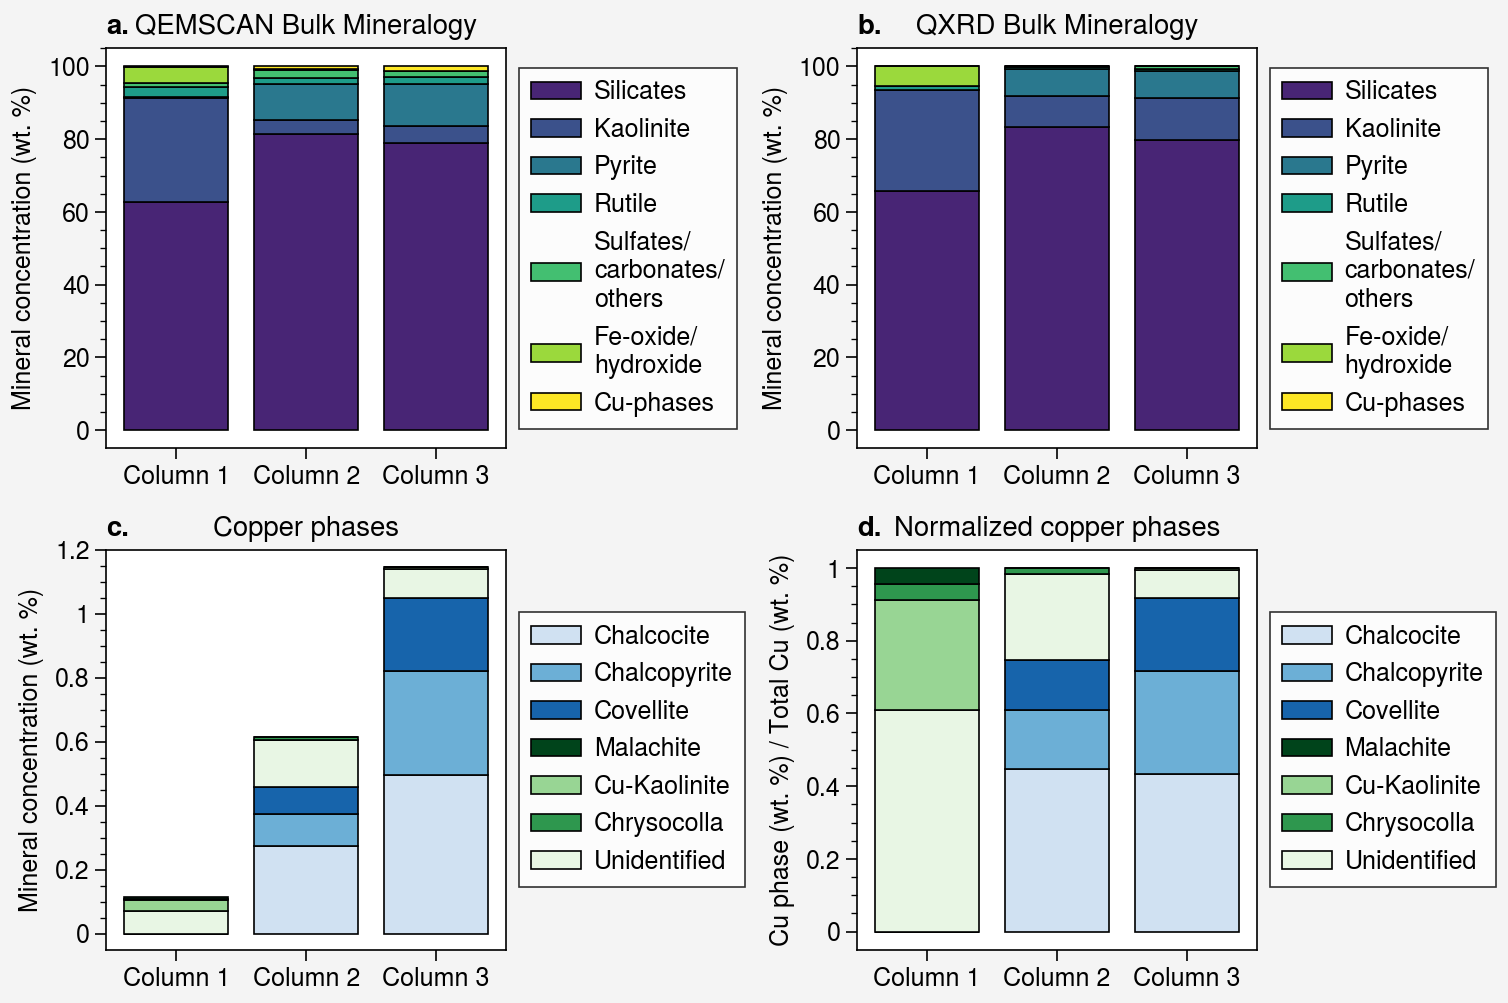

In [119]:
import proplot as pplt
import numpy as np

cycle = pplt.Cycle('viridis', 7, left = 0.1)
fig = pplt.figure(refwidth=2, share = False)
axs = fig.subplots(nrows=2, ncols=2)

axs[0].bar(qemscanUnmeltedAll, stack=True, cycle=cycle, edgecolor='k')
axs[0].format(title='QEMSCAN Bulk Mineralogy')
axs[0].legend(ncols=1,loc = 'r')
axs[0].format(ylabel = 'Mineral concentration (wt. %)', ylim = [-5,105])

axs[1].bar(qxrdUnmeltedAll, stack=True, cycle=cycle, edgecolor='k')
axs[1].format(title='QXRD Bulk Mineralogy')
axs[1].legend(ncols=1,loc = 'r')
axs[1].format(ylabel = 'Mineral concentration (wt. %)',ylim = [-5,105])
# handles, labels = axs[1].get_legend_handles_labels()
# myorder = [0, 1, 2, 4, 5, 3, 6]
# labels = [labels[i] for i in myorder]
# handles = [handles[i] for i in myorder]
# axs[1].legend(handles, labels, ncols=1,loc = 'r')

cycle = pplt.Cycle('blues', 'greens', 7, left = 0.1) 
axs[2].bar(qemscanUnmeltedCu, stack=True, cycle=cycle, edgecolor='k')
axs[2].format(title='Copper phases')
handles, labels = axs[2].get_legend_handles_labels()
myorder = [0, 1, 2, 6, 4, 5, 3]
labels = [labels[i] for i in myorder]
handles = [handles[i] for i in myorder]
axs[2].legend(handles, labels, ncols=1,loc = 'r')
axs[2].format(ylabel = 'Mineral concentration (wt. %)', ylim = [-0.05,1.2])

axs[3].bar(qemscanUnmeltedCuNorm, stack=True, cycle=cycle, edgecolor='k')
axs[3].format(title='Normalized copper phases')

handles, labels = axs[3].get_legend_handles_labels()
myorder = [0 ,1, 2, -1, 4, 5, 3]
labels = [labels[i] for i in myorder]
handles = [handles[i] for i in myorder]
axs[3].legend(handles,labels, ncols=1,loc = 'r')
axs[3].format(ylabel = 'Cu phase (wt. %) / Total Cu (wt. %)', ylim = [-0.05,1.05])

axs.format( 
            grid=False, xlabel='',
            suptitle='',
            # toplabels= toplabels,
            # leftlabels=leftlabels,
            abc='a.', abcloc='l', abcbbox = False,
    )
fig.save('./output/plots/paper/qemscan.pdf')

### SEM-EDS Pyrite 

In [30]:
# import glob
# import os
# import numpy as np
# import pandas as pd
# from PIL import Image, ImageFilter, ImageEnhance

# list_SEM = glob.glob('./input/SEM/py/*/'+'*')
# list_SEM
# vars = ['Ni', 'Co', '']
# ims_dic = {o: {i:list() for i in vars} for o in cols}


# for image in list_SEM:
#     # print(image.split('.')[2])
#     print('Reading image: ' + image.rstrip('.txt').lstrip('./input/SEM/py/'))
#     if image.split('.')[2] == 'txt':
#         im = np.loadtxt(image, dtype=str, delimiter = ';')
#         print('size of im :' + str(im.shape))
#         try:
#             im = im.astype('float')
#         except:
#             im = im[:,:-1].astype('float')
#     elif image.split('.')[2] == 'tif':
#         im = Image.open(image)
#         print('size of im :' + str(im.size))
#     im = np.array(im) 
#     as_ratio = im.shape[0]/im.shape[1]
#     im_id = os.path.split(image)[-1].split('_')[0]
#     im_elem = os.path.split(image)[-1].split('_')[1].split('.')[0].split('-')[0]
#     ims_dic[im_id][im_elem] = im
#     # print(im_elem, im_id)


NameError: name 'cols' is not defined

## Model Figures    

### Data prep

In [1]:
import os, glob, re
import pandas as pd
import numpy as np
from mol_calc import elements_dict

########################################################################################################
### Columns properties
########################################################################################################

CuMass = {
	1	: 0.07835,
	2	: 0.05481,
	3	: 0.27213,
	4	: 0.09413,
	5 	: 0.07933,
	6 	: 0.03847
}

totPoro = {
	1	: 0.46,
	2	: 0.41,
	3	: 0.45,
	4	: 0.40,
	5	: 0.46,
	6	: 0.52,
}

flowRateL = {
	1	: 0.2134,
	2	: 0.2207,
	3	: 0.1961,
	4	: 0.2242,
	5	: 0.216,
	6	: 0.216,
}
totalPV = {
	1	: 56.11793815,
	2	: 89.8222941,
	3	: 101.0909204,
	4	: 111.7153846,
	5	: 15.08254946,
	6	: 18.619,
}
totalTime = {
	1	: 2064,
	2	: 2352,
	3	: 3469,
	4	: 3001,
	5	: 553,
	6	: 384,
}

mobPoroFrac = {
    1	: 0.9,
	2	: 0.9,
	3	: 0.9,
	4	: 0.9,
	5	: 0.9,
	6	: 0.9,
}
stColor = {
	'stage 0' : '#e6fffd',
	'stage 1' : '#b0e8b8',
	'stage 2' : '#F6DCA9',
	'stage 3' : '#F6C0A9'
}

######################################################################################################## 
#### Read observation data
######################################################################################################## 

# column data includes cu recovery (from AAS), pore volume exchange, and measured parameters
column_data = pd.read_excel('./input/columns_master.xlsx', sheet_name = 'column_data')

#solution_icp includes icp data for elements (including copper)
solution_icp = pd.read_excel('./input/columns_master.xlsx', sheet_name = 'solution_icp', header=2)
solution_icp[solution_icp._get_numeric_data()<0] = np.nan #bdl to nan
solution_icp = solution_icp.replace('<', '', regex=True)

summary = column_data.groupby('column').describe().T
# summary.to_csv('./output/dataframes/colmun_summary.csv')

alldata =pd.merge(column_data, solution_icp, how='outer')
# alldata.to_csv('./output/dataframes/kapunda.csv')

######################################################################################################## 
#### Data processing
########################################################################################################

alldata_melted = pd.melt(alldata, id_vars =['column', 'column_name','elapsed_time_h','date',
	'date_time','time','volume_cumulative_sample_pv'])
# print(pd.unique(alldata_melted.variable))

no_plot = ['mass_sample_g', 'stages',
       'density_sample_gm/L', 'volume_sample_mL',
       'volume_solution_container_mL', 'flowrate_mL/h',
       'volume_sample_pv', 'column_pressure',
       'mass_solution_container_g' ,'volume_cumulative_sample_mL',
       'Au_ug/L', 'Ag_ug/L', 
       'Ba_mg/L', 
       'Be_mg/L',
       'Bi_mg/L', 
       'Cd_mg/L', 'Ce_ug/L',  'Cs_ug/L', 
       'Dy_ug/L',
       'Er_ug/L', 'Eu_ug/L', 'Ga_mg/L', 'Gd_mg/L', 'Hf_mg/L', 'Ho_ug/L', 'In_ug/L',
       'La_ug/L', 
       'Lu_ug/L',  'Nd_ug/L',  
       'Pr_ug/L', 'Rb_ug/L', 'Sb_ug/L', 'Se_mg/L', 'Sm_ug/L', 'Sn_mg/L', 'Sr_mg/L',
       'Tb_ug/L', 'Te_mg/L', 'Th_ug/L', 'Tl_ug/L', 'Tm_ug/L', 'U_mg/L', 'Y_ug/L',
       'Yb_ug/L', 'Zr_mg/L', 'B_mg/L', 
       'Cr_mg/L', 
       'Pb_mg/L',
       'Ti_mg/L', 
       'V_mg/L', 'Cu from AA (mg/L) new site water','Cu_extracted_g' ,'Cu_cumulative_g','Cu_mg/L',
       'As_mg/L', 'Li_mg/L', 
       # 'Mn_mg/L', 
       'Mo_mg/L', 
       # 'Co_mg/L'
       ]
alldata_melted_selection = alldata_melted[np.logical_not(alldata_melted['variable'].isin(no_plot))]
alldata_melted_selection = alldata_melted_selection.drop(columns = ['date', 'date_time','time'])
alldata_melted_selection['value'] = alldata_melted_selection['value'].astype('float')
alldata_melted_selection = alldata_melted_selection.dropna()

alldata_melted_selection['value_g'] = np.where(alldata_melted_selection['variable'].str.contains('mg/L'), 
       alldata_melted_selection['value']/1000,
       np.where(alldata_melted_selection['variable'].str.contains('ug/L'),
       	alldata_melted_selection['value']/1000000,
       alldata_melted_selection['value']))

alldata_melted_selection['units'] = alldata_melted_selection['variable'].str.split('_',3).str[-1]

alldata_melted_selection['param'] = alldata_melted_selection['variable'].str.split('_',3).str[0]
alldata_melted_selection['comment'] = alldata_melted_selection['variable'].str.split('_',1).str[-1]
alldata_melted_selection['comment'] = np.where(alldata_melted_selection['comment'].str.contains('_'),
                                   alldata_melted_selection['comment'].str.split('_',1).str[0],
                                   ''
                                   )

alldata_melted_selection['cat'] = np.where((alldata_melted_selection['variable'].str.contains('g/L')),
                                   'compo',
                                   'parameter'
                                   )
alldata_melted_selection['mol_mass'] = alldata_melted_selection['param'].map(elements_dict)                                  
alldata_melted_selection['value_mmol'] = np.where(alldata_melted_selection['cat'] == 'compo',
                                   alldata_melted_selection['value_g']/alldata_melted_selection['mol_mass']*1000,
                                   alldata_melted_selection['value'])  
alldata_melted_selection['variable_to_plot'] = np.where(alldata_melted_selection['cat'] == 'compo',
                                   alldata_melted_selection['param'] +' mmol/L '+ 
                                   alldata_melted_selection['comment'],
                                   alldata_melted_selection['param']+ ' ' 
                                   +alldata_melted_selection['units'])
alldata_melted_selection['variable_to_plot'] = alldata_melted_selection['variable_to_plot'].str.rstrip()
alldata_melted_selection['variable_to_plot'] =  np.where(alldata_melted_selection['variable_to_plot'] == 'Cu mmol/L AA', 
	'Cu mmol/L', alldata_melted_selection['variable_to_plot'])
alldata_melted_selection['obs_volume_cumulative_sample_pv'] = alldata_melted_selection['volume_cumulative_sample_pv'] 
alldata_melted_selection['toPV'] = alldata_melted_selection['column'].map(totalPV)
alldata_melted_selection['toTime'] = alldata_melted_selection['column'].map(totalTime)
alldata_melted_selection['volume_cumulative_sample_pv'] = alldata_melted_selection['elapsed_time_h']/alldata_melted_selection['toTime']*alldata_melted_selection['toPV'] 
alldata_melted_selection = alldata_melted_selection[alldata_melted_selection['elapsed_time_h']!= 0]

# print(pd.unique(alldata_melted_selection.variable_to_plot))
# alldata_melted_selection.to_csv('./output/dataframes/kapunda_melted_selected.csv')

######################################################################################################## 
### Reads data for different experimental stages (I ended up doing this by hand...way easier)
########################################################################################################

stages = pd.read_excel('./input/columns_master.xlsx', sheet_name = 'stages')
stages = stages.replace(np.nan, np.inf)
stages = stages.replace(-1, np.nan)

######################################################################################################## 
### Reads new site water inflow time step
########################################################################################################
sw_inflow  = pd.read_excel('./input/columns_master.xlsx', sheet_name = 'new_sw_inflow')


########################################################################################################
### Read all model outputs, add column identificator and save in list
########################################################################################################

cd = './input/models/'
dfList = []

for root, dirs, files in os.walk(cd):
    for fname in files:
        if re.match("^.*.csv$", fname):
            # print('root: ', root, 'dirs: ', dirs, 'files: ', files)
            print(os.path.split(root)[0].split('/')[-1])
            tmpdf = pd.read_csv(os.path.join(root, fname), sep = '\t', skipinitialspace = True)
            tmpdf = tmpdf.iloc[: , :-1]
            tmpdf['column'] = int(root[-1:])
            tmpdf['model'] = str(os.path.split(root)[0].split('/')[-1])
            dfList.append(tmpdf)

########################################################################################################
### Check if dfs have the same columns
########################################################################################################

if all([set(dfList[0].columns) == set(df.columns) for df in dfList]):
    print('All dfs have the same columns')
else:
    print('Some dfs have different columns')

########################################################################################################
### Concatenate dfs
########################################################################################################

model_result_df = pd.concat(dfList)

########################################################################################################
### Data transformations with constant values
########################################################################################################

model_result_df = model_result_df.melt(id_vars=['elapsed_time_d', 'cell', 'column', 'model'], var_name ='param')
model_result_df.loc[:,'value'] = np.where(model_result_df['param'] == 'pe', model_result_df['value']*0.059*1000-200, model_result_df['value'])
model_result_df.loc[:, 'param'] = np.where(model_result_df['param'] == 'pe', 'Eh', model_result_df['param'])
model_result_df.loc[:, 'units'] = np.where( (model_result_df['param'] == 'Eh'), 'mV', 
                            np.where( (model_result_df['param'] == 'pH'), '', 'mmol/L'
                            ))
model_result_df.loc[:, 'units'] =  np.where(model_result_df['param'].str.contains('SI_'), '', model_result_df['units'])
model_result_df.loc[:, 'type'] =  np.where(model_result_df['param'].str.contains('SI_'), 'Saturation index', 'Dissolved concentration')
model_result_df.loc[:, 'type'] =  np.where(model_result_df['param'].str.contains('Min_'), 'Mineral concentration', model_result_df['type'])
model_result_df.loc[:, 'value'] = np.where(model_result_df['units'] == 'mmol/L', model_result_df['value'] *1000 ,model_result_df['value'] )

########################################################################################################
### Collect data from models/columns, save them as dics and map them to the df
########################################################################################################

n_cols = pd.unique(model_result_df['column']).astype('int')
lastcell = model_result_df.groupby(['column'])['cell'].max()

mobPoroDic = {}
immPoroDic = {}
lastCellDic = {}
lastAdvCellDic = {}
nsw_tstep = {}
nsw_pv = {}

for col in n_cols:
    mobPoro = totPoro[col]*mobPoroFrac[col]
    immPoro = totPoro[col]*(1-mobPoroFrac[col])
    mobPoroDic[col] = mobPoro
    immPoroDic[col] = immPoro
    lastCellDic[col] = lastcell[col]
    lastAdvCellDic[col] = (lastcell[col]-1)/2
    nsw_tstep[col] = sw_inflow.loc[sw_inflow['column'] == int(col), 'elapsed_time_d'].iloc[0]
    nsw_pv[col] = sw_inflow.loc[sw_inflow['column'] == int(col), 'cumulative_sample_volume_pv'].iloc[0]

model_result_df['mobPoro'] = model_result_df['column'].map(mobPoroDic)
model_result_df['immPoro'] = model_result_df['column'].map(immPoroDic)
model_result_df['lastAdvCell'] = model_result_df['column'].map(lastAdvCellDic)
model_result_df['flowRateL'] = model_result_df['column'].map(flowRateL)
model_result_df['totCu'] = model_result_df['column'].map(CuMass)
model_result_df['toPV'] = model_result_df['column'].map(totalPV)
model_result_df['toTime'] = model_result_df['column'].map(totalTime)
model_result_df['colLength'] = model_result_df['column'].map(lastAdvCellDic)*0.01
model_result_df['nsw_tstep'] = model_result_df['column'].map(nsw_tstep)
model_result_df['nsw_pv'] = model_result_df['column'].map(nsw_pv)

tstp = 	np.gradient(pd.unique(model_result_df['elapsed_time_d']))[0]

########################################################################################################
### Transform df using the collected data
########################################################################################################

model_result_df.loc[:, 'cell_type'] = np.where(model_result_df['cell'] <= model_result_df['lastAdvCell'], 'adv' , 'diff' )
model_result_df.loc[:, 'value'] = np.where((model_result_df['param'].str.contains('Min_')) & (model_result_df['cell_type'] == 'adv'), 
                                    model_result_df['value'] *model_result_df['mobPoro'] ,
                                    model_result_df['value'] )
model_result_df.loc[:, 'value'] = np.where((model_result_df['param'].str.contains('Min_')) & (model_result_df['cell_type'] == 'diff'), 
                                    model_result_df['value'] *model_result_df['immPoro']  ,
                                    model_result_df['value'] )
                                
########################################################################################################
### Total Copper Recovery calculations 
########################################################################################################

Cu_recovered = model_result_df[(model_result_df['param'] == 'Cu') & (model_result_df['cell'] == model_result_df['lastAdvCell'] )].copy()
Cu_recovered.loc[:,'value'] = np.where(Cu_recovered['elapsed_time_d'] >= Cu_recovered['nsw_tstep'], Cu_recovered['value']-1.5, #check this number 
                                Cu_recovered['value']-0.0063)
Cu_recovered.loc[:,'value'] = Cu_recovered['value']*Cu_recovered['flowRateL']*tstp # converts concentration to total mass of copper 
Cu_recovered.loc[:,'value'] = Cu_recovered['value']/1000 # convert from mmol to mol
Cu_recovered.loc[:,'value'] = Cu_recovered.groupby(['column','model']).cumsum()
Cu_recovered.loc[:,'value'] = Cu_recovered['value']/model_result_df['totCu']*100 #Get percentage respect to initial mass of copper
Cu_recovered.loc[:,'param'] = 'Cu'
Cu_recovered.loc[:,'units'] = '%'

model_result_df =  model_result_df.append(Cu_recovered)
model_result_df.loc[:,'variable_to_plot'] = np.where(model_result_df['param'] == 'pH', model_result_df['param'],
													 model_result_df['param'] + ' ' + model_result_df['units'])
model_result_df.loc[:,'volume_cumulative_sample_pv'] = model_result_df['elapsed_time_d']*24*model_result_df['toPV']/model_result_df['toTime']
model_result_df = model_result_df.rename(columns = {'value':'value_mmol'})
model_result_df = model_result_df.drop_duplicates()

data = alldata_melted_selection[['column','variable_to_plot','volume_cumulative_sample_pv', 'value_mmol', 
								'param', 'units']].copy()
data.loc[:,'cat'] = 'data'
data.loc[:,'type'] = 'Dissolved concentration' 

model = model_result_df.copy()
model.loc[:,'cat'] = 'sim'
model = model.reindex(sorted(model.columns), axis = 1)
model.loc[:,'variable_to_plot'] = model.variable_to_plot.str.strip()
data.head()

complete
complete
complete
nojaro
nojaro
nojaro
sd
sd
sd
All dfs have the same columns


column variable_to_plot  volume_cumulative_sample_pv  value_mmol param  \
10061       1               pH                     0.326267        4.06    pH   
10062       1               pH                     0.652534        4.06    pH   
10063       1               pH                     0.978801        4.05    pH   
10064       1               pH                     1.305068        4.19    pH   
10065       1               pH                     1.631335        4.38    pH   

      units   cat                     type  
10061        data  Dissolved concentration  
10062        data  Dissolved concentration  
10063        data  Dissolved concentration  
10064        data  Dissolved concentration  
10065        data  Dissolved concentration

In [2]:
model_result_df['normPV'] = model_result_df['volume_cumulative_sample_pv']/model_result_df['toPV']
model_result_df.tail()

elapsed_time_d  cell  column model param  value_mmol units  \
3284450           124.6  29.0       4    sd    Cu   54.882263     %   
3284508           124.7  29.0       4    sd    Cu   54.925502     %   
3284566           124.8  29.0       4    sd    Cu   54.968653     %   
3284624           124.9  29.0       4    sd    Cu   55.011719     %   
3284682           125.0  29.0       4    sd    Cu   55.054696     %   

                            type  mobPoro  immPoro  ...    totCu        toPV  \
3284450  Dissolved concentration     0.36     0.04  ...  0.09413  111.715385   
3284508  Dissolved concentration     0.36     0.04  ...  0.09413  111.715385   
3284566  Dissolved concentration     0.36     0.04  ...  0.09413  111.715385   
3284624  Dissolved concentration     0.36     0.04  ...  0.09413  111.715385   
3284682  Dissolved concentration     0.36     0.04  ...  0.09413  111.715385   

         toTime  colLength  nsw_tstep    nsw_pv  cell_type  variable_to_plot  \
3284450    3001       0.29       73.0  63.52915        adv              Cu %   
3284508    3001       0.29       73.0  63.52915        adv              Cu %   
3284566    3001       0.29       73.0  63.52915        adv              Cu %   
3284624    3001       0.29       73.0  63.52915        adv              Cu %   
3284682    3001       0.29       73.0  63.52915        adv              Cu %   

        volume_cumulative_sample_pv    normPV  
3284450                  111.320788  0.996468  
3284508                  111.410131  0.997268  
3284566                  111.499473  0.998067  
3284624                  111.588816  0.998867  
3284682                  111.678159  0.999667  

[5 rows x 22 columns]

In [3]:
data.groupby(['column', 'variable_to_plot']).describe().to_csv('output/dataframes/data_summary.csv')

### Calibration Figures

#### Cu, Fe, pH and Eh

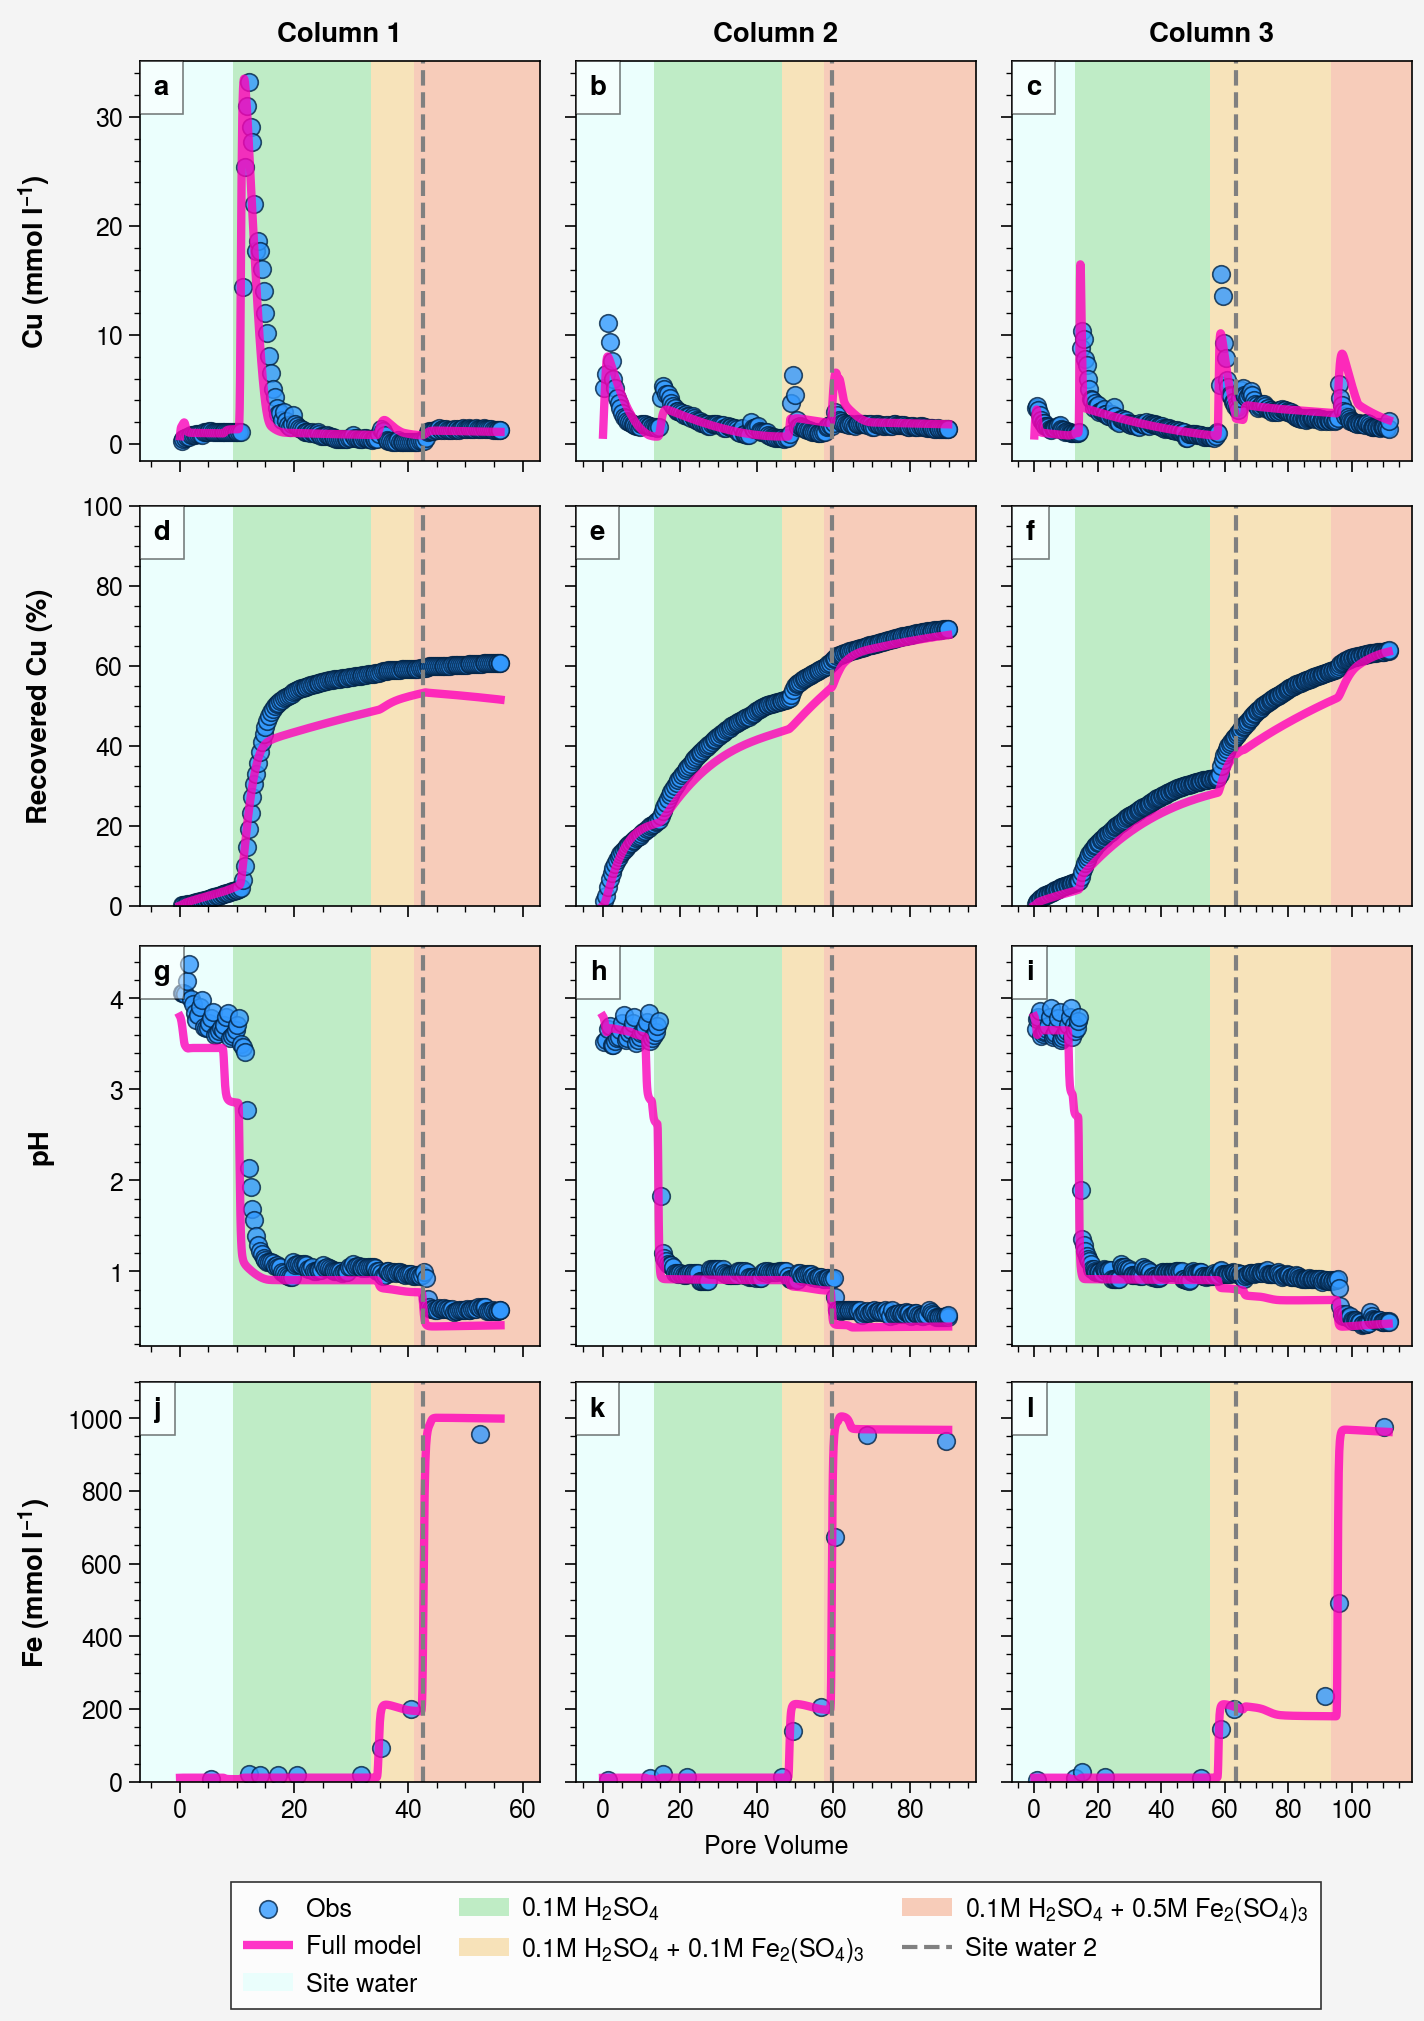

In [15]:
import proplot as pplt
import numpy as np

vartoplot = ['pH', 'Cu mmol/L', 'Cu %', 'Fe mmol/L']
myorder = [1, 2, 0, 3]
vartoplot = [vartoplot[i] for i in myorder]
ncols = len(n_cols)
nrows = len(vartoplot)

cols = (list(n_cols)*nrows)

vars = sorted(vartoplot*ncols,key=vartoplot.index)

fig = pplt.figure(refwidth=2, sharey = True)
axs = fig.subplots(nrows=nrows, ncols=ncols)

toplabels = ['Column '+ str(s) for s in list(n_cols)]
toplabels[2] = 'Column 3' #changes column 4 to column 3. col3 not to be reported in paper in paper
leftlabels=['pH', 'Cu (mmol l$^{-1}$)', 'Recovered Cu (%)', 'Fe (mmol l$^{-1}$)','Eh (mV)']
leftlabels = [leftlabels[i] for i in myorder]

for ax, var, col in zip(axs, vars, cols):
    x_int = 14
    toPV = totalPV[(col)]
    nsw_pv = sw_inflow.loc[sw_inflow['column'] == int(col), 'cumulative_sample_volume_pv'].iloc[0]
    for stage in pd.unique(stages['stage']):
        xticks = np.arange(0,round(toPV),x_int)
        st = stages[stages['column'] == int(col)].dropna().copy()
        st.replace([np.inf, -np.inf], round(toPV) + x_int,inplace=True)
        st.replace([0], -x_int,inplace=True)
        if ~st['stage'].str.contains(stage).any():
            break
        tmp_st = st[st['stage'] == stage].copy()
        # print(tmp_st['pv_start'].item())
        ax.axvspan(tmp_st['pv_start'].item(), tmp_st['pv_end'].item(), facecolor=stColor[stage], alpha=0.8,zorder=0, label = tmp_st['value_str'].item())
    sim = model[(model['variable_to_plot'] == var) & (model['column'] == col) & (model['cell'] == model['lastAdvCell'])& (model['model'] == 'complete')]
    sim2 = model[(model['variable_to_plot'] == var) & (model['column'] == col) & (model['cell'] == model['lastAdvCell'])& (model['model'] == 'sd')]
    obs = data[(data['variable_to_plot'] == var) & (data['column'] == int(col))]
    ax.scatter(obs['volume_cumulative_sample_pv'] ,obs['value_mmol'], s=40, marker='o', alpha =0.8, labels='Obs',c = '#3399ff',edgecolors = '#022345')
    ax.plot(sim[['volume_cumulative_sample_pv']] ,sim[['value_mmol']], lw=3., alpha =0.8, labels='Full model', c = '#ff00ba')
    # ax.plot(sim2[['volume_cumulative_sample_pv']] ,sim2[['value_mmol']], lw=2.5, alpha =0.6, labels='Single domain model', c = 'green')
    # y_max =max(sim['value_mmol'].max(), obs['value_mmol'].max())
    # y_lim = round((y_max+2+1)/2)*2
    # print(y_max, y_lim, round(y_max,0))
    ax.axvline(x = nsw_pv, ymin = 0, ymax = 1,
           color = '#808080', linestyle = 'dashed',
           label = 'Site water 2')
    ax.format(xlim = (0-x_int/2, round(toPV)+x_int/2))
handles, labels = axs[0].get_legend_handles_labels()
# print(labels, handles)
myorder = [-1, 0, 2, 3, 4, 5, 1]
# myorder = [7, 0, 1, 3, 4, 5, 6, 2]
labels = [labels[i] for i in myorder]
handles = [handles[i] for i in myorder]
# print(labels, handles)
fig.legend(handles, labels, loc='b', order = 'F', ncols = 3)
axs.format( 
            grid=False, xlabel='Pore Volume', ylabel = '',
            suptitle='',
            toplabels= toplabels,
            leftlabels=leftlabels,
            abc=True, abcloc='ul', abcbbox = True,
            xticks=20, 
            # yticks=5,
    )
# ax.legend(loc='b', ncols=3, center=True)
# axs[0].format(xlim=(0, 60))
axs[vartoplot.index('Cu %')*ncols:vartoplot.index('Cu %')*ncols+ncols].format(ylim=(0, 100))
axs[vartoplot.index('Fe mmol/L')*ncols:vartoplot.index('Fe mmol/L')*ncols+ncols].format(ylim=(0, 1100))
fig.save('./output/plots/paper/calib_main.pdf')
# fig.save('./output/plots/paper/calib_main_sd_added.pdf')

#### Major ions

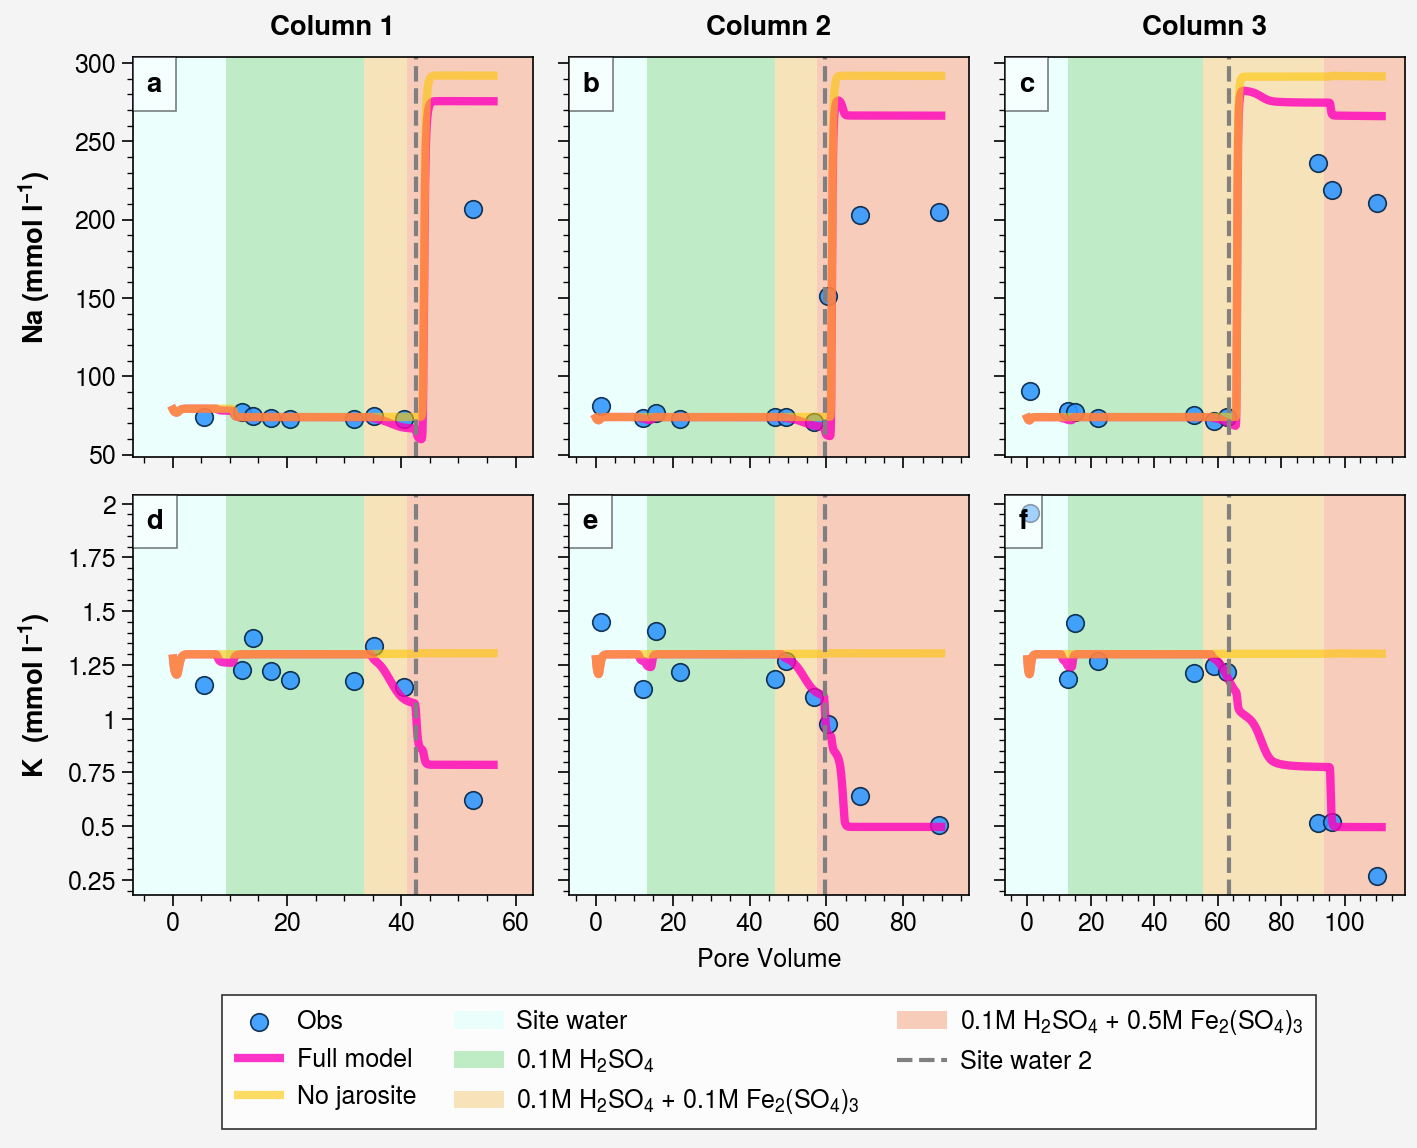

In [10]:
import proplot as pplt
import numpy as np

vartoplot = [ 'Na mmol/L','K mmol/L']
myorder = [0, 1]
vartoplot = [vartoplot[i] for i in myorder]
ncols = len(n_cols)
nrows = len(vartoplot)

cols = (list(n_cols)*nrows)

vars = sorted(vartoplot*ncols,key=vartoplot.index)

fig = pplt.figure(refwidth=2, sharey = True)
axs = fig.subplots(nrows=nrows, ncols=ncols)

toplabels = ['Column '+ str(s) for s in list(n_cols)]
toplabels[2] = 'Column 3' #changes column 4 to column 3. col3 not to be reported in paper in paper
leftlabels=[x[:2] + ' (mmol l$^{-1}$)' for x in vartoplot] #'(mmol l$^{-1}$)'
leftlabels = [leftlabels[i] for i in myorder]

# print(leftlabels)

for ax, var, col in zip(axs, vars, cols):
    x_int = 14
    toPV = totalPV[(col)]
    nsw_pv = sw_inflow.loc[sw_inflow['column'] == int(col), 'cumulative_sample_volume_pv'].iloc[0]
    for stage in pd.unique(stages['stage']):
        xticks = np.arange(0,round(toPV),x_int)
        st = stages[stages['column'] == int(col)].dropna().copy()
        st.replace([np.inf, -np.inf], round(toPV) + x_int,inplace=True)
        st.replace([0], -x_int,inplace=True)
        if ~st['stage'].str.contains(stage).any():
            break
        tmp_st = st[st['stage'] == stage].copy()
        # print(tmp_st['pv_start'].item())
        ax.axvspan(tmp_st['pv_start'].item(), tmp_st['pv_end'].item(), facecolor=stColor[stage], alpha=0.8,zorder=0, label = tmp_st['value_str'].item())
    sim = model[(model['variable_to_plot'] == var) & (model['column'] == col) & (model['cell'] == model['lastAdvCell'])& (model['model'] == 'complete')]
    sim_nojaro = model[(model['variable_to_plot'] == var) & (model['column'] == col) & (model['cell'] == model['lastAdvCell'])& (model['model'] == 'nojaro')]
    obs = data[(data['variable_to_plot'] == var) & (data['column'] == int(col))]
    ax.scatter(obs['volume_cumulative_sample_pv'] ,obs['value_mmol'], s=40, marker='o', alpha =0.9, labels='Obs',c = '#3399ff',edgecolors = '#022345')
    ax.plot(sim[['volume_cumulative_sample_pv']] ,sim[['value_mmol']], lw=3., alpha =0.8, labels='Full model', c = '#ff00ba')
    ax.plot(sim_nojaro[['volume_cumulative_sample_pv']] ,sim_nojaro[['value_mmol']], lw=3., alpha =0.6, labels='No jarosite', c = '#ffc500')
    # y_max =max(sim['value_mmol'].max(), obs['value_mmol'].max())
    # y_lim = round((y_max+2+1)/2)*2
    # print(y_max, y_lim, round(y_max,0))
    ax.axvline(x = nsw_pv, ymin = 0, ymax = 1,
           color = '#808080', linestyle = 'dashed',
           label = 'Site water 2')
    ax.format(xlim = (0-x_int/2, round(toPV)+x_int/2))
handles, labels = axs[0].get_legend_handles_labels()

# myorder = [-1, 0, 2, 3, 4, 5, 1]
myorder = [7, 0, 1, 3, 4, 5, 6, 2]
labels = [labels[i] for i in myorder]
handles = [handles[i] for i in myorder]

# print(labels, handles)
fig.legend(handles, labels, loc='b', order = 'F', ncols = 3)
axs.format( 
            grid=False, xlabel='Pore Volume', ylabel = '',
            suptitle='',
            toplabels= toplabels,
            leftlabels=leftlabels,
            abc=True, abcloc='ul', abcbbox = True,
            xticks=20, 
            # yticks=5,
    )

# axs[vartoplot.index('Fe mmol/L')*ncols:vartoplot.index('Fe mmol/L')*ncols+ncols].format(ylim=(0, 1100))
fig.save('./output/plots/paper/calib_major.pdf')

#### Trace metals

['Ni (mmol l$^{-1}$)', 'Mn (mmol l$^{-1}$)', 'Co (mmol l$^{-1}$)']


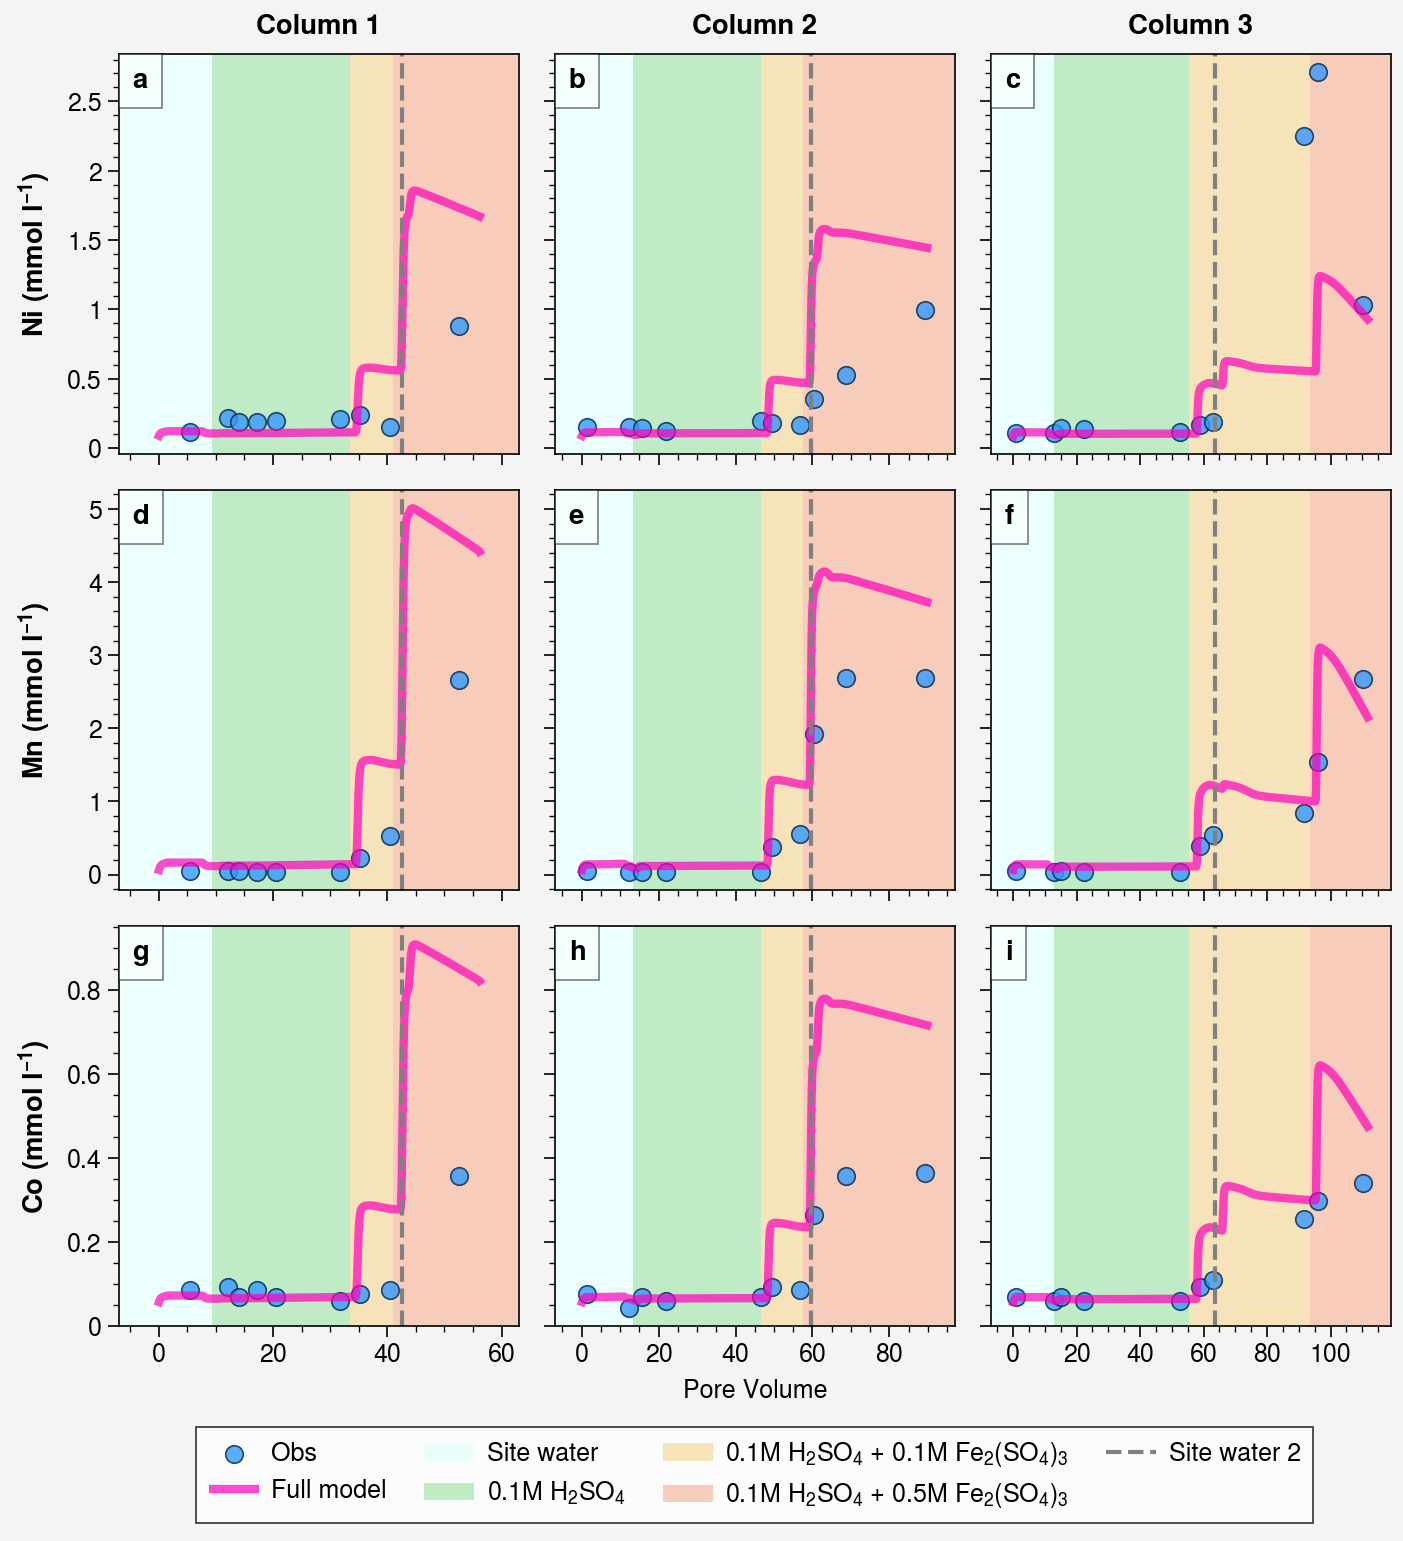

In [13]:
import proplot as pplt
import numpy as np

vartoplot = ['Ni mmol/L','Mn mmol/L', 'Co mmol/L']
myorder = [0, 1, 2]
vartoplot = [vartoplot[i] for i in myorder]
ncols = len(n_cols)
nrows = len(vartoplot)

cols = (list(n_cols)*nrows)

vars = sorted(vartoplot*ncols,key=vartoplot.index)

fig = pplt.figure(refwidth=2, sharey = True)
axs = fig.subplots(nrows=nrows, ncols=ncols)

toplabels = ['Column '+ str(s) for s in list(n_cols)]
toplabels[2] = 'Column 3' #changes column 4 to column 3. col3 not to be reported in paper in paper
leftlabels=[x[:2] + ' (mmol l$^{-1}$)' for x in vartoplot] #'(mmol l$^{-1}$)'
leftlabels = [leftlabels[i] for i in myorder]

print(leftlabels)

for ax, var, col in zip(axs, vars, cols):
    x_int = 14
    toPV = totalPV[(col)]
    nsw_pv = sw_inflow.loc[sw_inflow['column'] == int(col), 'cumulative_sample_volume_pv'].iloc[0]
    for stage in pd.unique(stages['stage']):
        xticks = np.arange(0,round(toPV),x_int)
        st = stages[stages['column'] == int(col)].dropna().copy()
        st.replace([np.inf, -np.inf], round(toPV) + x_int,inplace=True)
        st.replace([0], -x_int,inplace=True)
        if ~st['stage'].str.contains(stage).any():
            break
        tmp_st = st[st['stage'] == stage].copy()
        # print(tmp_st['pv_start'].item())
        ax.axvspan(tmp_st['pv_start'].item(), tmp_st['pv_end'].item(), facecolor=stColor[stage], alpha=0.8,zorder=0, label = tmp_st['value_str'].item())
    sim = model[(model['variable_to_plot'] == var) & (model['column'] == col) & (model['cell'] == model['lastAdvCell'])& (model['model'] == 'complete')]
    obs = data[(data['variable_to_plot'] == var) & (data['column'] == int(col))]
    ax.scatter(obs['volume_cumulative_sample_pv'] ,obs['value_mmol'], s=40, marker='o', alpha =0.8, labels='Obs',c = '#3399ff',edgecolors = '#022345')
    ax.plot(sim[['volume_cumulative_sample_pv']] ,sim[['value_mmol']], lw=3., alpha =0.7, labels='Full model', c = '#ff00ba')
    # y_max =max(sim['value_mmol'].max(), obs['value_mmol'].max())
    # y_lim = round((y_max+2+1)/2)*2
    # print(y_max, y_lim, round(y_max,0))
    ax.axvline(x = nsw_pv, ymin = 0, ymax = 1,
           color = '#808080', linestyle = 'dashed',
           label = 'Site water 2')
    ax.format(xlim = (0-x_int/2, round(toPV)+x_int/2))
handles, labels = axs[0].get_legend_handles_labels()

myorder = [-1, 0, 2, 3, 4, 5, 1]
labels = [labels[i] for i in myorder]
handles = [handles[i] for i in myorder]

# print(labels, handles)
fig.legend(handles, labels, loc='b', order = 'F', ncols = 4)
axs.format( 
            grid=False, xlabel='Pore Volume', ylabel = '',
            suptitle='',
            toplabels= toplabels,
            leftlabels=leftlabels,
            abc=True, abcloc='ul', abcbbox = True,
            xticks=20, 
            # yticks=5,
    )
# axs[vartoplot.index('Fe mmol/L')*ncols:vartoplot.index('Fe mmol/L')*ncols+ncols].format(ylim=(0, 1100))
fig.save('./output/plots/paper/calib_trace.pdf')

### 2D Pixel plots 

#### Copper mineral concentrations

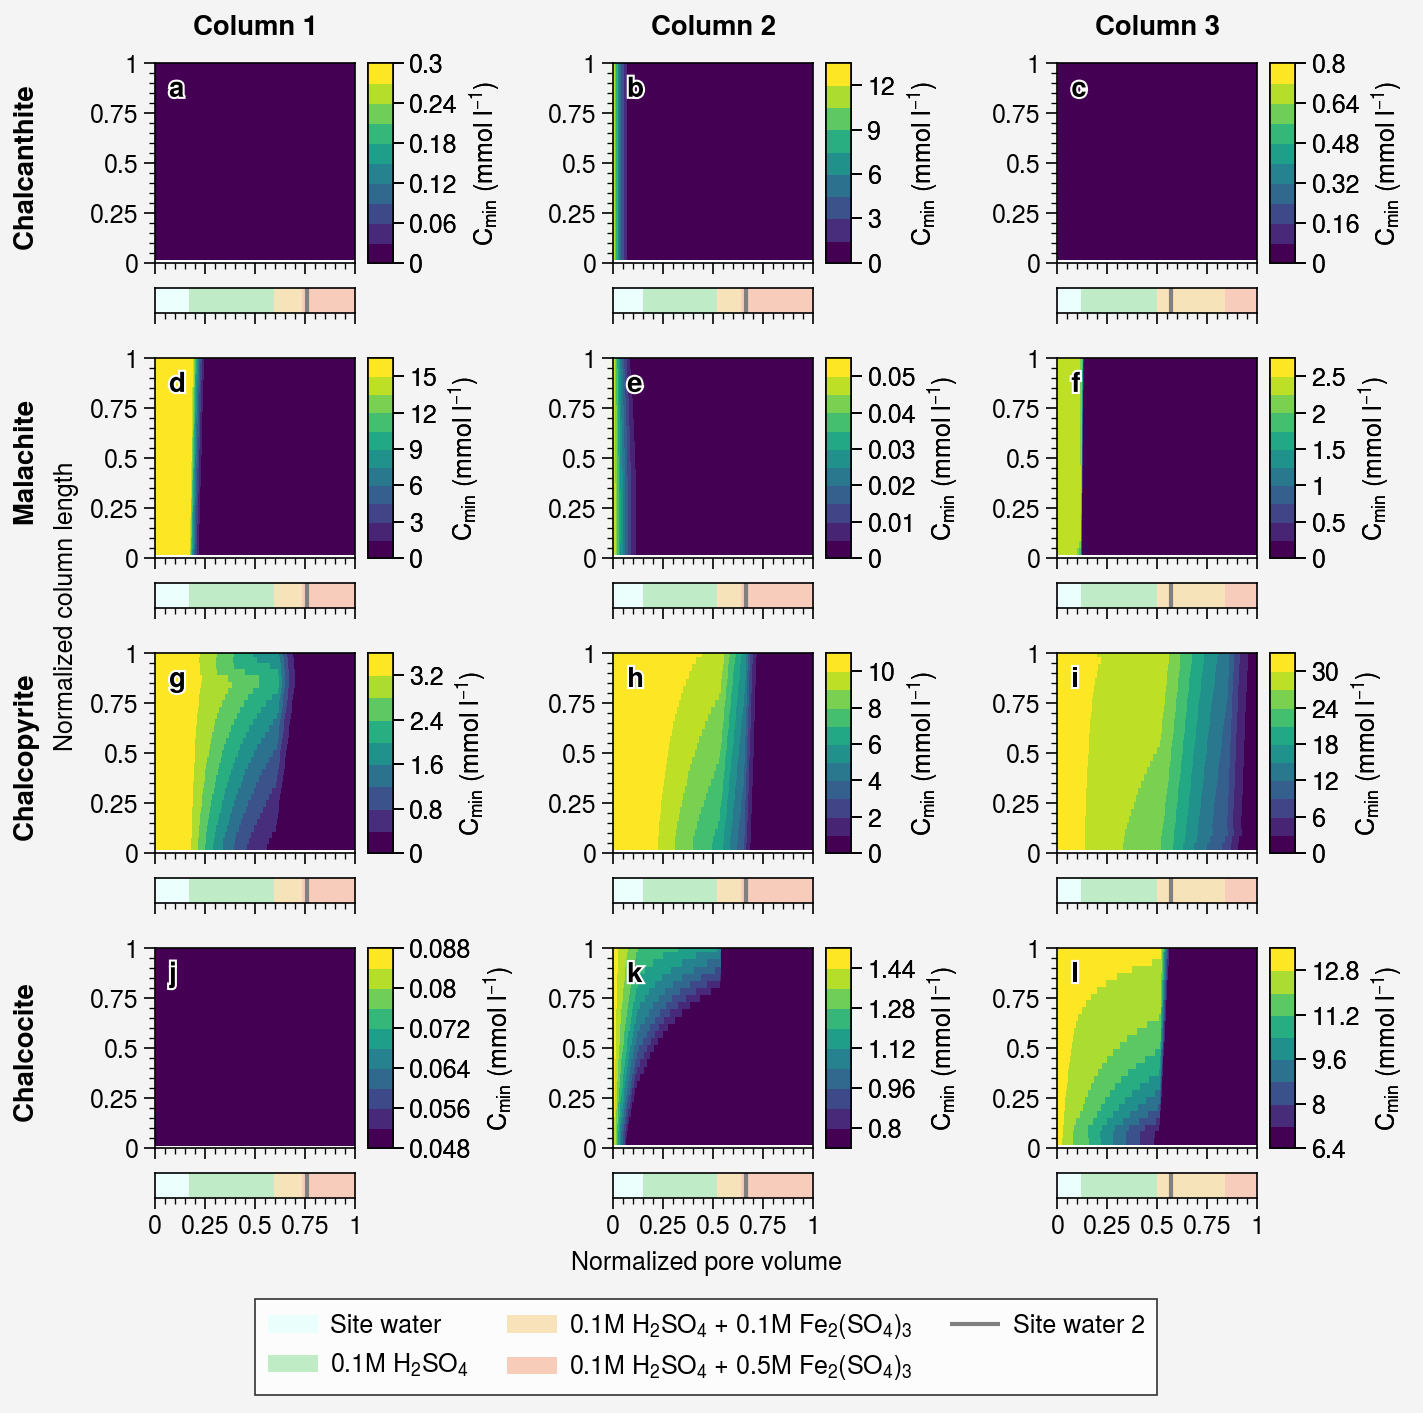

In [38]:
import proplot as pplt
import numpy as np
import matplotlib as mpl


vartoplot = ['Min_Chalcanthite mmol/L', 'Min_Malachite mmol/L', 'Min_Chalcopyrite mmol/L','Min_Chalcocite mmol/L',]
# 'Min_Pyrite mmol/L','Min_Jarosite-Na mmol/L']
myorder = [0, 1, 2, 3]
vartoplot = [vartoplot[i] for i in myorder]
ncols = len(n_cols)
nrows = len(vartoplot)

vars = sorted(vartoplot*ncols,key=vartoplot.index)
cols = (list(n_cols)*nrows)

########################################################################################################
### Transform df of simulated data to matrix
########################################################################################################
model_to_matrix = model_result_df.drop(columns=['elapsed_time_d','param', 'units']).copy() #copy model
model_to_matrix = model_to_matrix.loc[(model_to_matrix.cell_type == 'adv') & (model_to_matrix['model'] == 'complete')]
model_to_matrix = model_to_matrix.loc[~model_to_matrix.variable_to_plot.str.match('Cu %')]
model_to_matrix.variable_to_plot = model_to_matrix.variable_to_plot.str.strip()
model_to_matrix['dist_m'] = model_to_matrix['cell']*0.01 #convert cells to distance in meters (if model domain changes change this value)
model_to_matrix['norm_dist_m'] = model_to_matrix['dist_m']/model_to_matrix['colLength']

prefix = 'Min'
variables =  pd.unique(model_to_matrix['variable_to_plot'])
variables =  [s for s in variables if prefix in s]

arrays_dic = {o: {i:list() for i in vars} for o in cols}

for column, var in zip(cols, vars):
    tmp = model_to_matrix.loc[(model_to_matrix['variable_to_plot']==var) & 
    (model_to_matrix['column']==column)]
    tmp = tmp[['norm_dist_m', 'normPV','value_mmol']]
    # print(tmp['normPV'].max)
    tmp.loc[:,'value_mmol'] = tmp['value_mmol'] 
    tmp_pivoted = tmp.pivot(index = 'norm_dist_m',columns = 'normPV', values = 'value_mmol')
    tmp_matrix = tmp_pivoted.to_numpy()
    tmp_PV = tmp[['normPV']]
    arrays_dic[column][var] = tmp_pivoted

# print(tmp_matrix)

########################################################################################################

fig = pplt.figure(refwidth=1, sharey = 'labels')
axs = fig.subplots(nrows=nrows, ncols=ncols)

toplabels = ['Column '+ str(s) for s in list(n_cols)]
toplabels[2] = 'Column 3' #changes column 4 to column 3. col3 not to be reported in paper in paper
leftlabels=[x[4:-6]  for x in vartoplot] #'(mmol l$^{-1}$)'
leftlabels = [leftlabels[i] for i in myorder]
leftlabels[1] = leftlabels[1].replace('-Na','')

# cmap = mpl.cm.get_cmap('viridis')
# locator = pplt.Locator('linear', 20)
# ax.colorbar(cmap, norm=norm, locator=locator)
formatter=pplt.Formatter('sci')

for ax, var, col in zip(axs, vars, cols):
    toPV = totalPV[col]
    array_to_plot = arrays_dic[col][var]
    array_to_plot.name = 'C$_{min}$ (mmol l$^{-1}$)'
    # vmax = 4
    # vmin = 0
    # c = ax.imshow(array_to_plot, aspect=1, extent = [0,1,0,1], origin = 'lower', 
        # cmap = 'viridis')
    # if var.rsplit('_')[1].startswith('Py'):
    #     norm = mpl.colors.Normalize(vmin=0, vmax=1600)
    # else: 
    #     norm = mpl.colors.Normalize(vmin=0, vmax=6000)
    c = ax.pcolor(array_to_plot, discrete = True, lw=0.7, cmap='viridis',  colorbar_kw={'width': '1em'}, colorbar = 'r')
    # ax.colorbar(c, )
    # c = ax.contourf(array_to_plot, cmap='viridis', colorbar = 'r', discrete = True, lw=0.7)
    #     colorbar='r', colorbar_kw={'title': 'mmol l$^{-1}$'}, extent = [0,1,0,1])
    # clb = ax.colorbar(c, ax=ax)
    # clb.ax.set_title('mmol l$^{-1}$')
pxs = axs.panel('b', space = 1, width='1em')

for px, col in zip(pxs, cols):
    nsw_pv = sw_inflow.loc[sw_inflow['column'] == int(col), 'norm_pv'].iloc[0]
    st = stages[stages['column'] == int(col)].dropna().copy()
    for stage in pd.unique(stages['stage']):
        tmp_st = st[st['stage'] == stage].copy()
        px.axvspan(tmp_st['norm_pv_start'].item(), tmp_st['norm_pv_end'].item(), facecolor=stColor[stage], alpha=0.8,zorder=0, label = tmp_st['value_str'].item())
    px.axvline(x = nsw_pv, ymin = 0, ymax = 1,
           color = '#808080',
           label = 'Site water 2')

handles, labels = pxs[0].get_legend_handles_labels()
# print(labels)
myorder = [1, 2, 3, 4, 0]
labels = [labels[i] for i in myorder]
handles = [handles[i] for i in myorder]
# print(labels)

fig.legend(handles, labels, loc='b', order = 'F', ncols = 3)
axs.format( 
            grid=False, xlabel='Normalized pore volume', 
            ylabel = 'Normalized column length',
            suptitle='',
            toplabels= toplabels,
            leftlabels=leftlabels,
            abc=True, abcloc='ul', abcbbox = False,
            yticks=0.25, 
            xticks=0.25,
            xlim = [0,1],
            ylim = [0,1]
    )
pxs.format( grid=False, ylocator='null')
fig.save('./output/plots/paper/2D_adv_Cumin.pdf')

#### Gangue mineral concentrations

['Min_Pyrite mmol/L', 'Min_Jarosite-Na mmol/L']


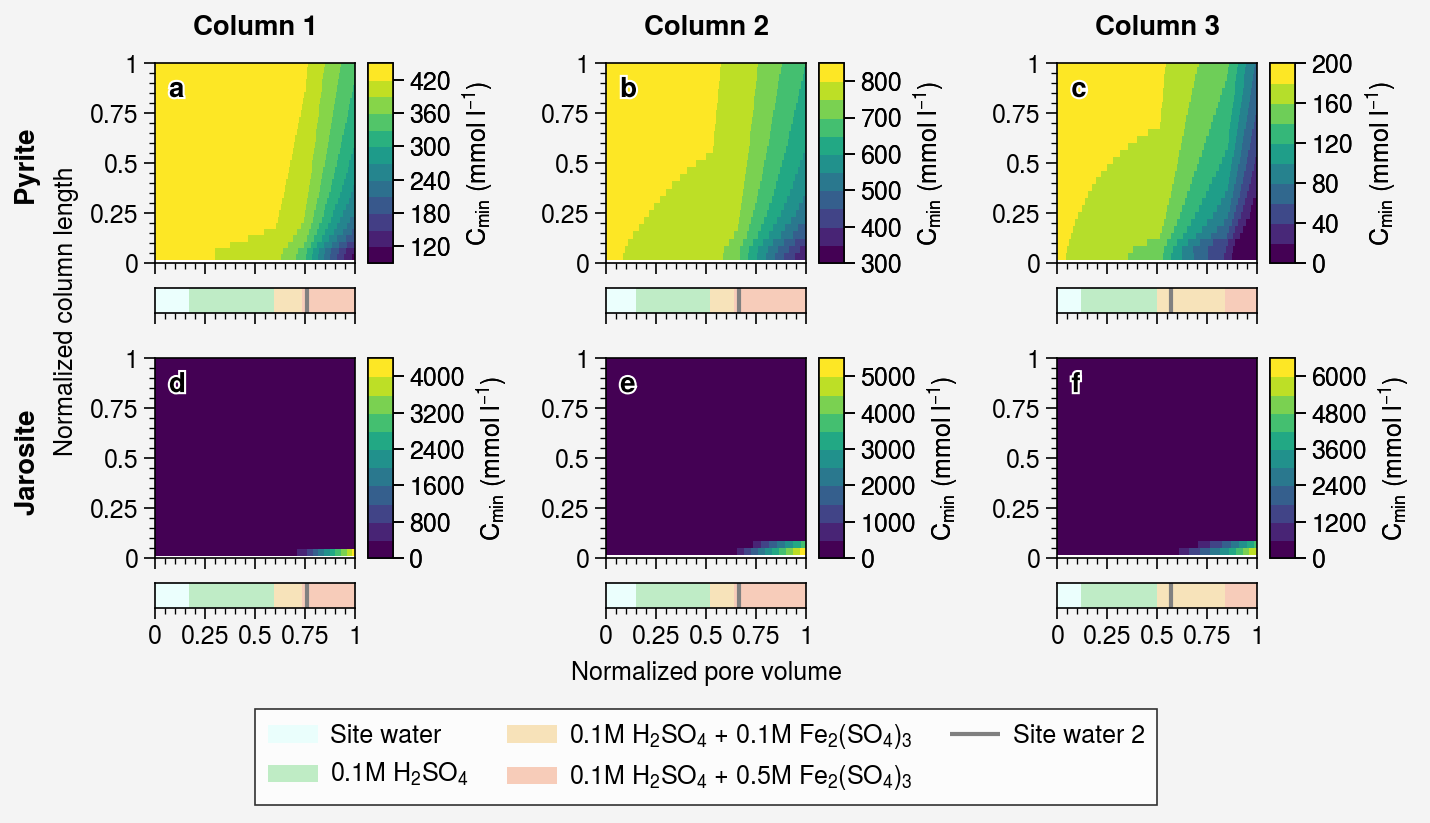

In [39]:
import proplot as pplt
import numpy as np
import matplotlib as mpl


vartoplot = ['Min_Pyrite mmol/L', 'Min_Jarosite-Na mmol/L']
print(vartoplot)
# 'Min_Pyrite mmol/L','Min_Jarosite-Na mmol/L']
myorder = [0, 1]
vartoplot = [vartoplot[i] for i in myorder]
ncols = len(n_cols)
nrows = len(vartoplot)
cols = (list(n_cols)*nrows)
vars = sorted(vartoplot*ncols,key=vartoplot.index)

########################################################################################################
### Transform df of simulated data to matrix
########################################################################################################
model_to_matrix = model_result_df.drop(columns=['elapsed_time_d','param', 'units']).copy() #copy model
model_to_matrix = model_to_matrix.loc[(model_to_matrix.cell_type == 'adv') & (model_to_matrix['model'] == 'complete')]
model_to_matrix = model_to_matrix.loc[~model_to_matrix.variable_to_plot.str.match('Cu %')]
model_to_matrix.variable_to_plot = model_to_matrix.variable_to_plot.str.strip()
model_to_matrix['dist_m'] = model_to_matrix['cell']*0.01 #convert cells to distance in meters (if model domain changes change this value)
model_to_matrix['norm_dist_m'] = model_to_matrix['dist_m']/model_to_matrix['colLength']

prefix = 'Min'
variables =  pd.unique(model_to_matrix['variable_to_plot'])
variables =  [s for s in variables if prefix in s]

arrays_dic = {o: {i:list() for i in vars} for o in cols}

for column, var in zip(cols, vars):
    tmp = model_to_matrix.loc[(model_to_matrix['variable_to_plot']==var) & 
    (model_to_matrix['column']==column)]
    tmp = tmp[['norm_dist_m', 'normPV','value_mmol']]
    # print(tmp['normPV'].max)
    tmp.loc[:,'value_mmol'] = tmp['value_mmol'] 
    tmp_pivoted = tmp.pivot(index = 'norm_dist_m',columns = 'normPV', values = 'value_mmol')
    tmp_matrix = tmp_pivoted.to_numpy()
    tmp_PV = tmp[['normPV']]
    arrays_dic[column][var] = tmp_pivoted

# print(tmp_pivoted.head)

########################################################################################################

fig = pplt.figure(refwidth=1, sharey = 'labels')
axs = fig.subplots(nrows=nrows, ncols=ncols)

toplabels = ['Column '+ str(s) for s in list(n_cols)]
toplabels[2] = 'Column 3' #changes column 4 to column 3. col3 not to be reported in paper in paper
leftlabels=[x[4:-6]  for x in vartoplot] #'(mmol l$^{-1}$)'
leftlabels = [leftlabels[i] for i in myorder]
leftlabels[1] = leftlabels[1].replace('-Na','')

# cmap = mpl.cm.get_cmap('viridis')
# locator = pplt.Locator('linear', 20)
# ax.colorbar(cmap, norm=norm, locator=locator)
# formatter=pplt.Formatter('sci')

for ax, var, col in zip(axs, vars, cols):
    toPV = totalPV[col]
    array_to_plot = arrays_dic[col][var]
    array_to_plot.name = 'C$_{min}$ (mmol l$^{-1}$)'
    # vmax = 4
    # vmin = 0
    # c = ax.imshow(array_to_plot, aspect=1, extent = [0,1,0,1], origin = 'lower', 
        # cmap = 'viridis')
    # if var.rsplit('_')[1].startswith('Py'):
    #     norm = mpl.colors.Normalize(vmin=0, vmax=1600)
    # else: 
    #     norm = mpl.colors.Normalize(vmin=0, vmax=6000)
    c = ax.pcolor(array_to_plot, discrete = True, lw=0.7, cmap='viridis', colorbar_kw={'width': '1em'}, colorbar = 'r')
    # ax.colorbar(c, )
    # c = ax.contourf(array_to_plot, cmap='viridis', colorbar = 'r', discrete = True, lw=0.7)
    #     colorbar='r', colorbar_kw={'title': 'mmol l$^{-1}$'}, extent = [0,1,0,1])
    # clb = ax.colorbar(c, ax=ax)
    # clb.ax.set_title('mmol l$^{-1}$')
pxs = axs.panel('b', space = 1, width='1em')

for px, col in zip(pxs, cols):
    nsw_pv = sw_inflow.loc[sw_inflow['column'] == int(col), 'norm_pv'].iloc[0]
    st = stages[stages['column'] == int(col)].dropna().copy()
    for stage in pd.unique(stages['stage']):
        tmp_st = st[st['stage'] == stage].copy()
        px.axvspan(tmp_st['norm_pv_start'].item(), tmp_st['norm_pv_end'].item(), facecolor=stColor[stage], alpha=0.8,zorder=0, label = tmp_st['value_str'].item())
    px.axvline(x = nsw_pv, ymin = 0, ymax = 1,
           color = '#808080',
           label = 'Site water 2')

handles, labels = pxs[0].get_legend_handles_labels()
# print(labels)
myorder = [1, 2, 3, 4, 0]
labels = [labels[i] for i in myorder]
handles = [handles[i] for i in myorder]
# print(labels)

fig.legend(handles, labels, loc='b', order = 'F', ncols = 3)
axs.format( 
            grid=False, xlabel='Normalized pore volume', 
            ylabel = 'Normalized column length',
            suptitle='',
            toplabels= toplabels,
            leftlabels=leftlabels,
            abc=True, abcloc='ul', abcbbox = False,
            yticks=0.25, 
            xticks=0.25,
            xlim = [0,1],
            ylim = [0,1]
    )
pxs.format( grid=False, ylocator='null')
fig.save('./output/plots/paper/2D_adv_Ganguemin.pdf')

In [40]:
# state = np.random.RandomState(51423)

# data = state.rand(12, 20)
# df = pd.DataFrame(
#     (data - 0.4).cumsum(axis=0).cumsum(axis=1)[::1, ::-1],
#     index=pd.date_range('2000-01', '2000-12', freq='MS'))
# df

### Speciation plot

#### Cu

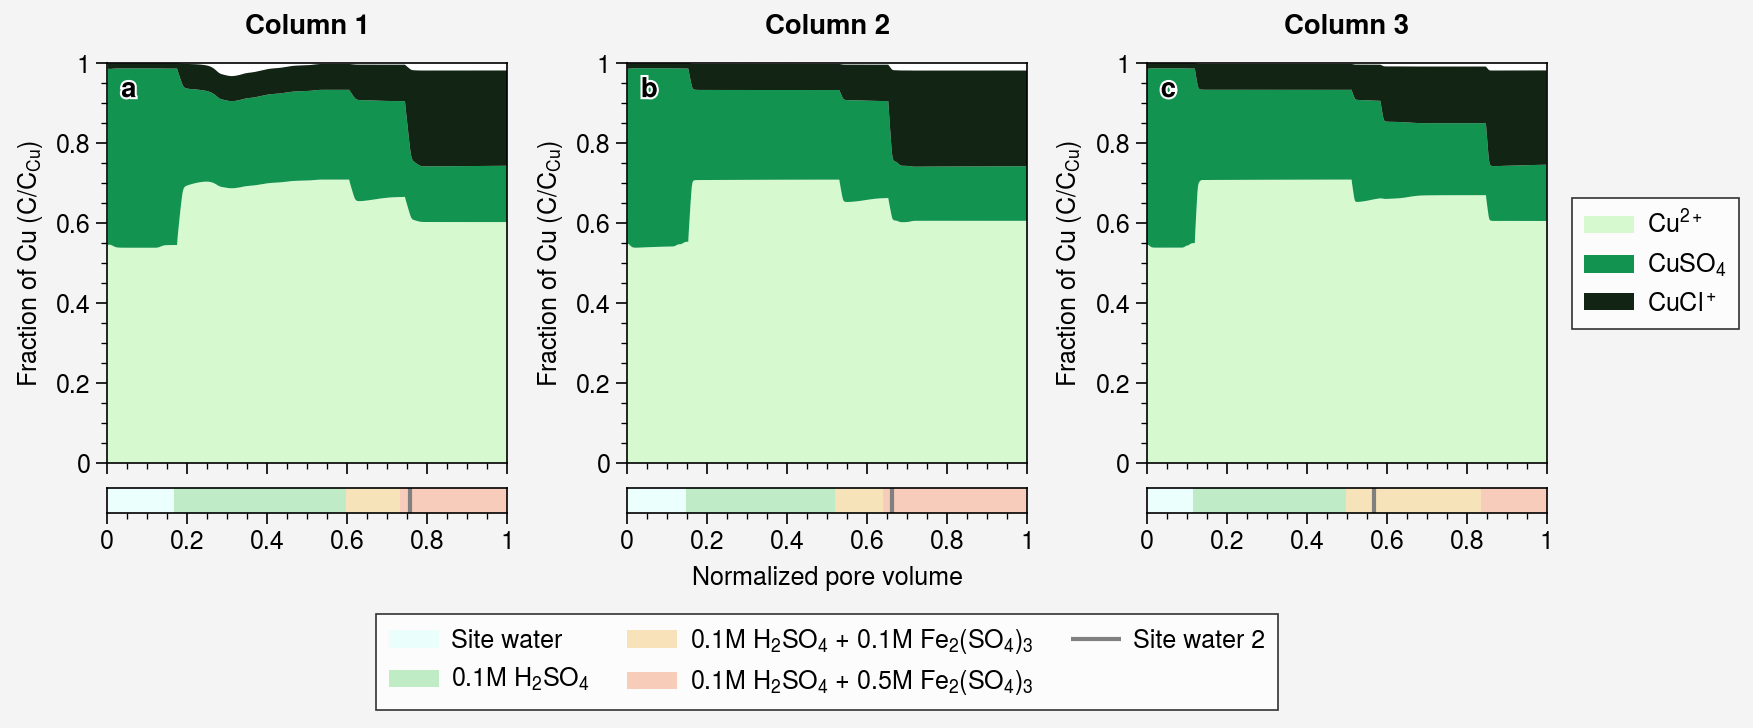

In [41]:
import proplot as pplt
import numpy as np


spCu = model_result_df[((model_result_df['variable_to_plot'].str.startswith('sp_Cu')) | (model_result_df['variable_to_plot'] == 'Cu mmol/L') )
                        & (model_result_df['model'] == 'complete')]

CuSpecies = pd.unique(spCu['variable_to_plot'])
CuSpecies
cnames = spCu.columns
normCuSpecies = pd.DataFrame(columns=cnames)


for sp in CuSpecies:
    tmpSp = spCu[spCu['variable_to_plot'] == sp].copy()
    CuTot = spCu[spCu['variable_to_plot'] == 'Cu mmol/L'].copy()
    if sp != 'Cu mmol/L':
        tmp_arr = tmpSp['value_mmol']/(CuTot['value_mmol'].to_numpy())
        tmpSp.loc[:,'value_mmol'] = tmp_arr
        tmpSp.loc[:, 'variable_to_plot'] = 'norm_'+sp
        normCuSpecies = normCuSpecies.append(tmpSp)

vartoplot = ['norm_sp_Cu2+_mmol/L', 'norm_sp_CuSO4_mmol/L', 'norm_sp_CuCl+_mmol/L'] #'norm_sp_CuCl2-_mmol/L', 'norm_sp_CuCl3-2_mmol/L']
myorder = [0, 1, 2]
vartoplot = [vartoplot[i] for i in myorder]
ncols = len(n_cols)
nrows = 1

cols = (list(n_cols)*ncols)

vars = sorted(vartoplot*ncols,key=vartoplot.index)

fig = pplt.figure(refwidth=2, sharey = False)
axs = fig.subplots(nrows=nrows, ncols=ncols)

toplabels = ['Column '+ str(s) for s in list(n_cols)]
toplabels[2] = 'Column 3' #changes column 4 to column 3. col3 not to be reported in paper in paper

normCuSpecies = normCuSpecies[normCuSpecies['cell_type'] == 'adv']
normCuSpecies.loc[:, 'norm_PV'] = normCuSpecies['volume_cumulative_sample_pv']/normCuSpecies['toPV']
normCuSpecies = normCuSpecies[['norm_PV','elapsed_time_d', 'cell', 'column', 'value_mmol', 'variable_to_plot']]
normCuSpeciesLong = normCuSpecies.pivot(index = ['norm_PV', 'elapsed_time_d', 'cell', 'column'], columns = ['variable_to_plot'],values = 'value_mmol',)
normCuSpeciesLong = normCuSpeciesLong.reset_index(level=[0,1,2,3])
# print(pd.unique(normCuSpecies.columns))

normCuSpeciesLong_mean = normCuSpeciesLong.groupby(by = ['column', 'elapsed_time_d']).mean()
normCuSpeciesLong_mean = normCuSpeciesLong_mean.reset_index(level=[0,1])
# # normCuSpeciesLong_std = normCuSpeciesLong.groupby(by = ['column', 'elapsed_time_d']).std()
# normCuSpeciesLong_mean.head()

for ax, col in zip(axs,  cols):
    sim_mean = normCuSpeciesLong_mean[(normCuSpeciesLong_mean['column'] == col)]
    # sim.loc[:, 'dist_m'] = sim['cell']*0.01
    sim_mean = sim_mean.set_index(['norm_PV'])
    sim_mean = sim_mean[['norm_sp_Cu+2 mmol/L', 'norm_sp_CuSO4 mmol/L', 'norm_sp_CuCl+ mmol/L']] #, 'norm_sp_CuCl2- mmol/L', 'norm_sp_CuCl3-2 mmol/L']]
    # ax.plot(sim_mean, lw=3.5, alpha =0.7)
    ax.area(sim_mean, stack = True, lw=3.5, alpha =1, cycle = 'algae')

pxs = axs.panel('b', space = 1,width='1em')

for px, col in zip(pxs, cols):
    nsw_pv = sw_inflow.loc[sw_inflow['column'] == int(col), 'norm_pv'].iloc[0]
    st = stages[stages['column'] == int(col)].dropna().copy()
    for stage in pd.unique(stages['stage']):
        tmp_st = st[st['stage'] == stage].copy()
        px.axvspan(tmp_st['norm_pv_start'].item(), tmp_st['norm_pv_end'].item(), facecolor=stColor[stage], alpha=0.8,zorder=0, label = tmp_st['value_str'].item())
    px.axvline(x = nsw_pv, ymin = 0, ymax = 1,
           color = '#808080',
           label = 'Site water 2')

leftlabels = ['Cu$^{2+}$', 'CuSO$_4$' ,'CuCl$^+$' ]#,'CuCl$_2^-$', 'CuCl$_3^{2-}$'] 
handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, leftlabels, loc='r', order = 'F', ncols = 1, title= '')

handlespx, labelspx = pxs[0].get_legend_handles_labels()
myorder = [1, 2, 3, 4, 0]
labelspx = [labelspx[i] for i in myorder]
handlespx = [handlespx[i] for i in myorder]

fig.legend(handlespx, labelspx, loc='b', order = 'F', ncols = 3)


axs.format( 
            grid=False, xlabel='Normalized pore volume', 
            ylabel = 'Fraction of Cu (C/C$_{Cu}$)',
            suptitle='',
            toplabels= toplabels,
            #leftlabels=leftlabels,
            abc=True, abcloc='ul', abcbbox = False,
            # xticks=200, 
            # yticks=5,
            ylim = [0,1],
            xlim = [0,1]
    )
pxs.format( grid=False, ylocator='null')
# fig.save('./output/plots/paper/Cu_species.pdf')

#### Fe3/Fe2

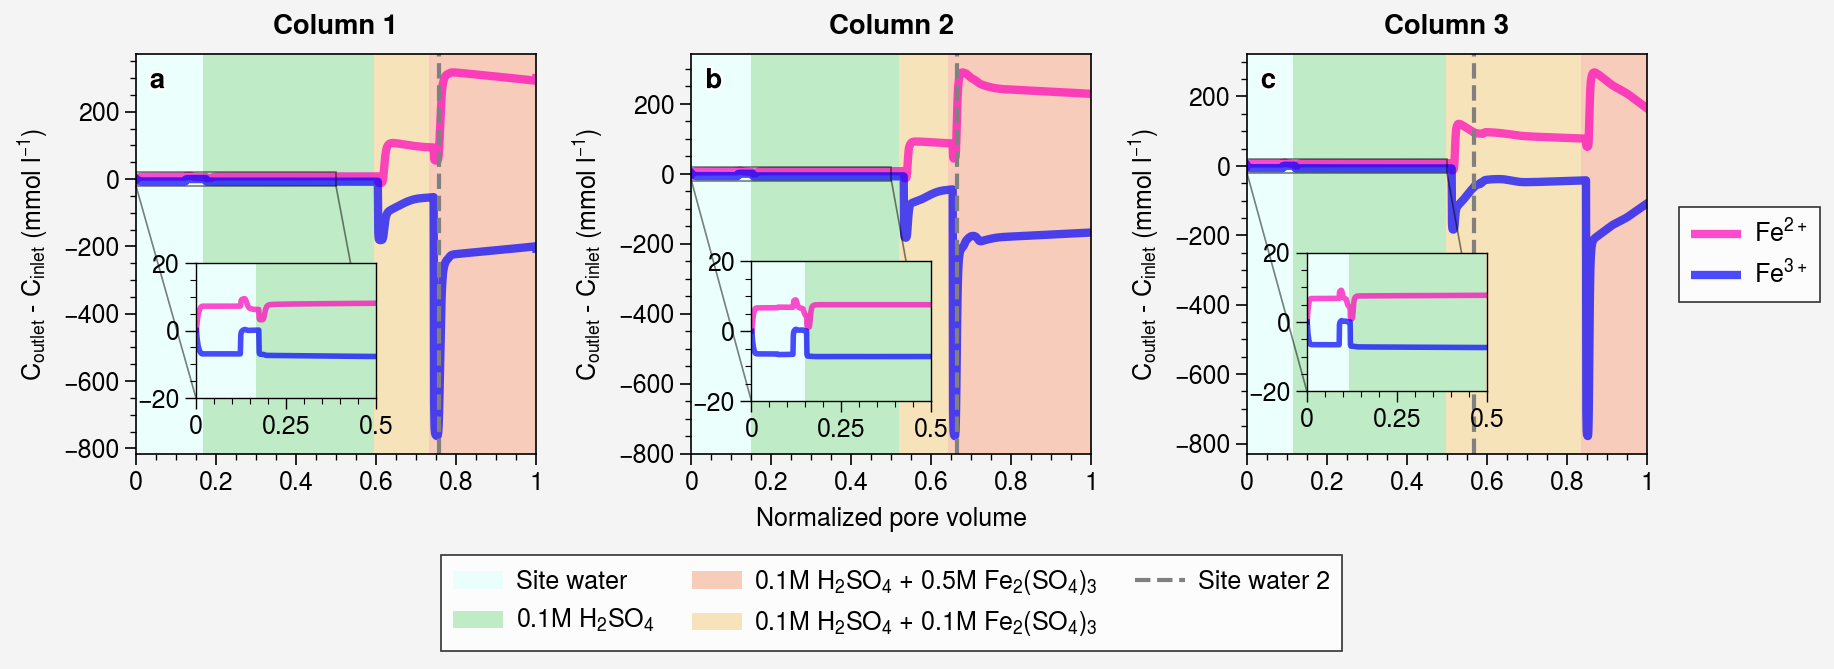

In [121]:
import proplot as pplt
import numpy as np


spFe = model_result_df[((model_result_df['variable_to_plot'].str.startswith('Fe('))  | (model_result_df['variable_to_plot'] == 'Fe mmol/L'))
                         & (model_result_df['model'] == 'complete') ]
FeSpecies = pd.unique(spFe['variable_to_plot'])
cnames = spFe.columns
normFeSpecies = pd.DataFrame(columns=cnames)

for sp in FeSpecies:
    tmpSp = spFe[spFe['variable_to_plot'] == sp].copy()
    FeTot = spFe[spFe['variable_to_plot'] == 'Fe mmol/L'].copy()
    if sp != 'Fe mmol/L':
        tmp_arr = tmpSp['value_mmol'] #/(FeTot['value_mmol'].to_numpy())
        tmpSp.loc[:,'value_mmol'] = tmp_arr
        tmpSp.loc[:, 'variable_to_plot'] = 'norm_'+sp
        normFeSpecies = normFeSpecies.append(tmpSp)

normFeSpecies = normFeSpecies[normFeSpecies['cell_type'] == 'adv']
normFeSpecies.loc[:, 'norm_PV'] = normFeSpecies['volume_cumulative_sample_pv']/normFeSpecies['toPV']
normFeSpecies = normFeSpecies[['norm_PV','elapsed_time_d', 'cell', 'column', 'lastAdvCell','value_mmol', 'variable_to_plot']]
normFeSpecies = normFeSpecies[(normFeSpecies['cell'] == 1) | (normFeSpecies['cell'] == normFeSpecies['lastAdvCell'] )]
normFeSpecies.loc[:, 'cell'] = np.where(normFeSpecies['cell'] == 1, 'inlet', 'outlet')
normFeSpeciesLong = normFeSpecies.pivot(index = ['norm_PV', 'elapsed_time_d', 'column'], columns = ['variable_to_plot', 'cell'],values = 'value_mmol',)
normFeSpeciesLong = normFeSpeciesLong.reset_index(level=[0,1,2])

normFeSpeciesLong.columns = normFeSpeciesLong.columns.map('|'.join).str.strip('|')
normFeSpeciesLong.loc[:, 'cons_Fe(2)'] = normFeSpeciesLong['norm_Fe(2) mmol/L|outlet'] - normFeSpeciesLong['norm_Fe(2) mmol/L|inlet']
normFeSpeciesLong.loc[:, 'cons_Fe(3)'] = normFeSpeciesLong['norm_Fe(3) mmol/L|outlet'] - normFeSpeciesLong['norm_Fe(3) mmol/L|inlet']
# print(normFeSpeciesLong.tail())

# normFeSpeciesLong_mean = normFeSpeciesLong.groupby(by = ['column', 'elapsed_time_d']).mean()
# normFeSpeciesLong_mean = normFeSpeciesLong_mean.reset_index(level=[0,1])
# normFeSpeciesLong_mean

vartoplot = ['cons_Fe(2)', 'cons_Fe(3)']
myorder = [0, 1]
vartoplot = [vartoplot[i] for i in myorder]
ncols = len(n_cols)
nrows = 1

cols = (list(n_cols)*ncols)

vars = sorted(vartoplot*ncols,key=vartoplot.index)

fig = pplt.figure(refwidth=2, sharey = False)
axs = fig.subplots(nrows=nrows, ncols=ncols)

toplabels = ['Column '+ str(s) for s in list(n_cols)]
toplabels[2] = 'Column 3' #changes column 4 to column 3. col3 not to be reported in paper in paper


for ax, col in zip(axs, cols):
    x_int = 0.01
    toPV = totalPV[(col)]
    nsw_pv = sw_inflow.loc[sw_inflow['column'] == int(col), 'norm_pv'].iloc[0]
    ix = ax.inset(
    [0.15, -650, .45, 400], transform='data', zoom=True)
    for stage in pd.unique(stages['stage']):
        xticks = np.arange(0,round(toPV),x_int)
        st = stages[stages['column'] == int(col)].dropna().copy()
        st.replace([np.inf, -np.inf], round(toPV) + x_int,inplace=True)
        st.replace([0], -x_int,inplace=True)
        if ~st['stage'].str.contains(stage).any():
            break
        tmp_st = st[st['stage'] == stage].copy()
        # print(tmp_st['pv_start'].item())
        ax.axvspan(tmp_st['norm_pv_start'].item(), tmp_st['norm_pv_end'].item(), facecolor=stColor[stage], alpha=0.8,zorder=0, label = tmp_st['value_str'].item())
        ix.axvspan(tmp_st['norm_pv_start'].item(), tmp_st['norm_pv_end'].item(), facecolor=stColor[stage], alpha=0.8,zorder=0, label = tmp_st['value_str'].item())
    sim = normFeSpeciesLong[(normFeSpeciesLong['column'] == col)]
    Fe2 = sim[['norm_PV', 'cons_Fe(2)']]
    Fe3 = sim[['norm_PV', 'cons_Fe(3)']]
    ax.plot(Fe2[['norm_PV']] ,sim[['cons_Fe(2)']], lw=3., alpha =0.7, labels='Fe(2)', c = '#ff00ba')
    ax.plot(Fe3[['norm_PV']] ,sim[['cons_Fe(3)']], lw=3., alpha =0.7, labels='Fe(3)', c = 'blue')
    ax.axvline(x = nsw_pv, ymin = 0, ymax = 1,
           color = '#808080', linestyle = 'dashed',
           label = 'Site water 2')
    ax.format(xlim = (0-x_int/2, round(toPV)+x_int/2))

    # ix = ax.inset(
    # [0.15, -650, .55, 400], transform='data', zoom=True)
    ix.format(grid=False,
        xlim=(0, 0.5), ylim=(-20, 20), linewidth=0.5, xticks=0.25)
    ix.plot(Fe2[['norm_PV']] ,sim[['cons_Fe(2)']], lw=2., alpha =0.7, labels='Fe(2)', c = '#ff00ba')
    ix.plot(Fe3[['norm_PV']] ,sim[['cons_Fe(3)']], lw=2, alpha =0.7, labels='Fe(3)', c = 'blue')
    ix.axvline(x = nsw_pv, ymin = 0, ymax = 1,
           color = '#808080', linestyle = 'dashed',
           label = 'Site water 2')
# for ax, col in zip(axs,  cols):
#     sim_mean = normFeSpeciesLong_mean[(normFeSpeciesLong_mean['column'] == col)]
#     # sim.loc[:, 'dist_m'] = sim['cell']*0.01
#     sim_mean = sim_mean.set_index(['norm_PV'])
#     sim_mean = sim_mean[vartoplot] #, 'norm_sp_CuCl2- mmol/L', 'norm_sp_CuCl3-2 mmol/L']]
#     # ax.plot(sim_mean, lw=3.5, alpha =0.7)
#     ax.area(sim_mean, stack = True, lw=3.5, alpha =1, cycle = 'FlatUI')

# pxs = axs.panel('b', space = 1,width='1em')

# for px, col in zip(pxs, cols):
#     nsw_pv = sw_inflow.loc[sw_inflow['column'] == int(col), 'norm_pv'].iloc[0]
#     st = stages[stages['column'] == int(col)].dropna().copy()
#     for stage in pd.unique(stages['stage']):
#         tmp_st = st[st['stage'] == stage].copy()
#         px.axvspan(tmp_st['norm_pv_start'].item(), tmp_st['norm_pv_end'].item(), facecolor=stColor[stage], alpha=0.8,zorder=0, label = tmp_st['value_str'].item())
#     px.axvline(x = nsw_pv, ymin = 0, ymax = 1,
#            color = '#808080',
#            label = 'Site water 2')

leftlabels = ['Fe$^{2+}$', 'Fe$^{3+}$']
handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, leftlabels, loc='r', order = 'F', ncols = 1, title= '')

handlespx, labelspx = axs[0].get_legend_handles_labels()
myorder = [  4 ,5 ,7 ,6, 2]
labelspx = [labelspx[i] for i in myorder]
handlespx = [handlespx[i] for i in myorder]

fig.legend(handlespx, labelspx, loc='b', order = 'F', ncols = 3)


axs.format( 
            grid=False, xlabel='Normalized pore volume', 
            ylabel = 'C$_{outlet}$ - C$_{inlet}$ (mmol l$^{-1}$)',
            suptitle='',
            toplabels= toplabels,
            #leftlabels=leftlabels,
            abc=True, abcloc='ul', abcbbox = False,
            # xticks=200, 
            # yticks=5,
            # ylim = [-20,20],
            xlim = [0,1]
    )
# pxs.format( grid=False, ylocator='null')
fig.save('./output/plots/paper/Fe_species.pdf')

### Rate plot

In [62]:
model.head()

cat  cell cell_type  colLength  column  elapsed_time_d  flowRateL  immPoro  \
0  sim   1.0       adv       0.32       1             0.1     0.2134    0.046   
1  sim   2.0       adv       0.32       1             0.1     0.2134    0.046   
2  sim   3.0       adv       0.32       1             0.1     0.2134    0.046   
3  sim   4.0       adv       0.32       1             0.1     0.2134    0.046   
4  sim   5.0       adv       0.32       1             0.1     0.2134    0.046   

   lastAdvCell  mobPoro  ...  nsw_tstep  param       toPV  toTime    totCu  \
0         32.0    0.414  ...       66.0     pH  56.117938    2064  0.07835   
1         32.0    0.414  ...       66.0     pH  56.117938    2064  0.07835   
2         32.0    0.414  ...       66.0     pH  56.117938    2064  0.07835   
3         32.0    0.414  ...       66.0     pH  56.117938    2064  0.07835   
4         32.0    0.414  ...       66.0     pH  56.117938    2064  0.07835   

                      type units value_mmol  variable_to_plot  \
0  Dissolved concentration           3.7949                pH   
1  Dissolved concentration           3.7922                pH   
2  Dissolved concentration           3.7904                pH   
3  Dissolved concentration           3.7898                pH   
4  Dissolved concentration           3.7896                pH   

  volume_cumulative_sample_pv  
0                    0.065253  
1                    0.065253  
2                    0.065253  
3                    0.065253  
4                    0.065253  

[5 rows x 21 columns]

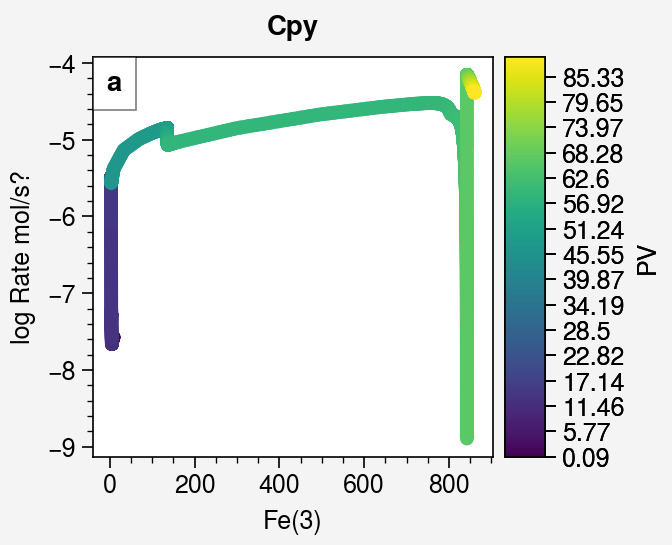

In [141]:
import numpy as np
import proplot as pplt

pH = model[(model['column'] == 2) & (model['variable_to_plot'] == 'pH')  & (model['cell'] == model['lastAdvCell']/2)]['value_mmol']
rate = model[(model['column'] == 2) & (model['variable_to_plot'] == 'rate_Malachite mmol/L') & (model['cell'] == model['lastAdvCell']/2)]['value_mmol']
test = model[(model['column'] == 2) & ((model['variable_to_plot'] == 'rate_Malachite mmol/L') | (model['variable_to_plot'] == 'rate_Chalcopyrite mmol/L') | 
(model['variable_to_plot'] == 'pH') | (model['variable_to_plot'] == 'Fe(3) mmol/L')) 
& (model['cell'] == model['lastAdvCell']/2)][['volume_cumulative_sample_pv','variable_to_plot','value_mmol']]

test_pivot = pd.pivot(test, values = 'value_mmol', columns = 'variable_to_plot', index = 'volume_cumulative_sample_pv')
test_pivot['PV'] = test_pivot.index
test_pivot = test_pivot.reset_index(level=[0], drop = True)
test_pivot.head()
fig = pplt.figure(refwidth=2, sharey = True)
axs = fig.subplots(nrows=1, ncols=1)
# axs[0].scatter(x =test_pivot['Fe(3) mmol/L'] ,y = np.log10(test_pivot['rate_Chalcopyrite mmol/L']), s=40, marker='o', alpha =0.8, c = test_pivot['PV'],edgecolors = '#022345', colorbar='r')
axs[0].parametric(x = test_pivot['Fe(3) mmol/L'] ,y = np.log10(test_pivot['rate_Chalcopyrite mmol/L']), cmap = 'viridis', c = test_pivot['PV'], interp = 10, lw=5, colorbar='r', capstyle='round',  joinstyle='round')
axs.format( 
            grid=False, xlabel='Fe(3)', ylabel = 'log Rate mol/s?',
            suptitle='Cpy',
            abc=True, abcloc='ul', abcbbox = True,
            # xticks=20, 
            # yticks=5,
)

## All measured metals plot

In [ ]:
# ######################################################################################################## 
# #### Read observation data
# ######################################################################################################## 

# # column data includes cu recovery (from AAS), pore volume exchange, and measured parameters
# column_data = pd.read_excel('./input/columns_master.xlsx', sheet_name = 'column_data')

# #solution_icp includes icp data for elements (including copper)
# solution_icp = pd.read_excel('./input/columns_master.xlsx', sheet_name = 'solution_icp', header=2)
# solution_icp[solution_icp._get_numeric_data()<0] = np.nan #bdl to nan
# solution_icp = solution_icp.replace('<', '', regex=True)

# summary = column_data.groupby('column').describe().T
# # summary.to_csv('./output/dataframes/colmun_summary.csv')

# alldata =pd.merge(column_data, solution_icp, how='outer')
# # alldata.to_csv('./output/dataframes/kapunda.csv')

# ######################################################################################################## 
# #### Data processing
# ########################################################################################################

# alldata_melted = pd.melt(alldata, id_vars =['column', 'column_name','elapsed_time_h','date',
# 	'date_time','time','volume_cumulative_sample_pv'])
# # print(pd.unique(alldata_melted.variable))

# no_plot = ['mass_sample_g', 'stages',
#        'density_sample_gm/L', 'volume_sample_mL',
#        'volume_solution_container_mL', 'flowrate_mL/h',
#        'volume_sample_pv', 'column_pressure',
#        'mass_solution_container_g' ,'volume_cumulative_sample_mL',
#        'Au_ug/L', 'Ag_ug/L', 
#        'Ba_mg/L', 
#        'Be_mg/L',
#        'Bi_mg/L', 
#        'Cd_mg/L', 'Ce_ug/L',  'Cs_ug/L', 
#        'Dy_ug/L',
#        'Er_ug/L', 'Eu_ug/L', 'Ga_mg/L', 'Gd_mg/L', 'Hf_mg/L', 'Ho_ug/L', 'In_ug/L',
#        'La_ug/L', 
#        'Lu_ug/L',  'Nd_ug/L',  
#        'Pr_ug/L', 'Rb_ug/L', 'Sb_ug/L', 'Se_mg/L', 'Sm_ug/L', 'Sn_mg/L', 'Sr_mg/L',
#        'Tb_ug/L', 'Te_mg/L', 'Th_ug/L', 'Tl_ug/L', 'Tm_ug/L', 'U_mg/L', 'Y_ug/L',
#        'Yb_ug/L', 'Zr_mg/L', 'B_mg/L', 
#        'Cr_mg/L', 
#        'Pb_mg/L',
#        'Ti_mg/L', 
#        'V_mg/L', 'Cu from AA (mg/L) new site water','Cu_extracted_g' ,'Cu_cumulative_g','Cu_mg/L',
#        'As_mg/L', 'Li_mg/L', 
#        # 'Mn_mg/L', 
#        'Mo_mg/L', 
#        # 'Co_mg/L'
#        ]
# alldata_melted_selection = alldata_melted[np.logical_not(alldata_melted['variable'].isin(no_plot))]
# alldata_melted_selection = alldata_melted_selection.drop(columns = ['date', 'date_time','time'])
# alldata_melted_selection['value'] = alldata_melted_selection['value'].astype('float')
# alldata_melted_selection = alldata_melted_selection.dropna()

# alldata_melted_selection['value_g'] = np.where(alldata_melted_selection['variable'].str.contains('mg/L'), 
#        alldata_melted_selection['value']/1000,
#        np.where(alldata_melted_selection['variable'].str.contains('ug/L'),
#        	alldata_melted_selection['value']/1000000,
#        alldata_melted_selection['value']))

# alldata_melted_selection['units'] = alldata_melted_selection['variable'].str.split('_',3).str[-1]

# alldata_melted_selection['param'] = alldata_melted_selection['variable'].str.split('_',3).str[0]
# alldata_melted_selection['comment'] = alldata_melted_selection['variable'].str.split('_',1).str[-1]
# alldata_melted_selection['comment'] = np.where(alldata_melted_selection['comment'].str.contains('_'),
#                                    alldata_melted_selection['comment'].str.split('_',1).str[0],
#                                    ''
#                                    )

# alldata_melted_selection['cat'] = np.where((alldata_melted_selection['variable'].str.contains('g/L')),
#                                    'compo',
#                                    'parameter'
#                                    )
# alldata_melted_selection['mol_mass'] = alldata_melted_selection['param'].map(elements_dict)                                  
# alldata_melted_selection['value_mmol'] = np.where(alldata_melted_selection['cat'] == 'compo',
#                                    alldata_melted_selection['value_g']/alldata_melted_selection['mol_mass']*1000,
#                                    alldata_melted_selection['value'])  
# alldata_melted_selection['variable_to_plot'] = np.where(alldata_melted_selection['cat'] == 'compo',
#                                    alldata_melted_selection['param'] +' mmol/L '+ 
#                                    alldata_melted_selection['comment'],
#                                    alldata_melted_selection['param']+ ' ' 
#                                    +alldata_melted_selection['units'])
# alldata_melted_selection['variable_to_plot'] = alldata_melted_selection['variable_to_plot'].str.rstrip()
# alldata_melted_selection['variable_to_plot'] =  np.where(alldata_melted_selection['variable_to_plot'] == 'Cu mmol/L AA', 
# 	'Cu mmol/L', alldata_melted_selection['variable_to_plot'])
# alldata_melted_selection['obs_volume_cumulative_sample_pv'] = alldata_melted_selection['volume_cumulative_sample_pv'] 
# alldata_melted_selection['toPV'] = alldata_melted_selection['column'].map(totalPV)
# alldata_melted_selection['toTime'] = alldata_melted_selection['column'].map(totalTime)
# alldata_melted_selection['volume_cumulative_sample_pv'] = alldata_melted_selection['elapsed_time_h']/alldata_melted_selection['toTime']*alldata_melted_selection['toPV'] 
# alldata_melted_selection = alldata_melted_selection[alldata_melted_selection['elapsed_time_h']!= 0]


# Calibration and sensitivity analysis
## Run 00

### Prior distribution  

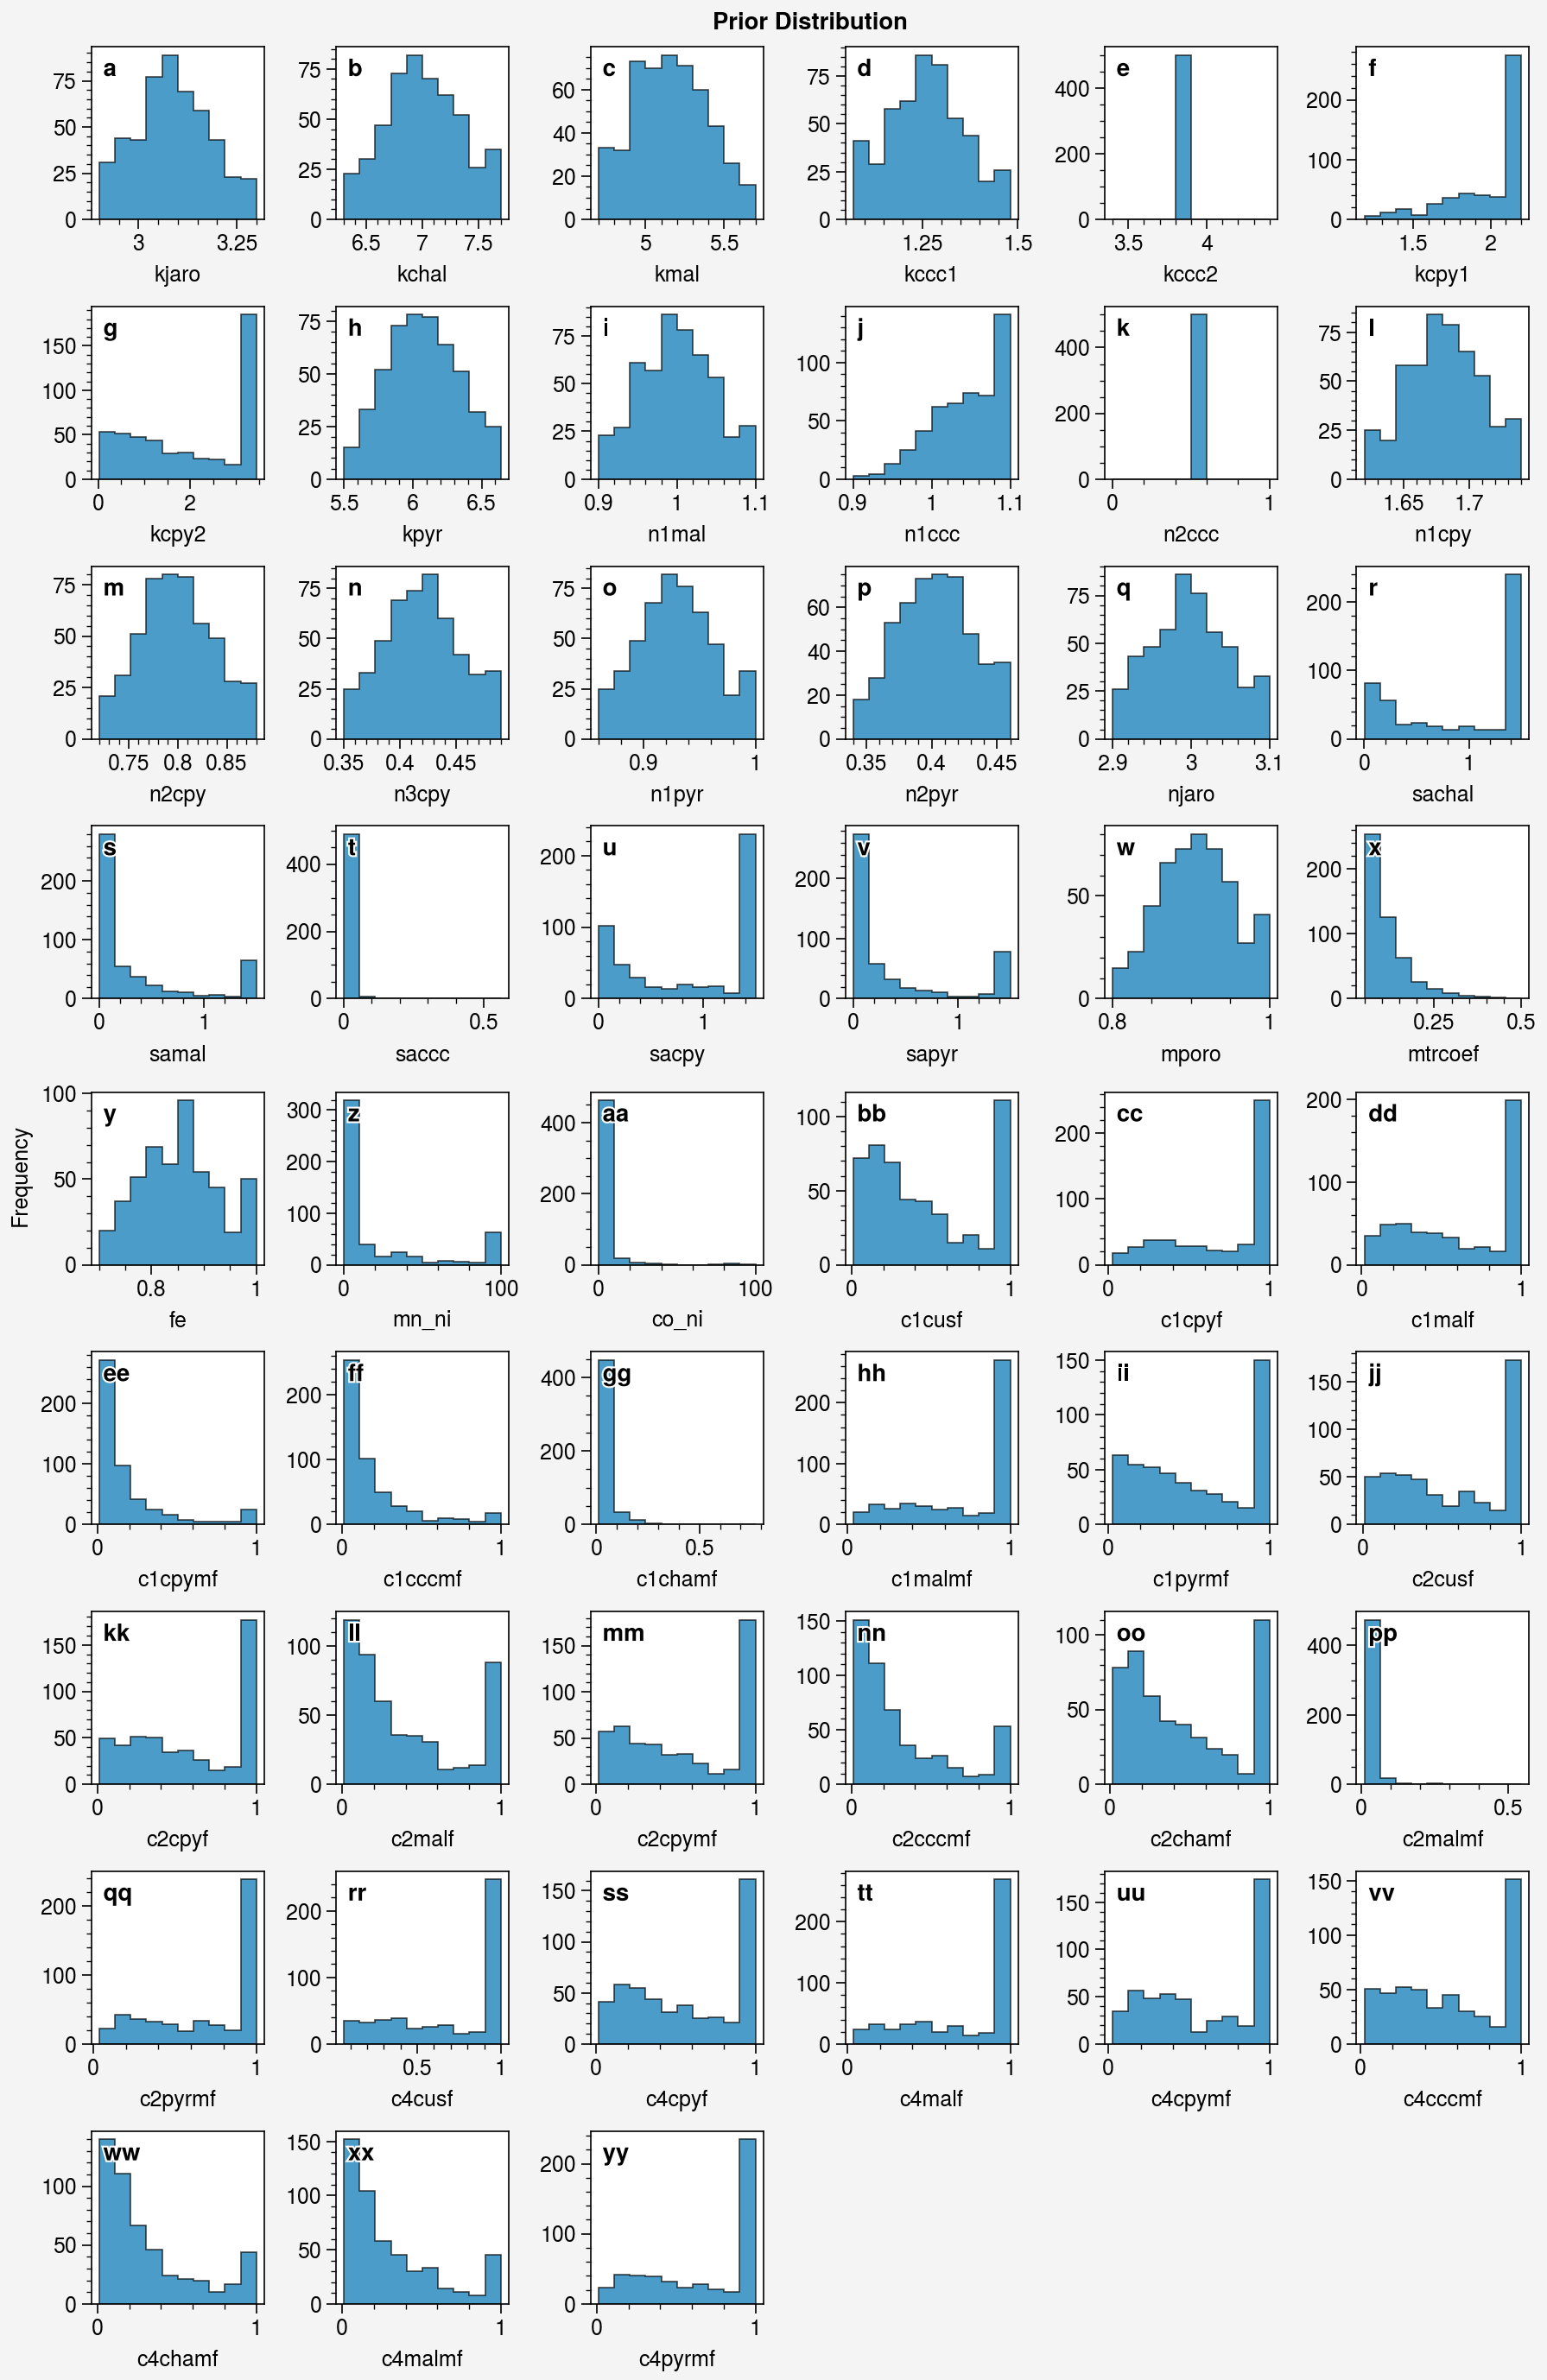

In [3]:
import numpy as np 
import pandas as pd 
import pyemu
import proplot as pplt
import matplotlib.pyplot as plt

run = '00'

path_to_rs = './model/pht3d/pest/results/run' + run + '/queen/run'+run+'_adj.'

prior = pyemu.ParameterEnsemble.from_binary(pst=path_to_rs+'pst', filename=path_to_rs+ "0.par.jcb")

pars = list(prior._df.columns)
n_par = len(prior._df.columns)
ncols = round(n_par/9)
nrows = n_par // ncols + (n_par % ncols > 0)

pic_arr = np.arange(ncols*(nrows-1))+1
pic_arr = np.append(pic_arr, [[49,50,51,0,0,0]]).reshape(nrows, -1)

fig = pplt.figure(refwidth=1,  sharey = 'labels', sharex = False)
axs = fig.subplots(pic_arr)

for ax, par in zip(axs, pars):
    # print(ax, par)
    ax.hist(prior._df.loc[:, par], filled=True, alpha=0.7, edgecolor='k')
    ax.format(xlabel = par)
axs.format( 
            grid=False, 
            # xlabel='Parameter value', 
            ylabel = 'Frequency',
            suptitle='Prior Distribution',
            # labels= pars,
            # title=pars,
            abc=True, abcloc='ul', abcbbox = False,
            # xticks=200, 
            # yticks=5,
            # ylim = [0,1],
            # xlim = [0,1]
    )

### Posterior distribution

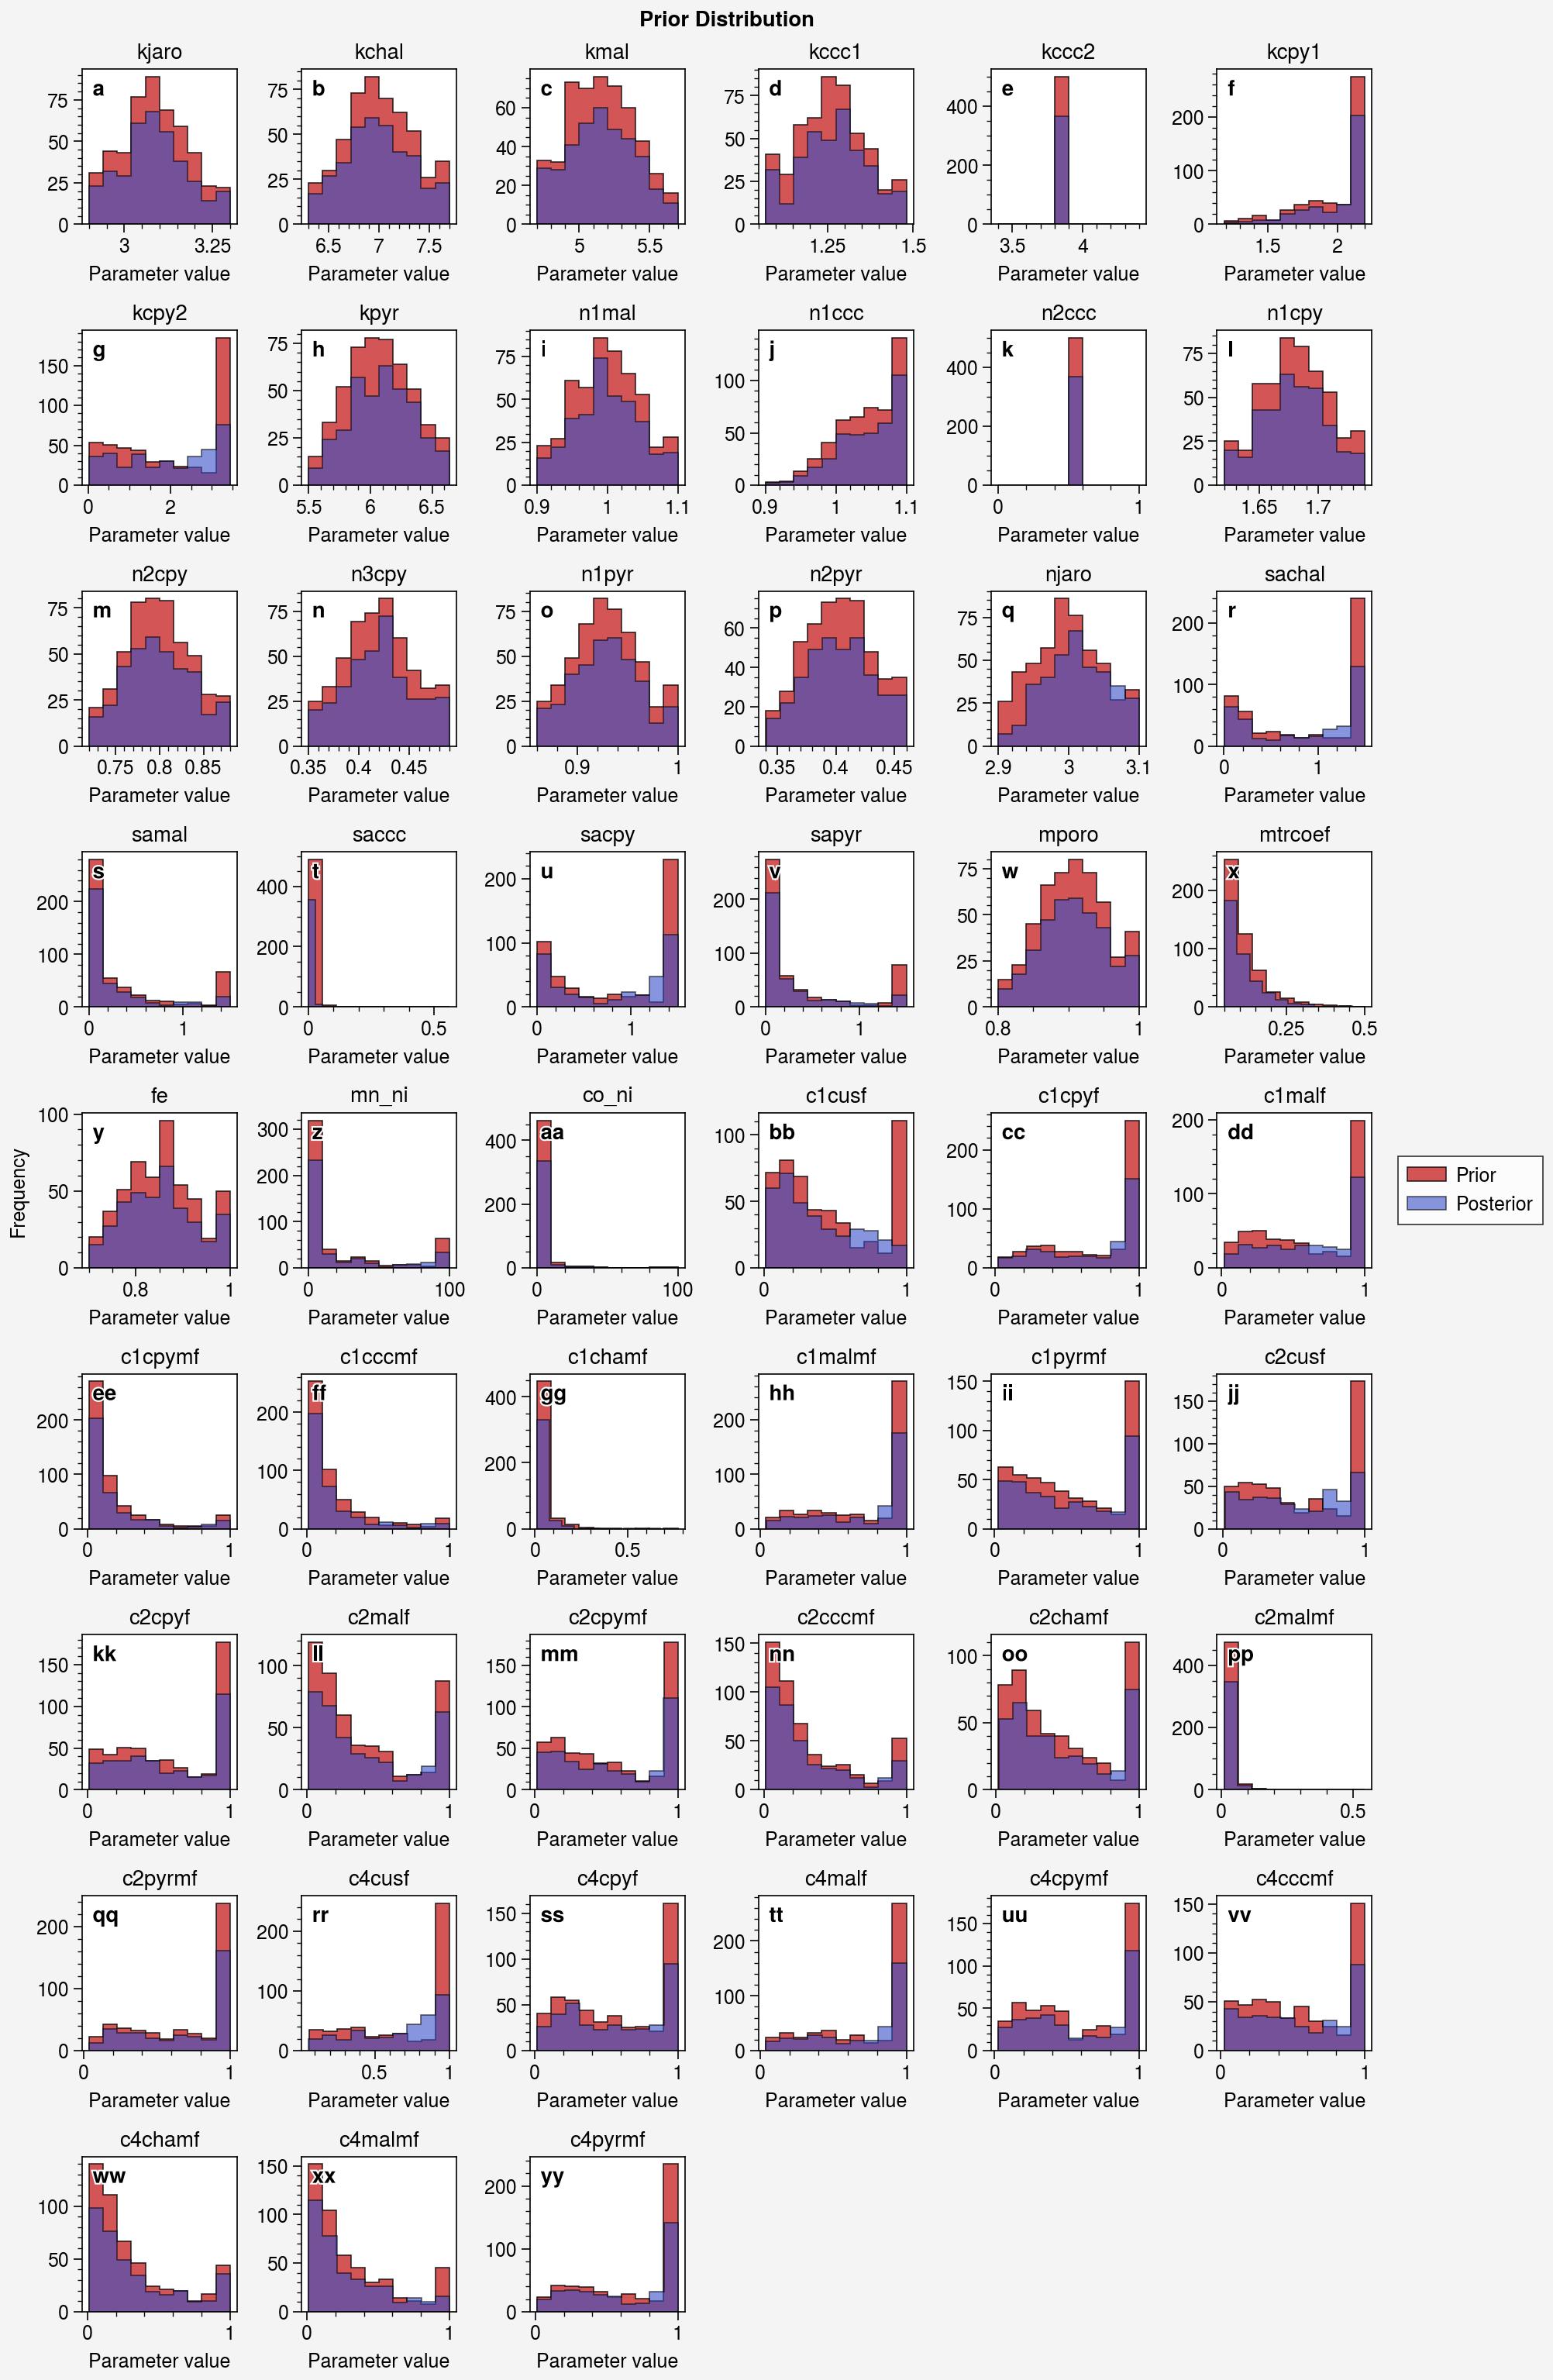

In [5]:
import numpy as np 
import pandas as pd 
import pyemu
import proplot as pplt
import matplotlib.pyplot as plt

# run = 'run02'

# path_to_rs = './model/pht3d/pest/results/' + run + '/queen/run02_adj.'

prior = pyemu.ParameterEnsemble.from_binary(pst=path_to_rs+'pst', filename=path_to_rs+ "0.par.jcb")
post = pyemu.ParameterEnsemble.from_binary(pst=path_to_rs+'pst', filename=path_to_rs+ "5.par.jcb")

pars = list(prior._df.columns)
n_par = len(prior._df.columns)
ncols = round(n_par/9)
nrows = n_par // ncols + (n_par % ncols > 0)

pic_arr = np.arange(ncols*(nrows-1))+1
pic_arr = np.append(pic_arr, [[49,50,51,0,0,0]]).reshape(nrows, -1)

fig = pplt.figure(refwidth=1,  share = 'labels', sharex = False)
axs = fig.subplots(pic_arr)

for ax, par in zip(axs, pars):
    # print(ax, par)
    ax.hist(prior._df.loc[:, par], filled=True, alpha=0.8, color='red9', edgecolor='k', label = 'Prior')
    ax.hist(post._df.loc[:, par], filled=True, alpha=0.6, color = 'indigo9', edgecolor='k', label = 'Posterior')
    ax.format(title = par)
handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='r', order = 'F', ncols = 1, title= '')

axs.format( 
            grid=False, 
            xlabel='Parameter value', 
            ylabel = 'Frequency',
            suptitle='Prior Distribution',
            # labels= pars,
            # title=pars,
            abc=True, abcloc='ul', abcbbox = False,
            # xticks=200, 
            # yticks=5,
            # ylim = [0,1],
            # xlim = [0,1]
    )

## Run01
### Prior Distribution

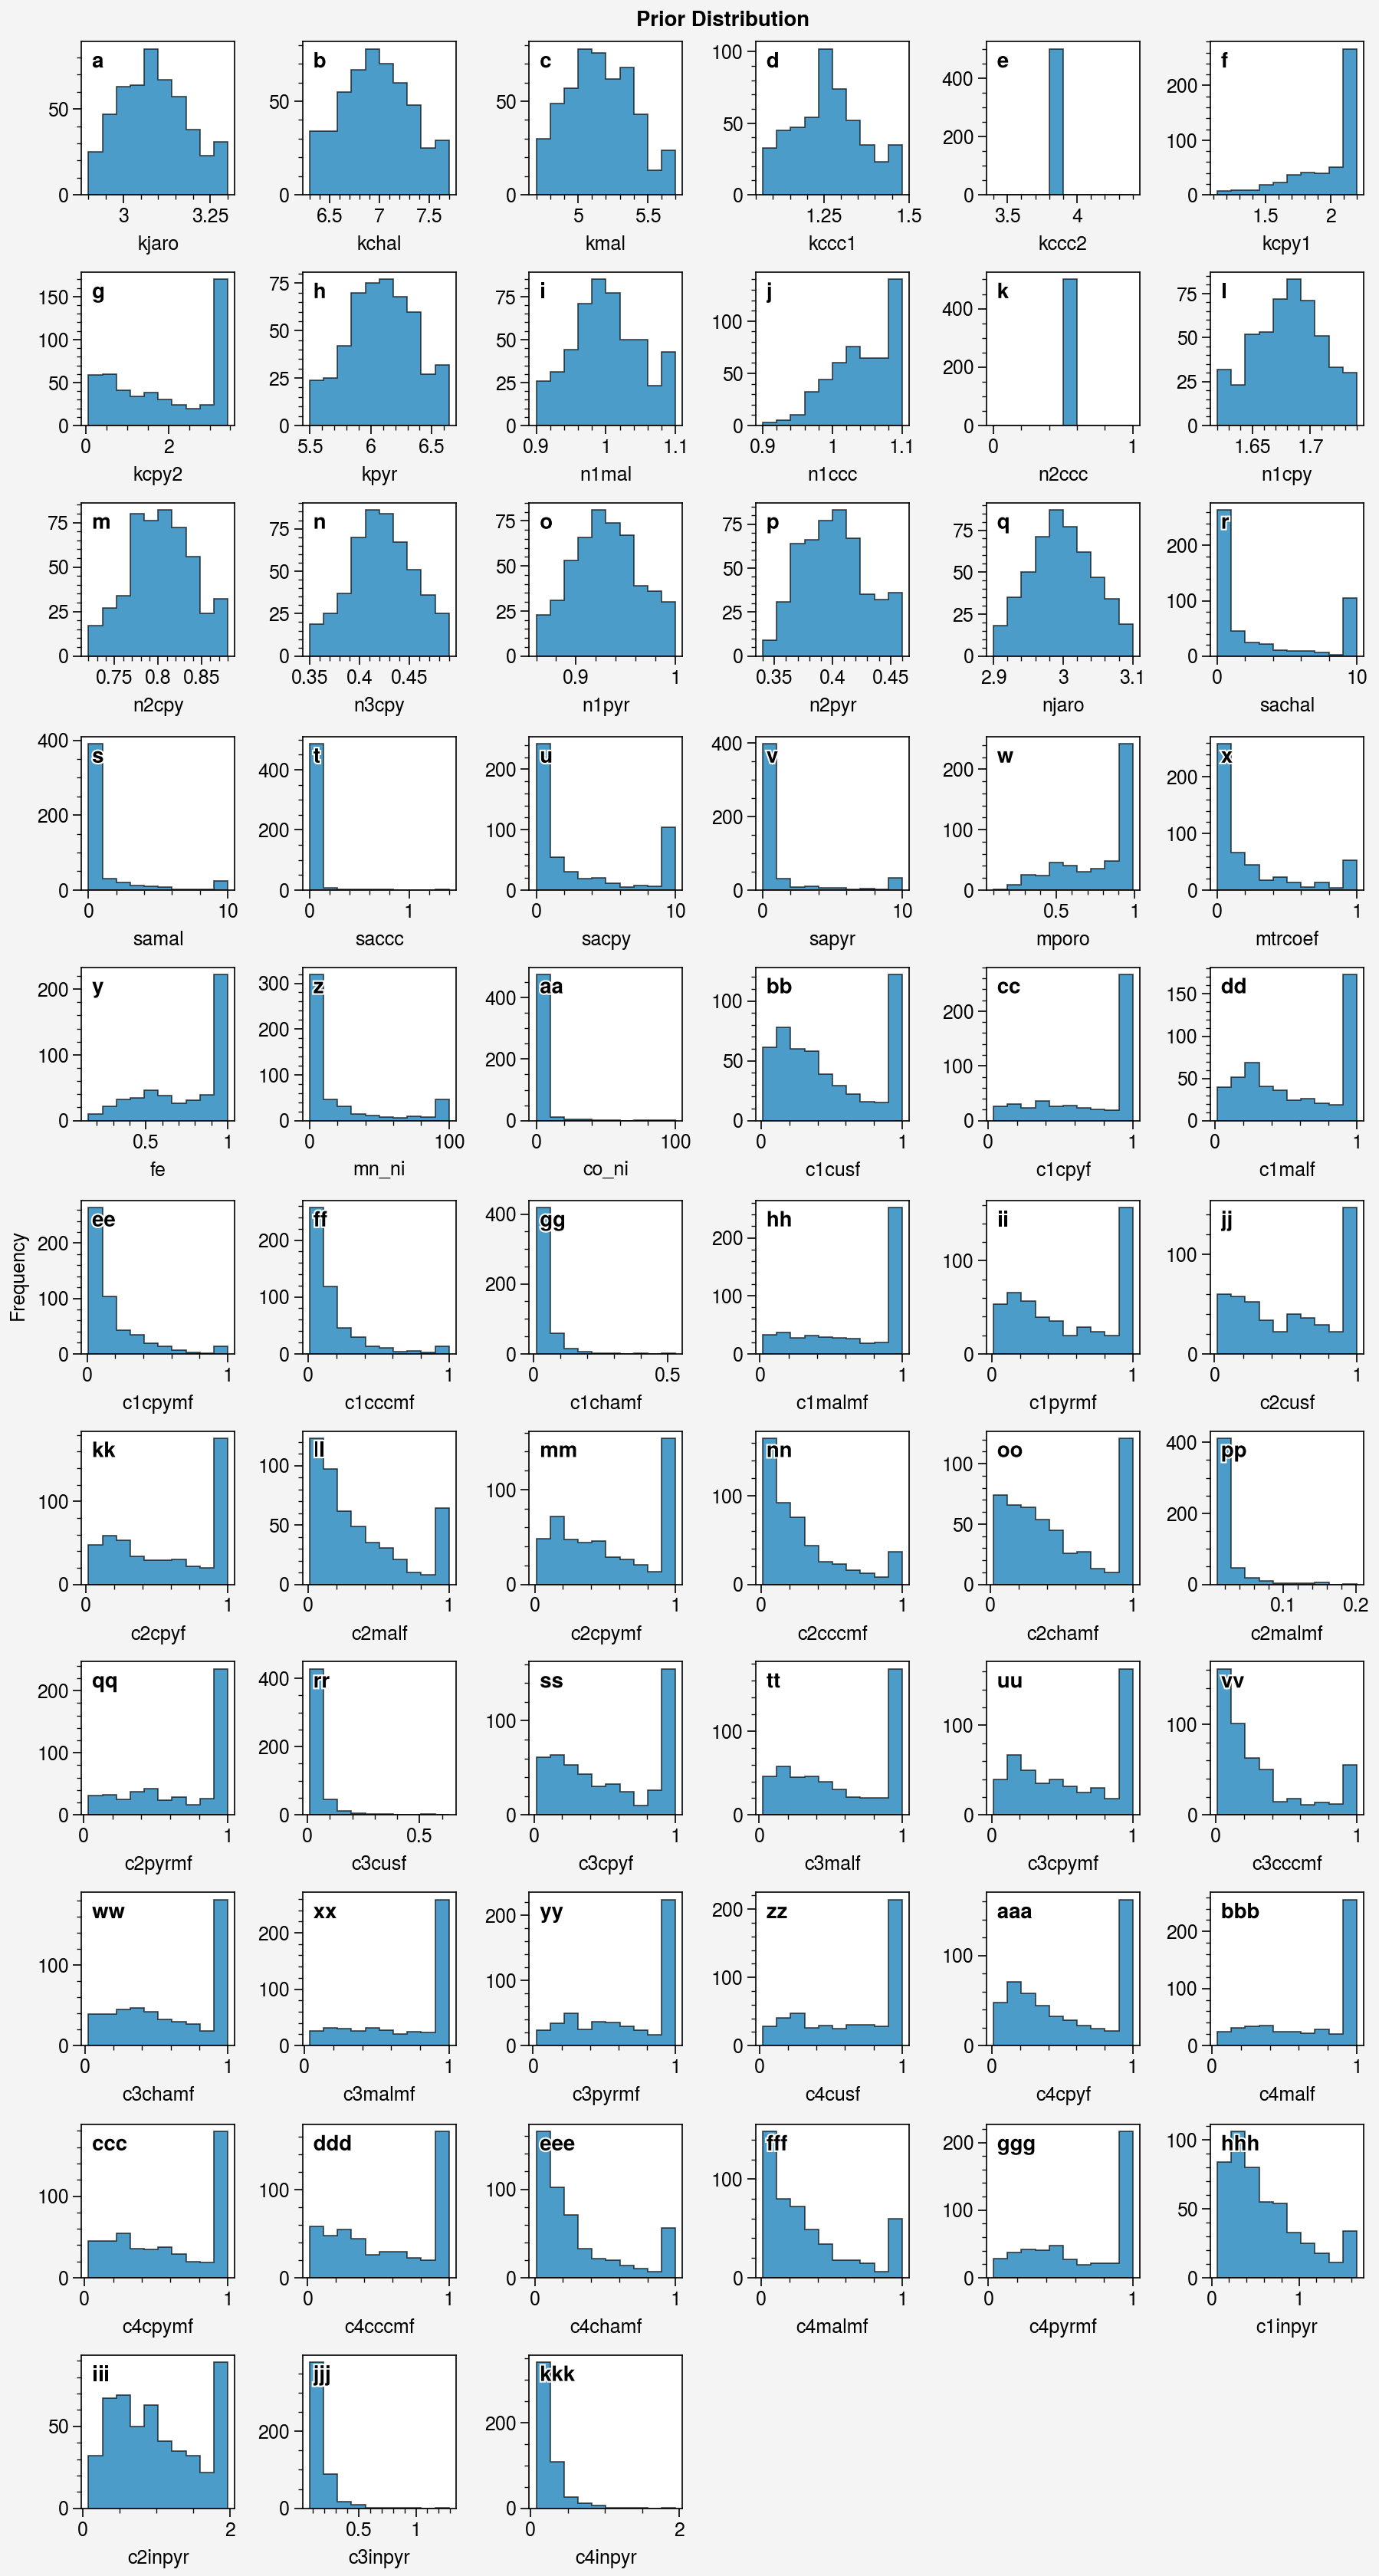

In [1]:
import numpy as np 
import pandas as pd 
import pyemu
import proplot as pplt
import matplotlib.pyplot as plt

run = '01'

path_to_rs = './model/pht3d/pest/results/run' + run + '/queen/run'+run+'_adj.'

prior = pyemu.ParameterEnsemble.from_binary(pst=path_to_rs+'pst', filename=path_to_rs+ "0.par.jcb")

pars = list(prior._df.columns)
n_par = len(prior._df.columns)
ncols = round(n_par/10)
nrows = n_par // ncols + (n_par % ncols > 0)

pic_arr = np.arange(ncols*(nrows-1))+1
# print(pic_arr)
pic_arr = np.append(pic_arr, [[61,62,63,0,0,0]]).reshape(nrows, -1)

fig = pplt.figure(refwidth=1,  sharey = 'labels', sharex = False)
axs = fig.subplots(pic_arr)

for ax, par in zip(axs, pars):
    # print(ax, par)
    ax.hist(prior._df.loc[:, par], filled=True, alpha=0.7, edgecolor='k')
    ax.format(xlabel = par)
axs.format( 
            grid=False, 
            # xlabel='Parameter value', 
            ylabel = 'Frequency',
            suptitle='Prior Distribution',
            # labels= pars,
            # title=pars,
            abc=True, abcloc='ul', abcbbox = False,
            # xticks=200, 
            # yticks=5,
            # ylim = [0,1],
            # xlim = [0,1]
    )

### Posterior Distribution

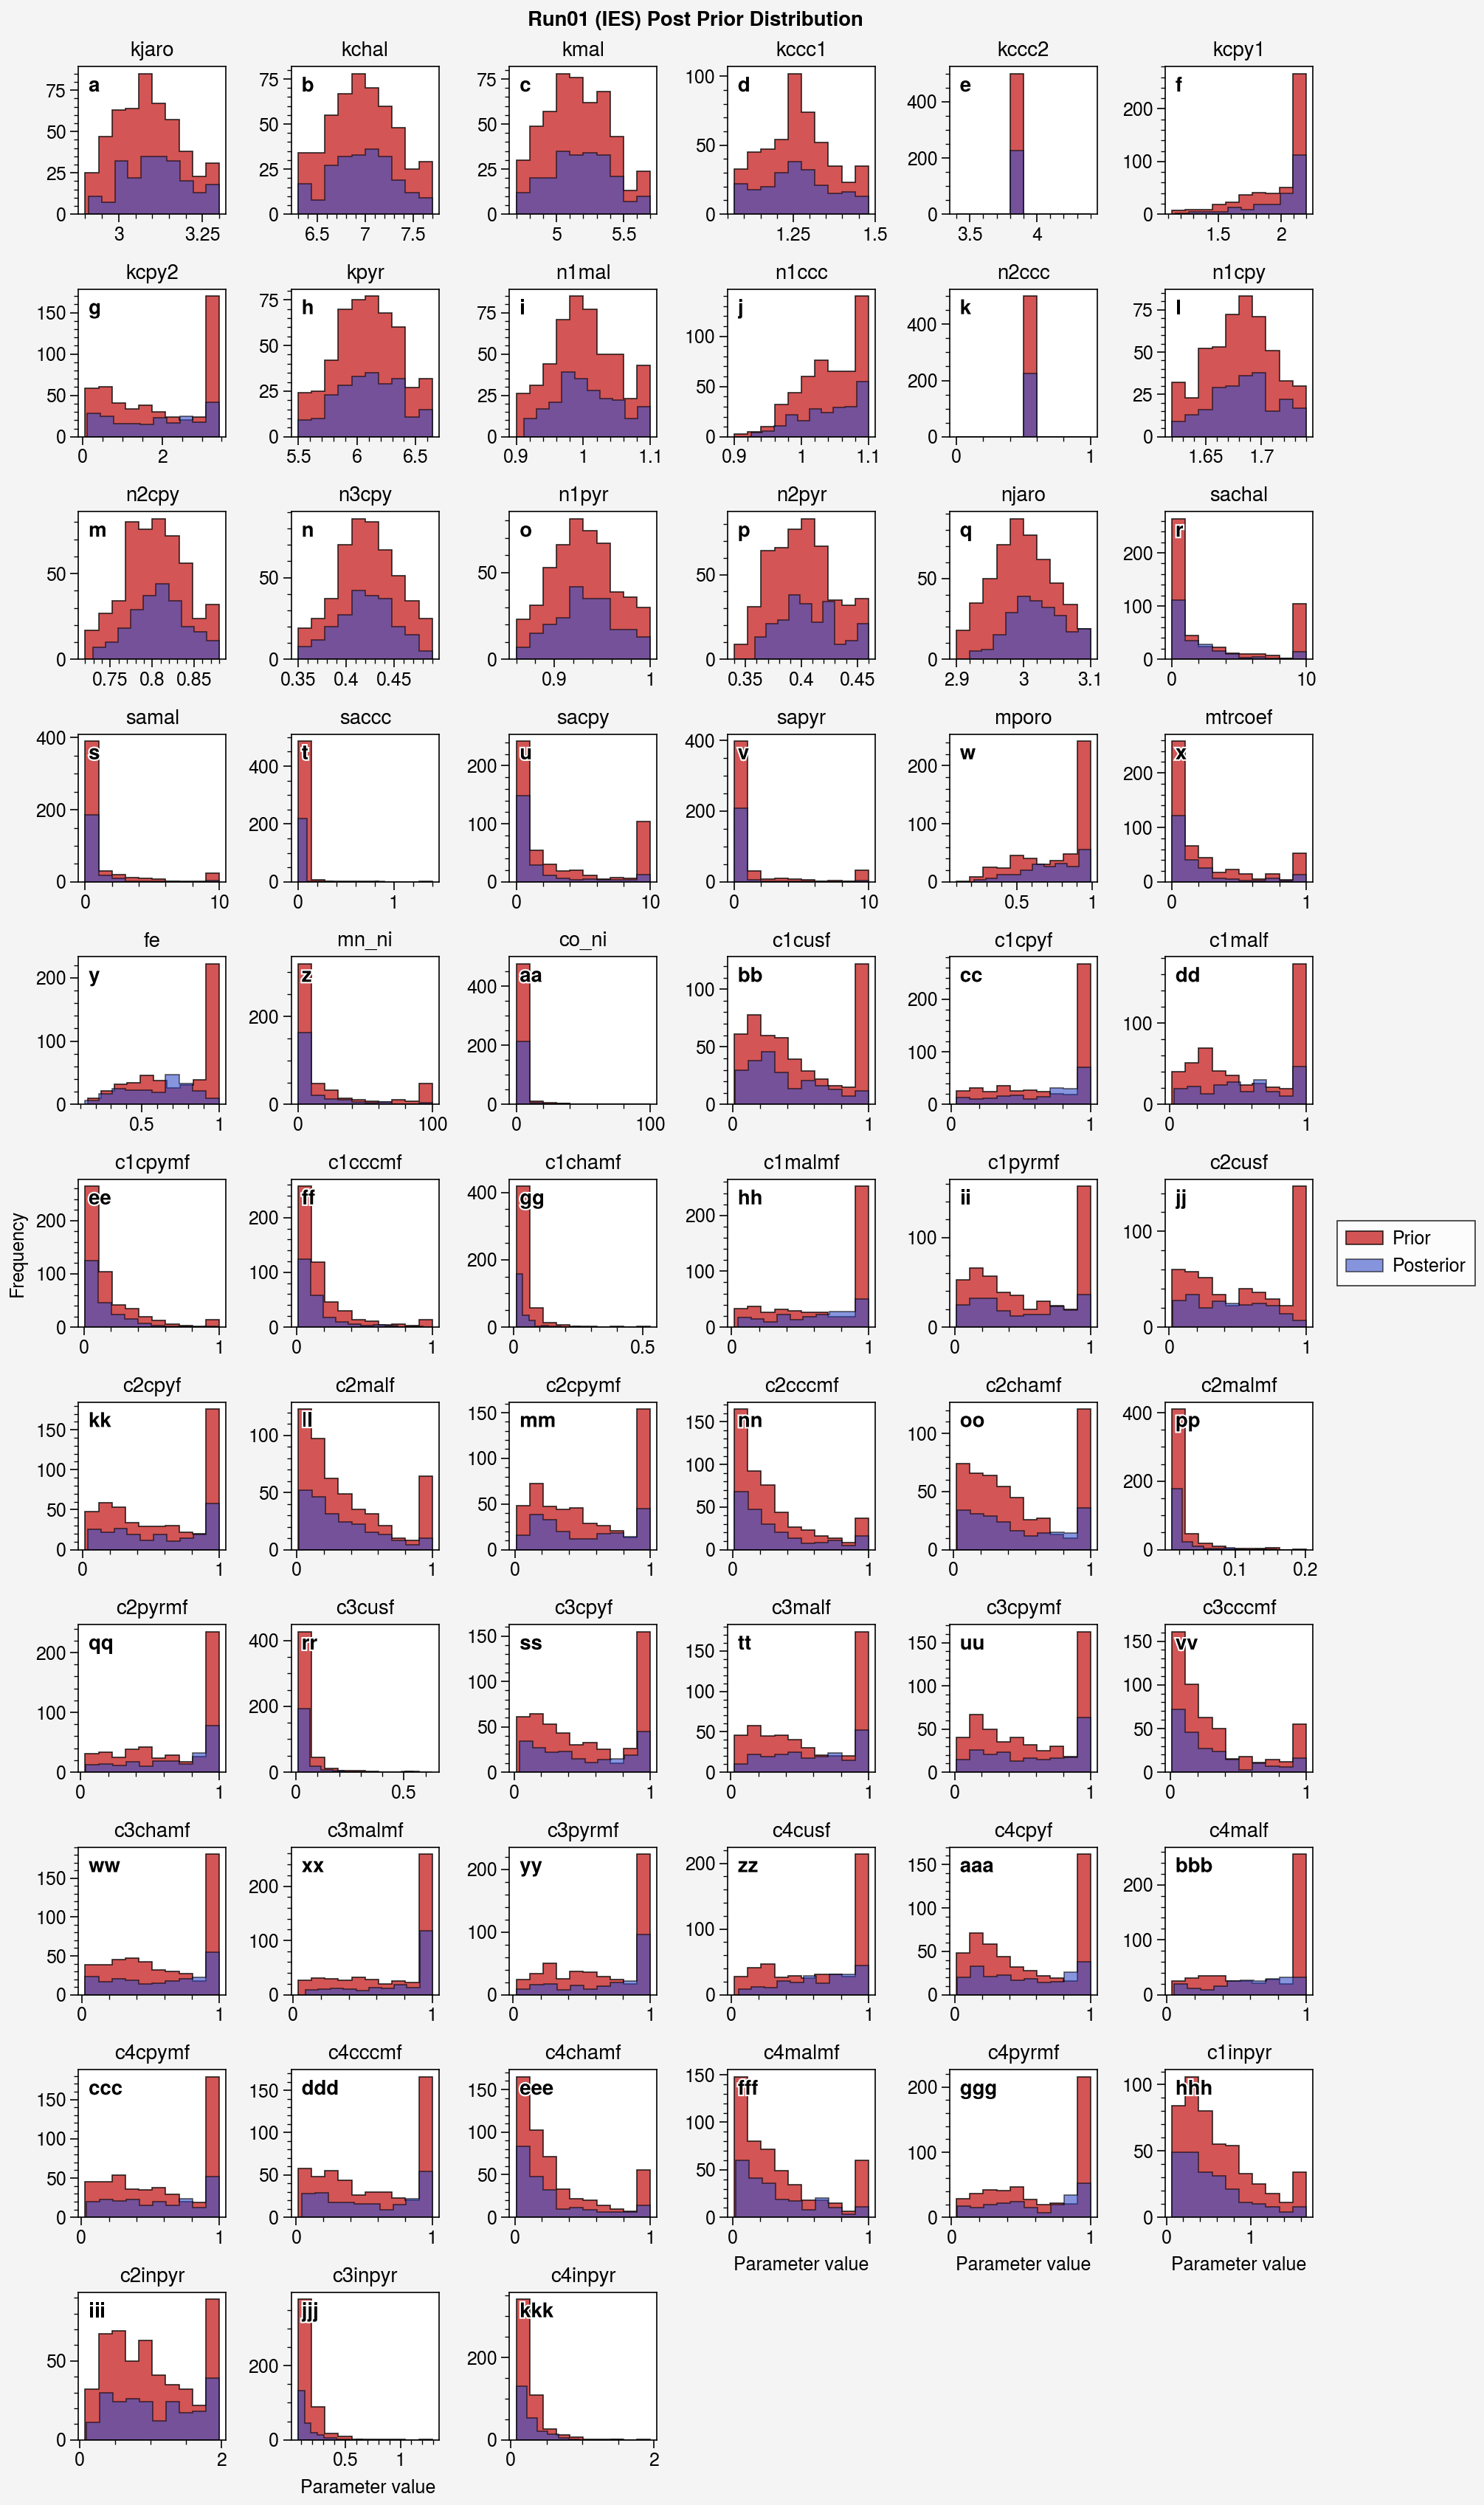

In [2]:
import numpy as np 
import pandas as pd 
import pyemu
import proplot as pplt
import matplotlib.pyplot as plt

# run = 'run02'

# path_to_rs = './model/pht3d/pest/results/' + run + '/queen/run02_adj.'

prior = pyemu.ParameterEnsemble.from_binary(pst=path_to_rs+'pst', filename=path_to_rs+ "0.par.jcb")
post = pyemu.ParameterEnsemble.from_binary(pst=path_to_rs+'pst', filename=path_to_rs+ "18.par.jcb")

pars = list(prior._df.columns)
n_par = len(prior._df.columns)
ncols = round(n_par/10)
nrows = n_par // ncols + (n_par % ncols > 0)

pic_arr = np.arange(ncols*(nrows-1))+1
pic_arr = np.append(pic_arr, [[61,62,63,0,0,0]]).reshape(nrows, -1)

fig = pplt.figure(refwidth=1,  share = 'labels', sharex = 'labels')
axs = fig.subplots(pic_arr)

for ax, par in zip(axs, pars):
    # print(ax, par)
    ax.hist(prior._df.loc[:, par], filled=True, alpha=0.8, color='red9', edgecolor='k', label = 'Prior')
    ax.hist(post._df.loc[:, par], filled=True, alpha=0.6, color = 'indigo9', edgecolor='k', label = 'Posterior')
    ax.format(title = par)
handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='r', order = 'F', ncols = 1, title= '')

axs.format( 
            grid=False, 
            xlabel='Parameter value', 
            ylabel = 'Frequency',
            suptitle='Run'+ run + ' (IES) Post Prior Distribution',
            # labels= pars,
            # title=pars,
            abc=True, abcloc='ul', abcbbox = False,
            # xticks=200, 
            # yticks=5,
            # ylim = [0,1],
            # xlim = [0,1]
    )
fig.save('./model/pht3d/pest/results/output/run'+run+'_ies_prior_post_hist.png')

## Run02
### Prior Dist

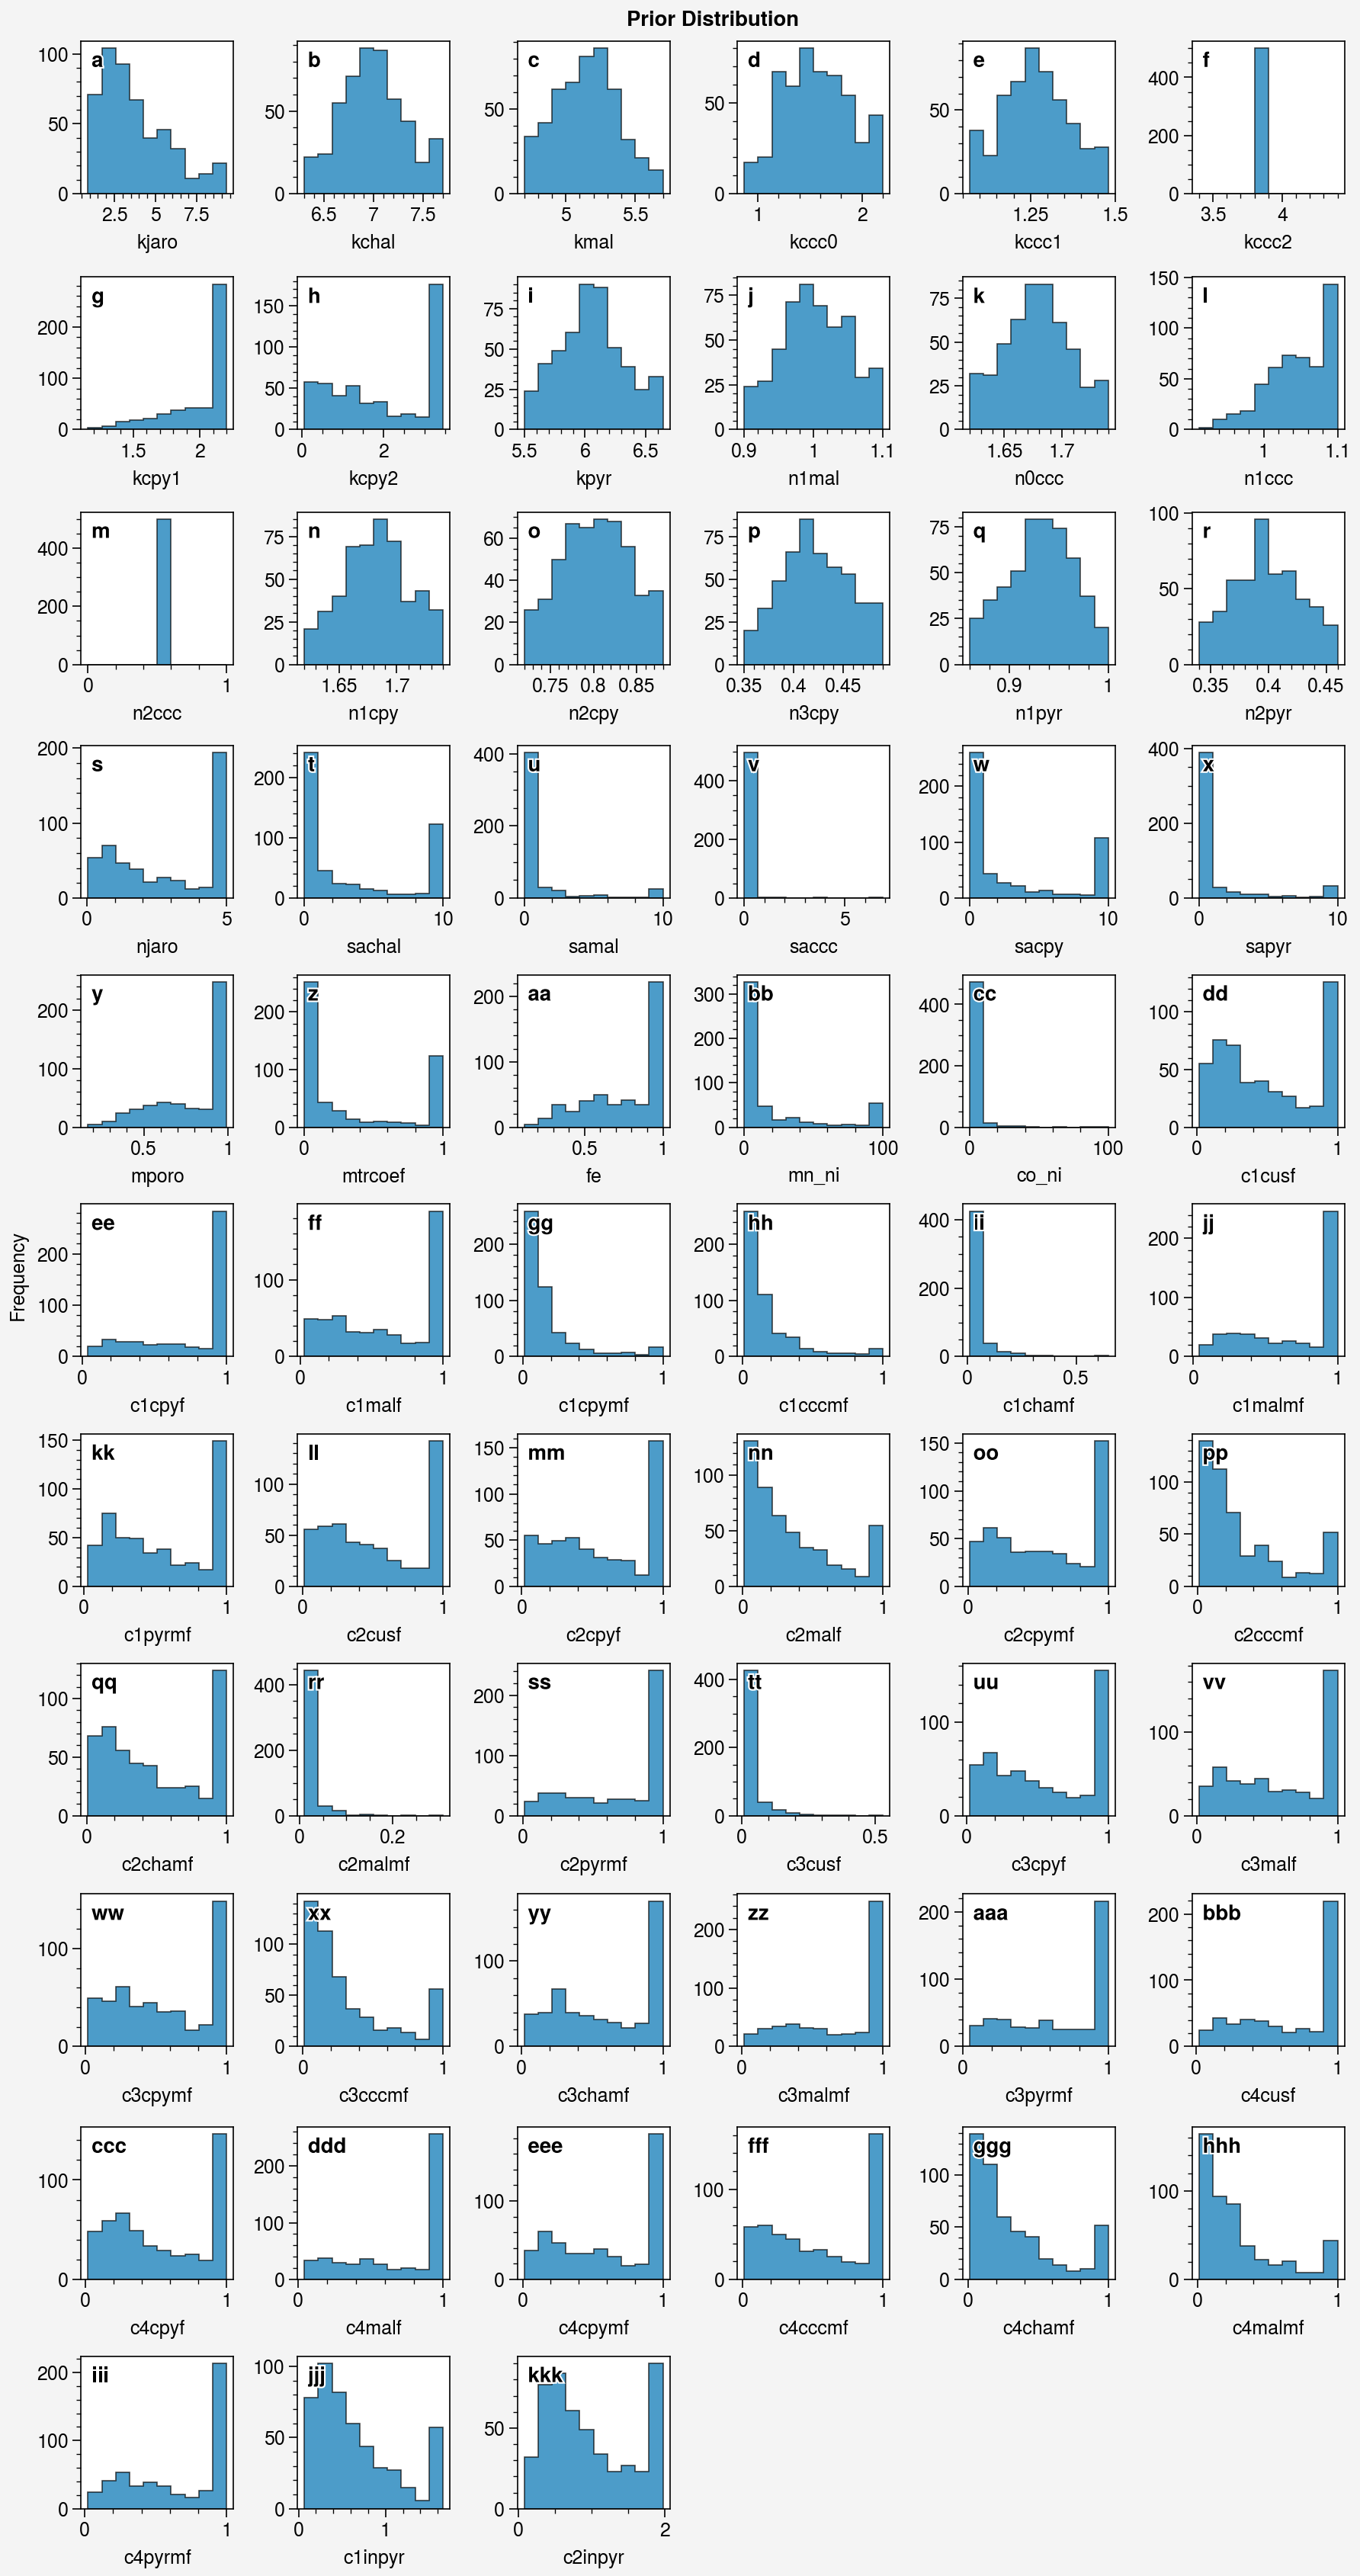

In [1]:
import numpy as np 
import pandas as pd 
import pyemu
import proplot as pplt
import matplotlib.pyplot as plt

run = '02'

path_to_rs = './model/pht3d/pest/results/run' + run + '/queen/run'+run+'_adj.'

prior = pyemu.ParameterEnsemble.from_binary(pst=path_to_rs+'pst', filename=path_to_rs+ "0.par.jcb")

pars = list(prior._df.columns)
n_par = len(prior._df.columns)
ncols = round(n_par/10)
nrows = n_par // ncols + (n_par % ncols > 0)

pic_arr = np.arange(ncols*(nrows-1))+1
# print(pic_arr)
pic_arr = np.append(pic_arr, [[61,62,63,0,0,0]]).reshape(nrows, -1)

fig = pplt.figure(refwidth=1,  sharey = 'labels', sharex = False)
axs = fig.subplots(pic_arr)

for ax, par in zip(axs, pars):
    # print(ax, par)
    ax.hist(prior._df.loc[:, par], filled=True, alpha=0.7, edgecolor='k')
    ax.format(xlabel = par)
axs.format( 
            grid=False, 
            # xlabel='Parameter value', 
            ylabel = 'Frequency',
            suptitle='Prior Distribution',
            # labels= pars,
            # title=pars,
            abc=True, abcloc='ul', abcbbox = False,
            # xticks=200, 
            # yticks=5,
            # ylim = [0,1],
            # xlim = [0,1]
    )

### Post Dist

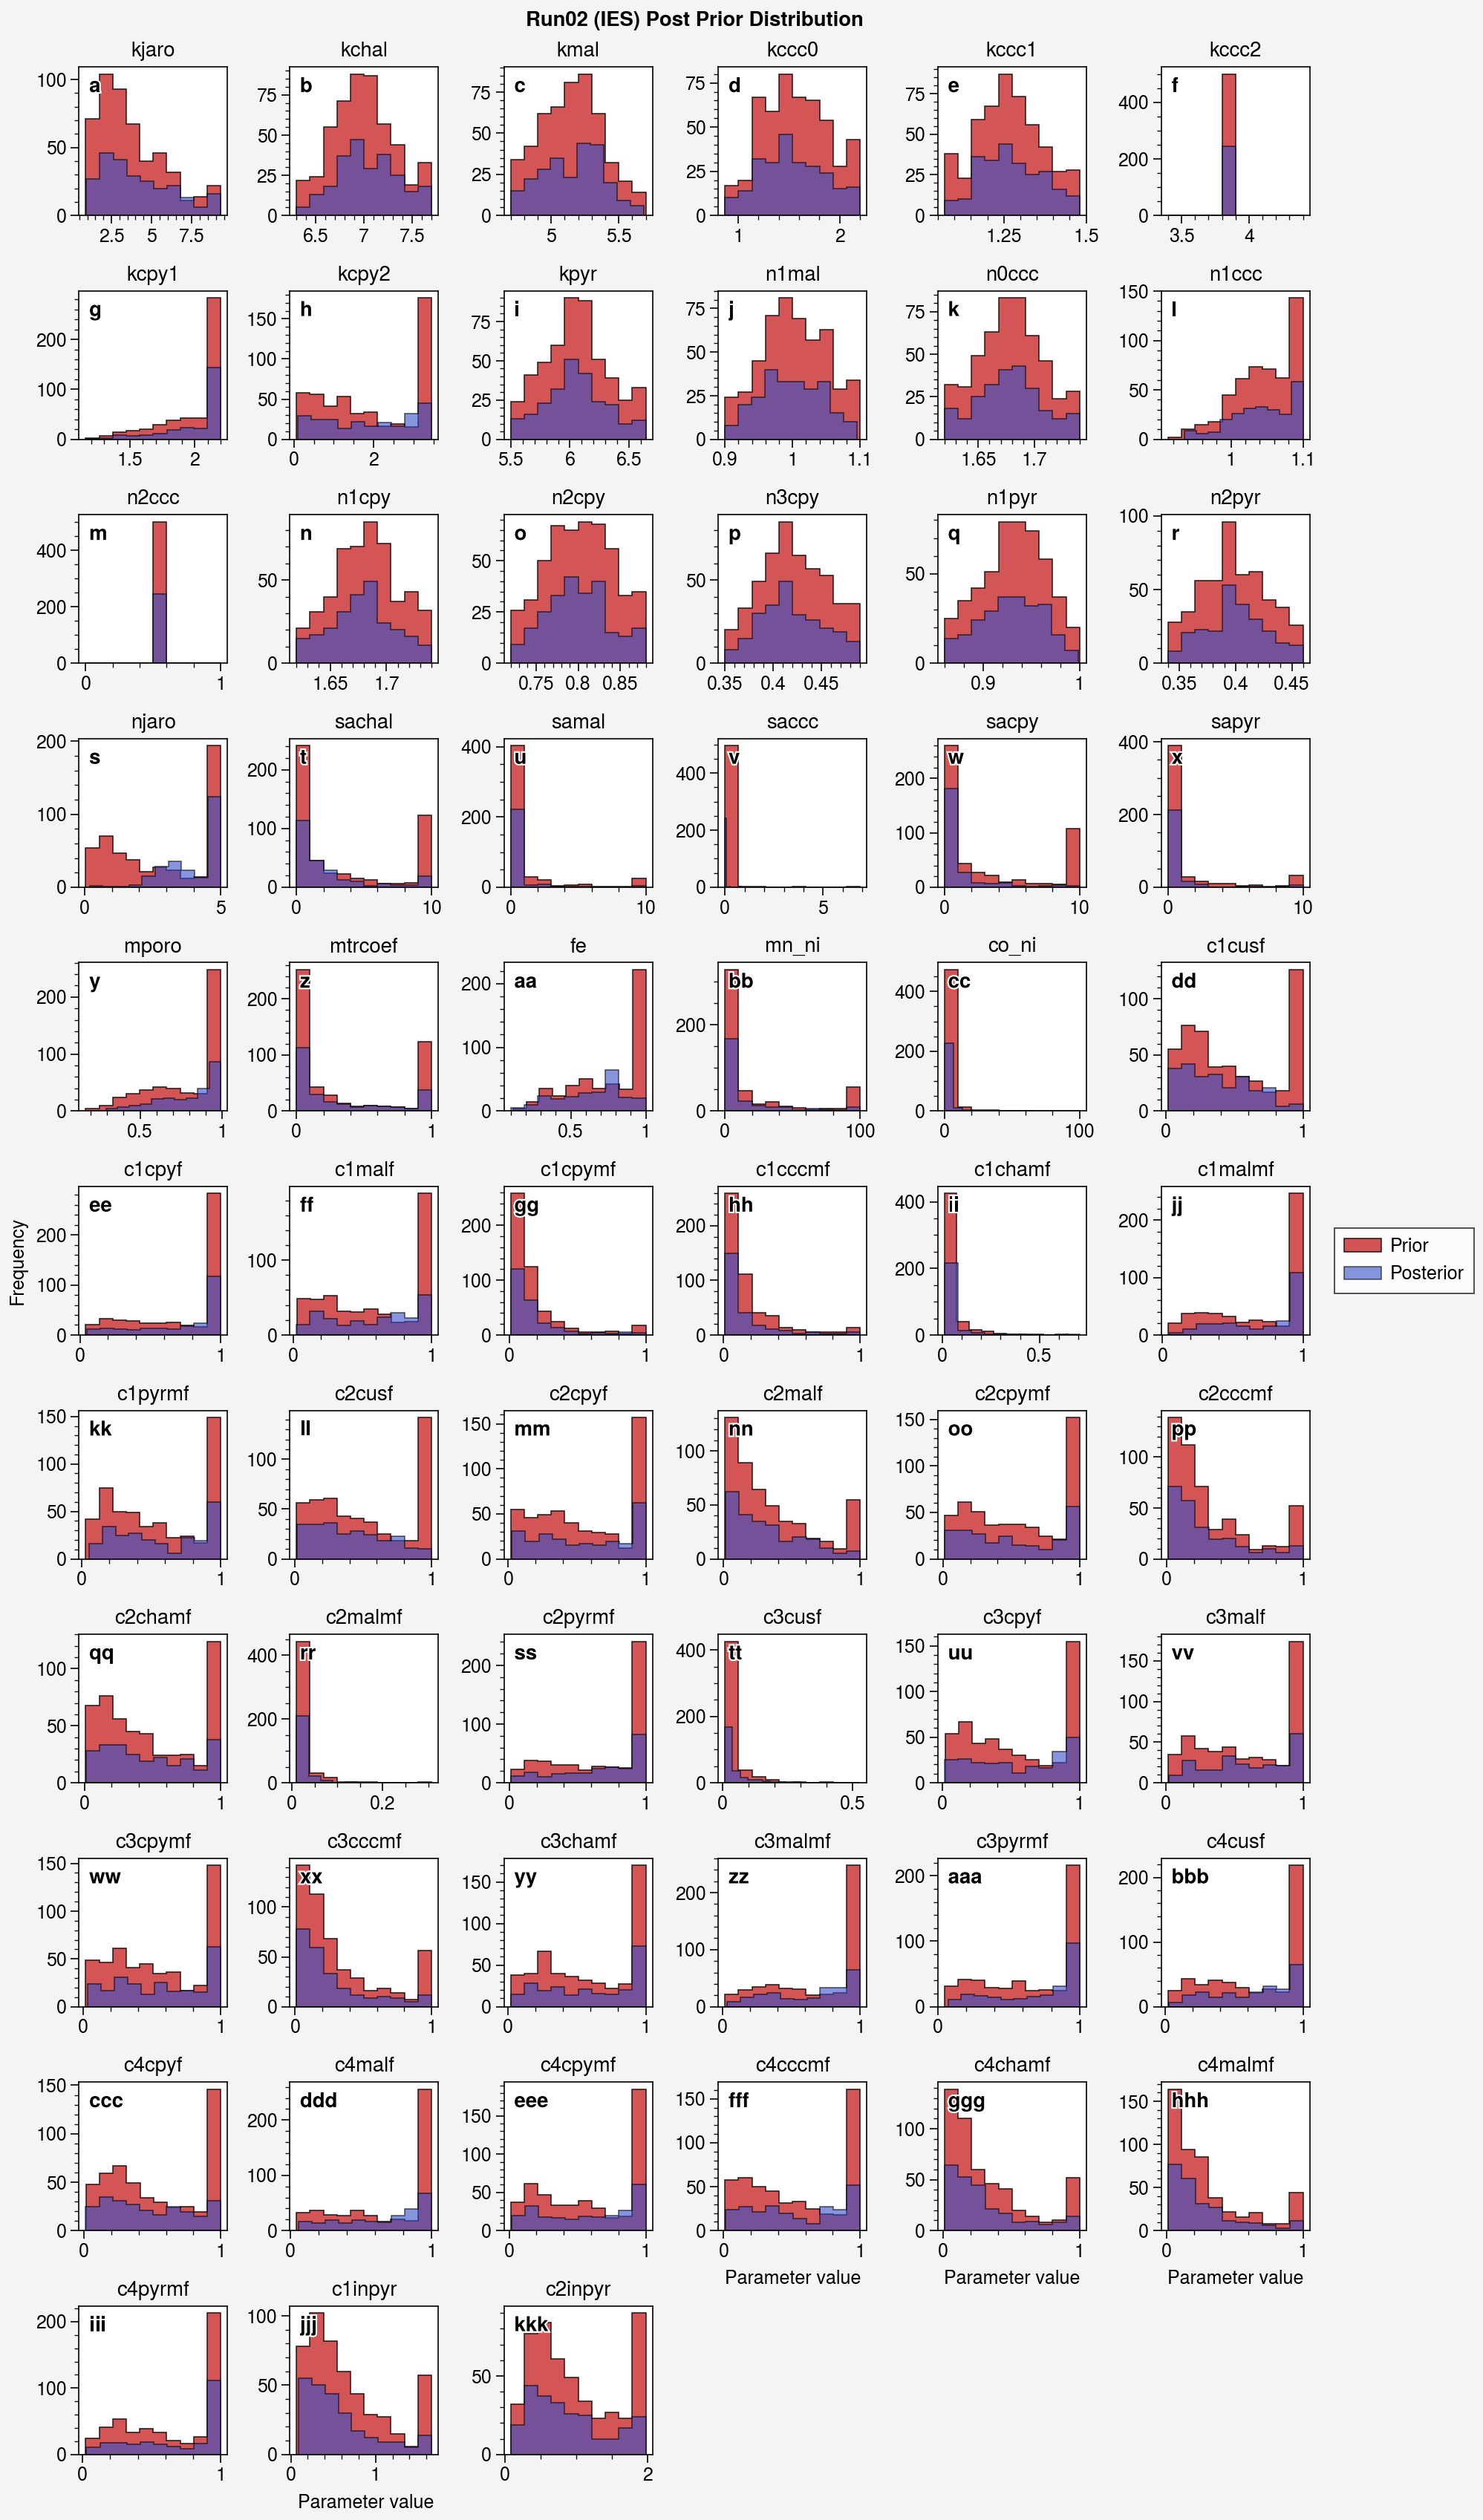

In [2]:
import numpy as np 
import pandas as pd 
import pyemu
import proplot as pplt
import matplotlib.pyplot as plt

# run = 'run02'

# path_to_rs = './model/pht3d/pest/results/' + run + '/queen/run02_adj.'

prior = pyemu.ParameterEnsemble.from_binary(pst=path_to_rs+'pst', filename=path_to_rs+ "0.par.jcb")
post = pyemu.ParameterEnsemble.from_binary(pst=path_to_rs+'pst', filename=path_to_rs+ "9.par.jcb")

pars = list(prior._df.columns)
n_par = len(prior._df.columns)
ncols = round(n_par/10)
nrows = n_par // ncols + (n_par % ncols > 0)

pic_arr = np.arange(ncols*(nrows-1))+1
pic_arr = np.append(pic_arr, [[61,62,63,0,0,0]]).reshape(nrows, -1)

fig = pplt.figure(refwidth=1,  share = 'labels', sharex = 'labels')
axs = fig.subplots(pic_arr)

for ax, par in zip(axs, pars):
    # print(ax, par)
    ax.hist(prior._df.loc[:, par], filled=True, alpha=0.8, color='red9', edgecolor='k', label = 'Prior')
    ax.hist(post._df.loc[:, par], filled=True, alpha=0.6, color = 'indigo9', edgecolor='k', label = 'Posterior')
    ax.format(title = par)
handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='r', order = 'F', ncols = 1, title= '')

axs.format( 
            grid=False, 
            xlabel='Parameter value', 
            ylabel = 'Frequency',
            suptitle='Run'+ run + ' (IES) Post Prior Distribution',
            # labels= pars,
            # title=pars,
            abc=True, abcloc='ul', abcbbox = False,
            # xticks=200, 
            # yticks=5,
            # ylim = [0,1],
            # xlim = [0,1]
    )
fig.save('./model/pht3d/pest/results/output/run'+run+'_ies_prior_post_hist.png')